# PGQC Analysis - Shaw2021 - 50 e. coli genomes

In [49]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline


In [50]:
import matplotlib.patches as mpatches


In [51]:
%reload_ext autoreload
%autoreload 2

### import pgqc (pan-genome quality control) toolkit functions
from pgqc.ava import ava
from pgqc.nscluster import clusterBy_KmerJC, summarize_NSClusters, create_MaxKmerSim_JC_Dict, create_MST_FiltByJC, make_ClusterID_Maps 
from pgqc.nscluster import make_NS_ClusterMerged_Pres_DF


from pgqc.utils import parse_PresAbs_Rtab, parse_PresAbs_CSV_Roary, parse_PresAbs_CSV_Panaroo, get_PG_Stats_FromPresAbs
from pgqc.utils import  parse_PG_Ref_FA, get_PG_Stats_FromDNASeqPresAbs


from pgqc.asm_gene_search import parse_AlnHits_To_DF
from pgqc.asm_gene_search import PresAbsQC_CheckAsmForGeneSeq, SRAsm_PresAbsQC_CheckInLRAsm
from pgqc.asm_gene_search import get_SRAsm_Vs_LRAsm_QCStats, get_AsmSeqCheck_QCStats



In [52]:
import time

In [53]:
import screed

In [54]:
import mappy as mp

In [55]:
# Set max column width to a specific value (e.g., 100 characters)
pd.set_option('display.max_colwidth', 100)
# Set to display a specific number of columns (e.g., 20 columns)
pd.set_option('display.max_columns', 180)

## Define paths to sample metadata files & key directories

In [56]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"

Ecoli_PG_MainDir = f"{Proj_MainDir}/230905_Ecoli_PG_Analysis"  

Data_MainDir = f"{Ecoli_PG_MainDir}/Data"  

#RefSeq_20Asm_Dir = f"{Data_MainDir}/NCBI.RefSeq.20.EcoliGenomes.dataset/data"

Shaw2021_50Asm_Dir = f"{Data_MainDir}/Shaw2021.50Genomes.Data/data"

Shaw2021_Meta_TSV = f"{Data_MainDir}/Shaw2021.SelectedIsolates.50I.tsv"  

input_FA_PATH_TSVs_Dir = f"{Ecoli_PG_MainDir}/input_PATH_SMK_TSVs"

Shaw2021_Ecoli_50Asm_Meta_TSV = f"{input_FA_PATH_TSVs_Dir}/231011.Shaw2021.Ecoli.50I.MetaData.tsv"


## Parse in metadata DFs

In [57]:
Shaw_50A_Info_DF = pd.read_csv(Shaw2021_Ecoli_50Asm_Meta_TSV, sep = "\t")
Shaw_50A_Info_DF.shape

(50, 24)

### Define list of SampleIDs

In [58]:
Shaw_50A_Info_DF.head(1)  

Isolate Biosample Accession Short Reads Accession Long Reads Accession  \
0  RH02|T1-C02        SAMN15147960           SRR11948863          SRR12299015   

  Assembly Accession Animal or WwTW  \
0    GCA_014109125.1         Animal   

                               Isolate source information  Timepoint Niche  \
0  Pooled pig faecal samples collected from floor of farm          1   Pig   

  Niche.2 Location        Genus           Species  ST assignment  \
0  Faeces     RH02  Escherichia  Escherichia coli           10.0   

   Circularised plasmids  Number of contigs  Circularised chromosome (1=yes)  \
0                      1                  2                                1   

   Total genome size (bp)  Chromosome GC (if known) Phylogroup (E. coli only)  \
0                 4953790                      50.7                         A   

  Alternative isolate name Long read sequencing method       SampleID  \
0                RHB02-C02                      PacBio  GCA_014109125   

                                                                                       Genome_ASM_PATH  
0  /n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/Data/Shaw2021.50Genomes.Data/da...

In [59]:
E50I_SampleIDs = Shaw_50A_Info_DF["SampleID"].values   
len(E50I_SampleIDs)

50

In [60]:
OrderOfSampleIDs_Phylo = E50I_SampleIDs

### Create lineage mapping for sampleIDs

In [61]:
ID_To_Lineage_Dict = dict(Shaw_50A_Info_DF[['SampleID', 'Phylogroup (E. coli only)']].values)


In [62]:
Shaw_50A_Info_DF["Phylogroup (E. coli only)"].value_counts().index.sort_values()

Index(['A', 'B1', 'B2', 'C', 'D', 'E', 'F', 'G', 'cladeV'], dtype='object')

### Create color mapping for sampleIDs (Based on phylo-lineage)

In [63]:
# Dictionary for lineage to color mapping
LinToColor_Dict = {
    "A": "#DF83AC",
    "B1": "#7098CB",
    "B2": "#815D9F",
    "C": "#E76956",
    "D": "#B67548",
    "E": "green",
    "F": "#6AB79E",
    "G": "#E4515B",
    "cladeV": "yellow",
    "None": "black",
}

# Extracting the mapping between IsolateID and PrimaryLineage_Ill
lineage_mapping = Shaw_50A_Info_DF.set_index('SampleID')['Phylogroup (E. coli only)'].to_dict()

# Creating a color mapping for the samples
sample_colors = {sample: LinToColor_Dict.get(lineage, "black") for sample, lineage in lineage_mapping.items()}


# Define output dir of the Mtb-WGA-SMK processing pipeline

In [64]:
!ls -1 $Ecoli_PG_MainDir/

Data
input_PATH_SMK_TSVs
SMK_OutDirs


In [65]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"

#PG_Ecoli_20I_OutDir = WGA_SMK_Outputs_Dir + "/230905_Ecoli_2OI_V1"
PG_Ecoli_50I_OutDir = WGA_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"


In [66]:
target_OutputDir = PG_Ecoli_50I_OutDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"


In [67]:
!ls -1 $i_Pangenome_Dir

InputAssembly.FA.PATHs.tsv
InputAssembly.ShortRead.FA.PATHs.tsv
Mtb158.PG.RarefactionCurves.V1.pkl
Panaroo_Moderate_MergeParalogs_AllIsolates
Panaroo_Sensitive_MergeParalogs_AllIsolates
Panaroo_Strict_MergeParalogs_AllIsolates
Panaroo_Strict_MergeParalogs_AllIsolates_WiCoreAln
Panaroo.v1.3.4_Moderate_MergeParalogs_AllIsolates
Ppanggolin_Preprocessing
Roary_Default_AllIsolates
Roary_NoSplitParalogs_AllIsolates
Roary_NoSplitParalogs_I80_AllIsolates
Roary_NoSplitParalogs_I90_AllIsolates
SR_Panaroo_Moderate_AllIsolates
SR_Panaroo_Moderate_MergeParalogs_AllIsolates
SR_Panaroo_Sensitive_AllIsolates
SR_Panaroo_Sensitive_MergeParalogs_AllIsolates
SR_Panaroo_Strict_AllIsolates
SR_Panaroo_Strict_MergeParalogs_AllIsolates
SR_Roary_Default_AllIsolates
SR_Roary_NoSplitParalogs_AllIsolates
SR_Roary_NoSplitParalogs_I80_AllIsolates
SR_Roary_NoSplitParalogs_I90_AllIsolates


### Define path to Panaroo output files (158 LR genomes, MergeParalogs Parameters)

In [68]:

PG_OutDir_Dict = { "Panaroo_Strict_MP" : f"{i_Pangenome_Dir}/Panaroo_Strict_MergeParalogs_AllIsolates", 
                     "Panaroo_Moderate_MP" : f"{i_Pangenome_Dir}/Panaroo_Moderate_MergeParalogs_AllIsolates", 
                     "Panaroo_Sens_MP" : f"{i_Pangenome_Dir}/Panaroo_Sensitive_MergeParalogs_AllIsolates",
                     "Roary_NoSplitParalogs" : f"{i_Pangenome_Dir}/Roary_NoSplitParalogs_AllIsolates", 
                     "Roary_NoSplitParalogs_I90" : f"{i_Pangenome_Dir}/Roary_NoSplitParalogs_I90_AllIsolates",
                     "Roary_NoSplitParalogs_I80" : f"{i_Pangenome_Dir}/Roary_NoSplitParalogs_I90_AllIsolates",
                     "SR_Panaroo_Strict_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Strict_MergeParalogs_AllIsolates",
                     "SR_Panaroo_Moderate_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Moderate_MergeParalogs_AllIsolates",
                     "SR_Panaroo_Sens_MP": f"{i_Pangenome_Dir}/SR_Panaroo_Sensitive_MergeParalogs_AllIsolates",
                     "SR_Roary_NoSplitParalogs": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_AllIsolates",
                     "SR_Roary_NoSplitParalogs_I90": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_I90_AllIsolates",
                     "SR_Roary_NoSplitParalogs_I80": f"{i_Pangenome_Dir}/SR_Roary_NoSplitParalogs_I80_AllIsolates" }
                  # }

PG_PresAbs_CSV_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_CSV_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.csv"  
    
PG_PresAbs_Rtab_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_Rtab_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.Rtab"  

PG_GeneRefFA_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_GeneRefFA_PATH_Dict[i_param] = f"{i_outdir}/pan_genome_reference.fa"  

PG_AvA_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_AvA_PATH_Dict[i_param] = f"{i_outdir}/pan_genome_reference.KmerComparison.AllVsAll.MaxJC.tsv"


PG_PresAbs_AsmGeneSeqChk_PATH_Dict = {}
for i_param, i_outdir in PG_OutDir_Dict.items():
    PG_PresAbs_AsmGeneSeqChk_PATH_Dict[i_param] = f"{i_outdir}/gene_presence_absence.AsmGeneSeqChk.tsv"



In [69]:
!ls -1 $i_Pangenome_Dir

InputAssembly.FA.PATHs.tsv
InputAssembly.ShortRead.FA.PATHs.tsv
Mtb158.PG.RarefactionCurves.V1.pkl
Panaroo_Moderate_MergeParalogs_AllIsolates
Panaroo_Sensitive_MergeParalogs_AllIsolates
Panaroo_Strict_MergeParalogs_AllIsolates
Panaroo_Strict_MergeParalogs_AllIsolates_WiCoreAln
Panaroo.v1.3.4_Moderate_MergeParalogs_AllIsolates
Ppanggolin_Preprocessing
Roary_Default_AllIsolates
Roary_NoSplitParalogs_AllIsolates
Roary_NoSplitParalogs_I80_AllIsolates
Roary_NoSplitParalogs_I90_AllIsolates
SR_Panaroo_Moderate_AllIsolates
SR_Panaroo_Moderate_MergeParalogs_AllIsolates
SR_Panaroo_Sensitive_AllIsolates
SR_Panaroo_Sensitive_MergeParalogs_AllIsolates
SR_Panaroo_Strict_AllIsolates
SR_Panaroo_Strict_MergeParalogs_AllIsolates
SR_Roary_Default_AllIsolates
SR_Roary_NoSplitParalogs_AllIsolates
SR_Roary_NoSplitParalogs_I80_AllIsolates
SR_Roary_NoSplitParalogs_I90_AllIsolates


In [70]:
PG_GeneRefFA_PATH_Dict

{'Panaroo_Strict_MP': '/n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Panaroo_Strict_MergeParalogs_AllIsolates/pan_genome_reference.fa',
 'Panaroo_Moderate_MP': '/n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Panaroo_Moderate_MergeParalogs_AllIsolates/pan_genome_reference.fa',
 'Panaroo_Sens_MP': '/n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Panaroo_Sensitive_MergeParalogs_AllIsolates/pan_genome_reference.fa',
 'Roary_NoSplitParalogs': '/n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/PanGenome_Analysis/Roary_NoSplitParalogs_AllIsolates/pan_genome_reference.fa',
 'Roary_NoSplitParalogs_I90': '/n/data1/hms/dbmi/farhat/mm774/Projects/230905_Ecoli_PG_Analysis/SMK_OutDirs/231011_Ecoli_Shaw2021_5OI_V1/P

# Parse in processed data

### A) Parse in processed All vs All Kmer analysis

In [71]:
AvA_DF_Dict = {}

for i_Param, AvA_TSV_PATH in PG_AvA_PATH_Dict.items():

    PG_AvA_DF = pd.read_csv(AvA_TSV_PATH, sep = "\t" )
    AvA_DF_Dict[i_Param] = PG_AvA_DF


### B) Parse in Gene PresAbs Info

In [72]:
PresAbs_DF_Dict = {}

for i_Param, PresAbs_CSV_PATH in PG_PresAbs_CSV_PATH_Dict.items():

    if "Roary" in i_Param: 
        i_Gene_PresAbs_DF = parse_PresAbs_CSV_Roary(PresAbs_CSV_PATH)
    else:
        i_Gene_PresAbs_DF = parse_PresAbs_CSV_Panaroo(PresAbs_CSV_PATH)

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".Bakta")[0] for x in i_Gene_PresAbs_DF.columns ]

    print(i_Param, i_Gene_PresAbs_DF.shape)
    
    PresAbs_DF_Dict[i_Param] = i_Gene_PresAbs_DF
    

Panaroo_Strict_MP (14410, 52)
Panaroo_Moderate_MP (14641, 52)
Panaroo_Sens_MP (15032, 52)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (16,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63) have mixed types.Specify dtype option on import or set low_memory=False.
  


Roary_NoSplitParalogs (17783, 52)
Roary_NoSplitParalogs_I90 (14851, 52)
Roary_NoSplitParalogs_I80 (14851, 52)
SR_Panaroo_Strict_MP (12836, 52)
SR_Panaroo_Moderate_MP (13462, 52)
SR_Panaroo_Sens_MP (15524, 52)


/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:6: DtypeWarning: Columns (15,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63) have mixed types.Specify dtype option on import or set low_memory=False.
  


SR_Roary_NoSplitParalogs (17825, 52)
SR_Roary_NoSplitParalogs_I90 (14933, 52)
SR_Roary_NoSplitParalogs_I80 (13420, 52)


### C) Parse in PG Gene Reference FASTAs for each PG output

In [73]:

PG_RefSeqs_DF_Dict = {}

for i_Param, i_PG_Ref_FA_PATH in PG_GeneRefFA_PATH_Dict.items():
    #print(i_PG_Ref_FA_PATH)
    PG_RefSeqs_DF_Dict[i_Param] = parse_PG_Ref_FA(i_PG_Ref_FA_PATH)

    LR_PG_Ref_IDs = list( PG_RefSeqs_DF_Dict[i_Param].keys())
    print(i_Param, len(LR_PG_Ref_IDs))
    

Panaroo_Strict_MP 14410
Panaroo_Moderate_MP 14641
Panaroo_Sens_MP 15032
Roary_NoSplitParalogs 17783
Roary_NoSplitParalogs_I90 14851
Roary_NoSplitParalogs_I80 14851
SR_Panaroo_Strict_MP 12836
SR_Panaroo_Moderate_MP 13462
SR_Panaroo_Sens_MP 15524
SR_Roary_NoSplitParalogs 17825
SR_Roary_NoSplitParalogs_I90 14933
SR_Roary_NoSplitParalogs_I80 13420


In [74]:
PresAbs_DF_AsmSeqChk_Dict = {}

for i_Param, i_PresAbs_DNACheck_TSV_PATH  in PG_PresAbs_AsmGeneSeqChk_PATH_Dict.items():
    
    i_PresAbs_DNACheck_DF = pd.read_csv(i_PresAbs_DNACheck_TSV_PATH, sep="\t" ).set_index("Gene", drop=False)
    
    PresAbs_DF_AsmSeqChk_Dict[i_Param] = i_PresAbs_DNACheck_DF

    print(i_Param, i_PresAbs_DNACheck_DF.shape)


Panaroo_Strict_MP (14410, 53)
Panaroo_Moderate_MP (14641, 53)
Panaroo_Sens_MP (15032, 53)
Roary_NoSplitParalogs (17783, 53)
Roary_NoSplitParalogs_I90 (14851, 53)
Roary_NoSplitParalogs_I80 (14851, 53)
SR_Panaroo_Strict_MP (12836, 53)
SR_Panaroo_Moderate_MP (13462, 53)
SR_Panaroo_Sens_MP (15524, 53)
SR_Roary_NoSplitParalogs (17825, 53)
SR_Roary_NoSplitParalogs_I90 (14933, 53)
SR_Roary_NoSplitParalogs_I80 (13420, 53)


# Part 1: Run the `NS-cluster step` w/ and without the `AsmSeqCheck` step of PGQC

## A) Perform NucSim clustering (JC > 0.8) analysis AFTER AsmSeqCheck step

In [75]:
PresAbs_AsmSeqCheck_And_NSC08_Dict = {}

ClusterStats_AsmSeqCheck_And_NSC08_Dict = {}

ListOf_SampleID_Cols = E50I_SampleIDs

N_Genomes = len(E50I_SampleIDs)

for i_Param, AvA_TSV_PATH in AvA_DF_Dict.items():

    PG_AvA_DF = AvA_DF_Dict[i_Param]

    PresAbs_DNACheck_DF = PresAbs_DF_AsmSeqChk_Dict[i_Param]
    
    Gene_PresAbs_DF = PresAbs_DNACheck_DF.copy().drop("NumAsm_WiGene_DNASeq", axis =1)
    
    PresAbs_NSC_Filt08_DF, ClusterInfoGraphDict  = clusterBy_KmerJC(PG_AvA_DF, Gene_PresAbs_DF, 0.8)

    Filt08_Cluster_DF = ClusterInfoGraphDict["Filt_Cluster_DF"]
    
    print(i_Param, Filt08_Cluster_DF.shape[0])

    CoreGenes_List = Gene_PresAbs_DF.query(f"NumAsm_WiGene >= {N_Genomes}")["Gene"].values
    
    Filt08_Cluster_WiType_DF, Filt08_ClusterType_Count = summarize_NSClusters(Filt08_Cluster_DF,
                                                                              CoreGenes_List, False)


    PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param] = PresAbs_NSC_Filt08_DF
    
    ClusterStats_AsmSeqCheck_And_NSC08_Dict[i_Param] = Filt08_Cluster_WiType_DF
    #print("-"*20 + "\n")
    

Panaroo_Strict_MP 171
Panaroo_Moderate_MP 174
Panaroo_Sens_MP 205
Roary_NoSplitParalogs 104
Roary_NoSplitParalogs_I90 49
Roary_NoSplitParalogs_I80 49
SR_Panaroo_Strict_MP 79
SR_Panaroo_Moderate_MP 128
SR_Panaroo_Sens_MP 348
SR_Roary_NoSplitParalogs 129
SR_Roary_NoSplitParalogs_I90 80
SR_Roary_NoSplitParalogs_I80 45


## PG Stats before and after PGQC Nucleotide Redundancy Analysis

In [76]:
listOfRows = []

for i_Param, _ in PG_PresAbs_AsmGeneSeqChk_PATH_Dict.items():
    print(i_Param)

    if i_Param.startswith("SR_"):
        SeqType = "ShortRead"
    else:
        SeqType = "LongRead"

    if "Panaroo" in i_Param:
        PangenomeTool = "Panaroo"
    elif "Roary" in i_Param:
        PangenomeTool = "Roary"
    elif "Ppanggolin" in i_Param:
        PangenomeTool = "Ppanggolin"
    else:
        PangenomeTool = "Unknown"

    
    # OG
    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_DF_Dict[i_Param],
                                                      N_Genomes)

    i_row = (SeqType, PangenomeTool, i_Param, "Original", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)
    
    # Adjust w/ ASC + NSC (0.8)
    N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param],
                                                      N_Genomes)

    i_row = (SeqType, PangenomeTool, i_Param, "AdjustByDNASeq_And_NSCluster08", N_Total, N_Core, N_Acc)
    listOfRows.append(i_row)
    
    print("-"*20, "\n")

PG_Summ_DF = pd.DataFrame(listOfRows)

PG_Summ_DF.columns = ["SeqType", "PangenomeTool", "Param", "Approach", "Total", "Core", "Accessory"]


Panaroo_Strict_MP
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

Panaroo_Moderate_MP
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

Panaroo_Sens_MP
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

Roary_NoSplitParalogs
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

Roary_NoSplitParalogs_I90
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

Roary_NoSplitParalogs_I80
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

SR_Panaroo_Strict_MP
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

SR_Panaroo_Moderate_MP
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

SR_Panaroo_Sens_MP
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

SR_Roary_NoSplitParalogs
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------- 

SR_Roary_NoSplitParalogs_I90
Accessory Thresh: 49.5
Accessory Thresh: 49.5
-------------------

In [77]:
PG_Summ_ASC_ASCwiNSC_DF = PG_Summ_DF[PG_Summ_DF["Approach"].isin(["Original", "AdjustBy_DNASeq", "AdjustByDNASeq_And_NSCluster08"])] 
PG_Summ_ASC_ASCwiNSC_DF["Approach"] = PG_Summ_ASC_ASCwiNSC_DF["Approach"].replace("AdjustBy_DNASeq", "PGQC - ASC")
PG_Summ_ASC_ASCwiNSC_DF["Approach"] = PG_Summ_ASC_ASCwiNSC_DF["Approach"].replace("AdjustByDNASeq_And_NSCluster08", "PGQC - ASC & NSC")

#PG_Summ_ASC_ASCwiNSC_DF['SeqType'] = np.where(PG_Summ_ASC_ASCwiNSC_DF['Param'].str.startswith('SR_'), 'SR Asm', 'Complete Asm')
PG_Summ_ASC_ASCwiNSC_DF["TypeAndTool"] = PG_Summ_ASC_ASCwiNSC_DF["SeqType"] + "-" + PG_Summ_ASC_ASCwiNSC_DF["PangenomeTool"]
PG_Summ_ASC_ASCwiNSC_DF["TypeAndParam"] = PG_Summ_ASC_ASCwiNSC_DF["SeqType"] + "-" + PG_Summ_ASC_ASCwiNSC_DF["Param"]

In [78]:
PG_Summ_ASC_ASCwiNSC_DF.head(1)

SeqType PangenomeTool              Param  Approach  Total  Core  \
0  LongRead       Panaroo  Panaroo_Strict_MP  Original  14410  3035   

   Accessory       TypeAndTool                TypeAndParam  
0      11375  LongRead-Panaroo  LongRead-Panaroo_Strict_MP

## Plot Summary trends for PGQC-NRC Correction

In [79]:
PG_Summ_ASC_ASCwiNSC_DF.head(5)

SeqType PangenomeTool                Param          Approach  Total  Core  \
0  LongRead       Panaroo    Panaroo_Strict_MP          Original  14410  3035   
1  LongRead       Panaroo    Panaroo_Strict_MP  PGQC - ASC & NSC  14317  3041   
2  LongRead       Panaroo  Panaroo_Moderate_MP          Original  14641  3036   
3  LongRead       Panaroo  Panaroo_Moderate_MP  PGQC - ASC & NSC  14546  3042   
4  LongRead       Panaroo      Panaroo_Sens_MP          Original  15032  3036   

   Accessory       TypeAndTool                  TypeAndParam  
0      11375  LongRead-Panaroo    LongRead-Panaroo_Strict_MP  
1      11276  LongRead-Panaroo    LongRead-Panaroo_Strict_MP  
2      11605  LongRead-Panaroo  LongRead-Panaroo_Moderate_MP  
3      11504  LongRead-Panaroo  LongRead-Panaroo_Moderate_MP  
4      11996  LongRead-Panaroo      LongRead-Panaroo_Sens_MP

In [80]:
PG_Summ_ASC_ASCwiNSC_DF["Accessory"].describe()

count       24.000000
mean     12109.333333
std       1661.048796
min       9951.000000
25%      11114.000000
50%      11910.000000
75%      12286.500000
max      15511.000000
Name: Accessory, dtype: float64

In [81]:
#!ls -1 ../240103_2_MtbPangenome_151CI_V5/

In [82]:
plt.style.use('../240103_2_MtbPangenome_151CI_V5/nqo.mplstyle')

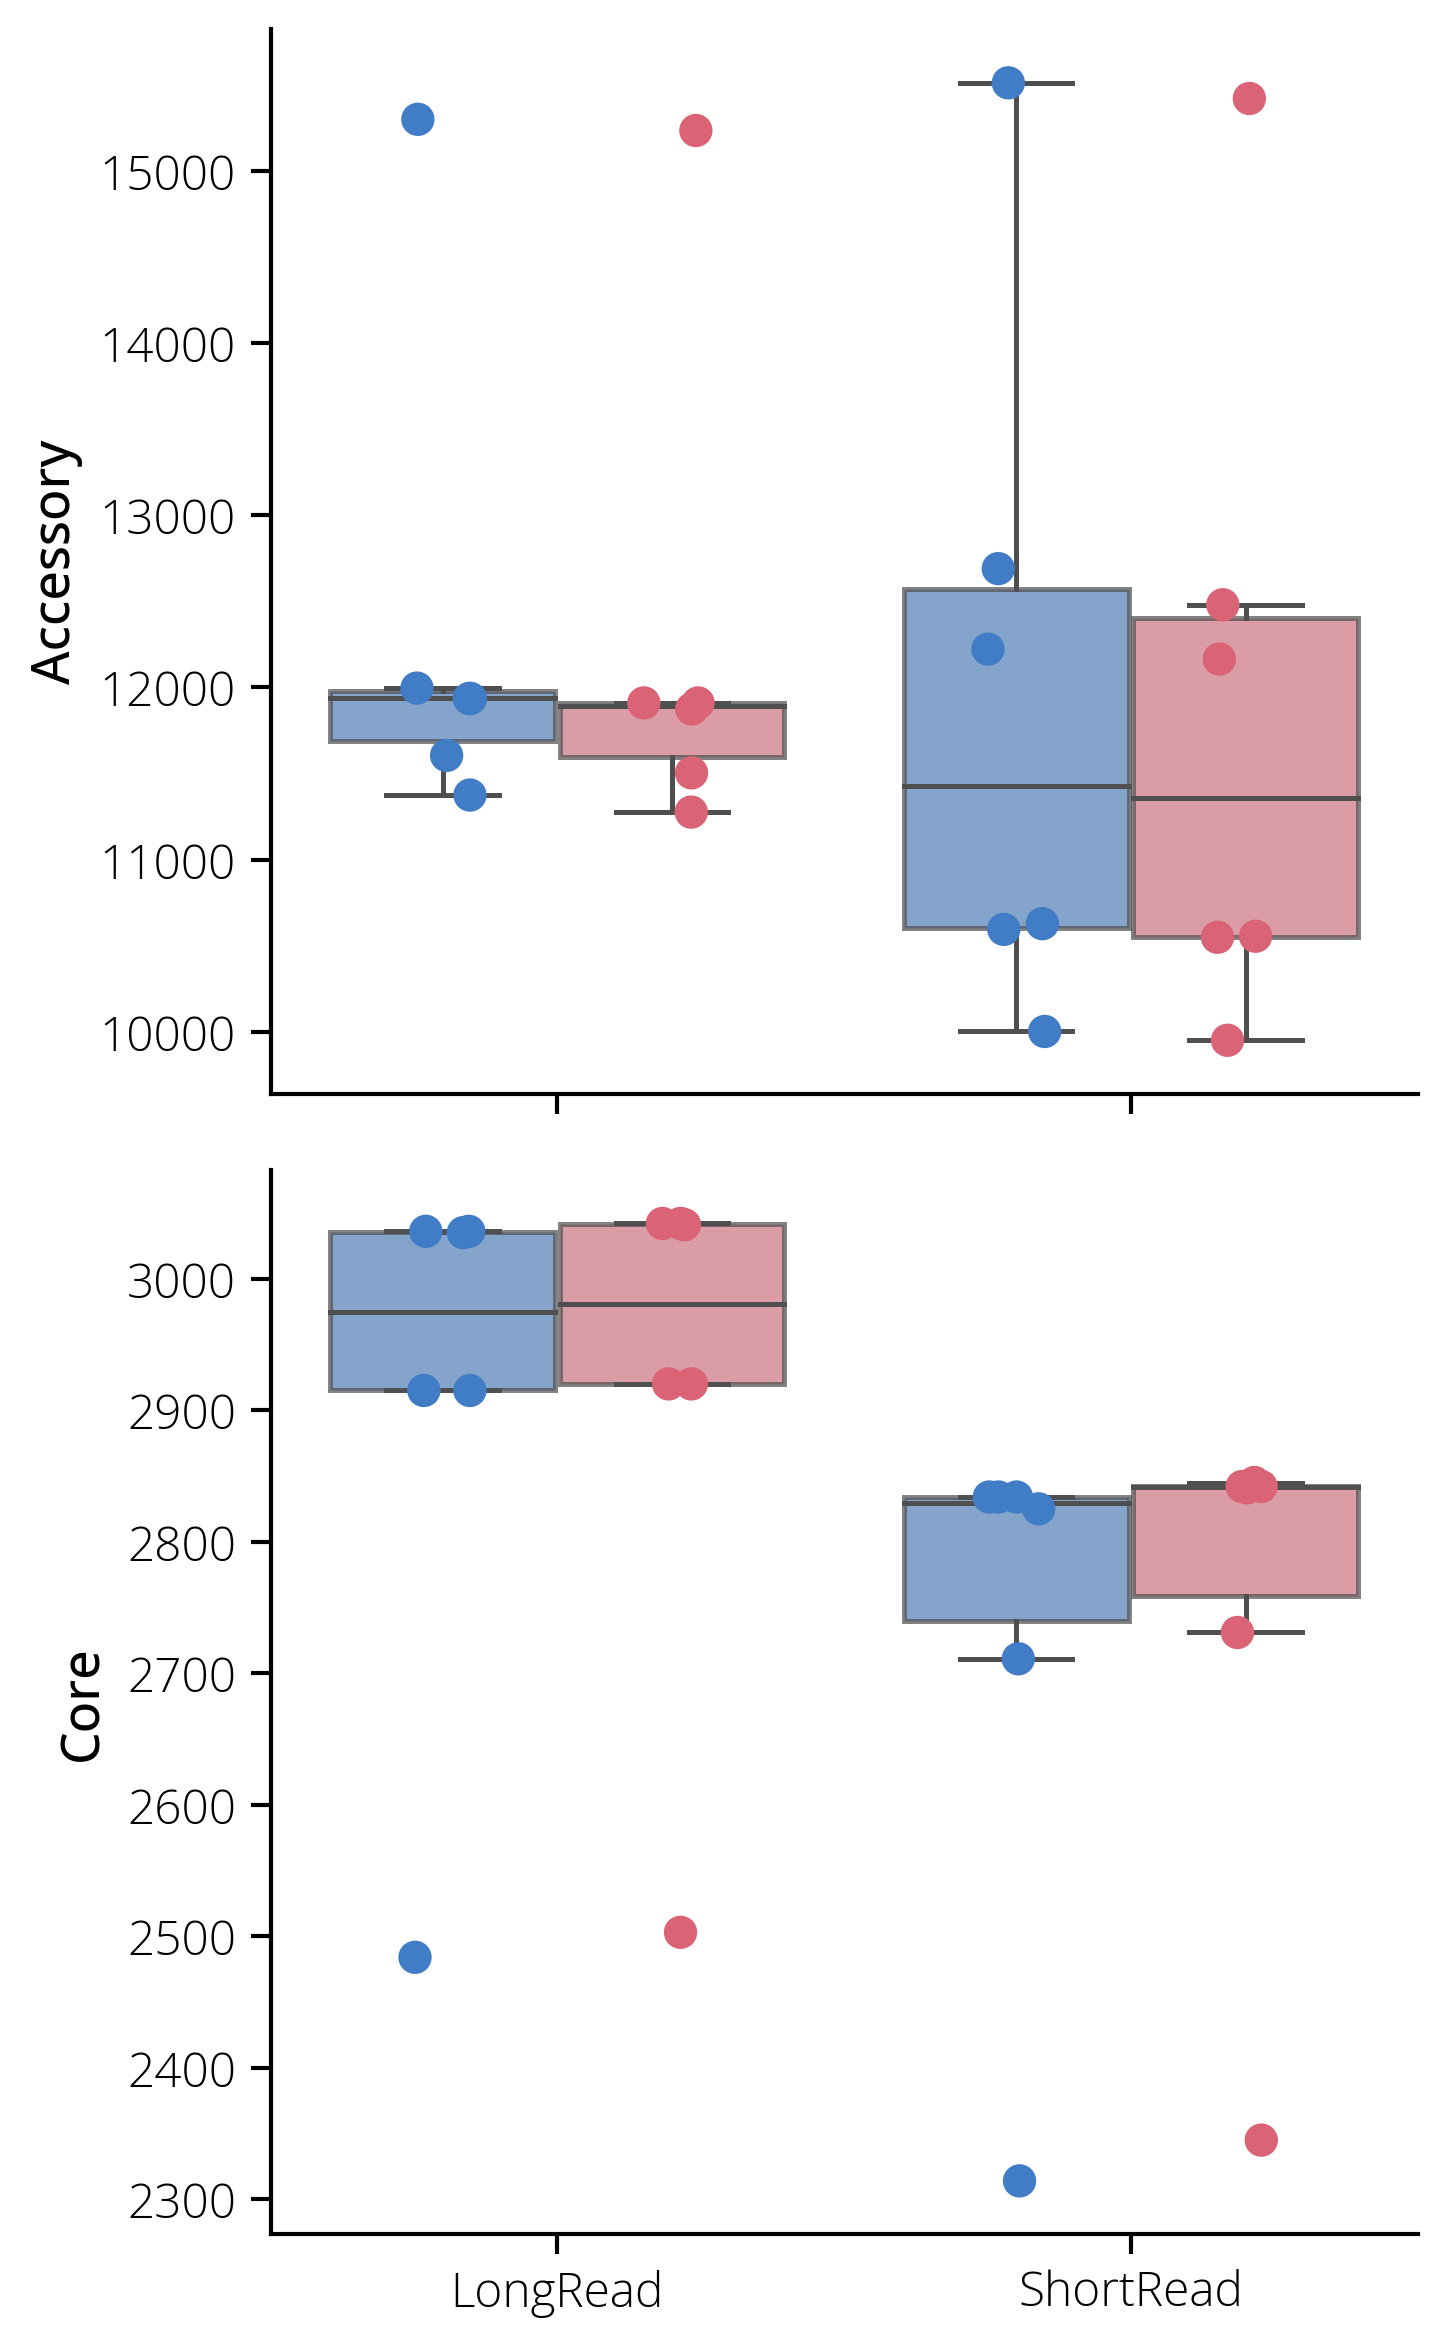

In [83]:
#sns.set_context("poster", font_scale=1)
#sns.set_context("paper", font_scale=2)
sns.set_context("paper", font_scale=1.3)

OG_patch = mpatches.Patch(color="#3F84E5", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#E85D75", label='PGQC-NRC Adjusted Estimate')


fig, axs = plt.subplots(2, 1, figsize= (5, 8), sharex=True, sharey=False)

sns.boxplot(x = "SeqType", y = "Accessory", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[0], 
             palette = ["#417CC6", "#DA6376"],
            boxprops=dict(alpha=0.7), fliersize = 0)

sns.stripplot(x = "SeqType", y = "Accessory", hue = "Approach",
              data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[0],   
              alpha=1, dodge = True, jitter = True,
              palette = ["#417CC6", "#DA6376"],
              edgecolor='gray', linewidth=0, size = 8)

sns.boxplot(x = "SeqType", y = "Core", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[1], 
             palette = ["#417CC6", "#DA6376"],
            boxprops=dict(alpha=0.7), fliersize = 0)

sns.stripplot(x = "SeqType", y = "Core", hue = "Approach",
              data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[1],   
              alpha=1, dodge = True, jitter = True,
              palette = ["#417CC6", "#DA6376"],
              edgecolor='gray', linewidth=0, size = 8)

# Add a legend outside of the plot to the right

#axs[0].set_ylim(0, 1750)
axs[0].set_xlabel("")
axs[1].set_xlabel("")

#axs[0].legend(handles=[OG_patch, NRA_patch],
#              bbox_to_anchor=(1.35, 1), fontsize= 10) 
axs[0].get_legend().remove()
axs[1].get_legend().remove()

#axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()

plt.savefig("Results5_Plots/6.Ecoli50CI.PG.BeforeAndAfter.NRCAdjust.Boxplot.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results5_Plots/6.Ecoli50CI.PG.BeforeAndAfter.NRCAdjust.Boxplot.svg", bbox_inches="tight")

plt.show()

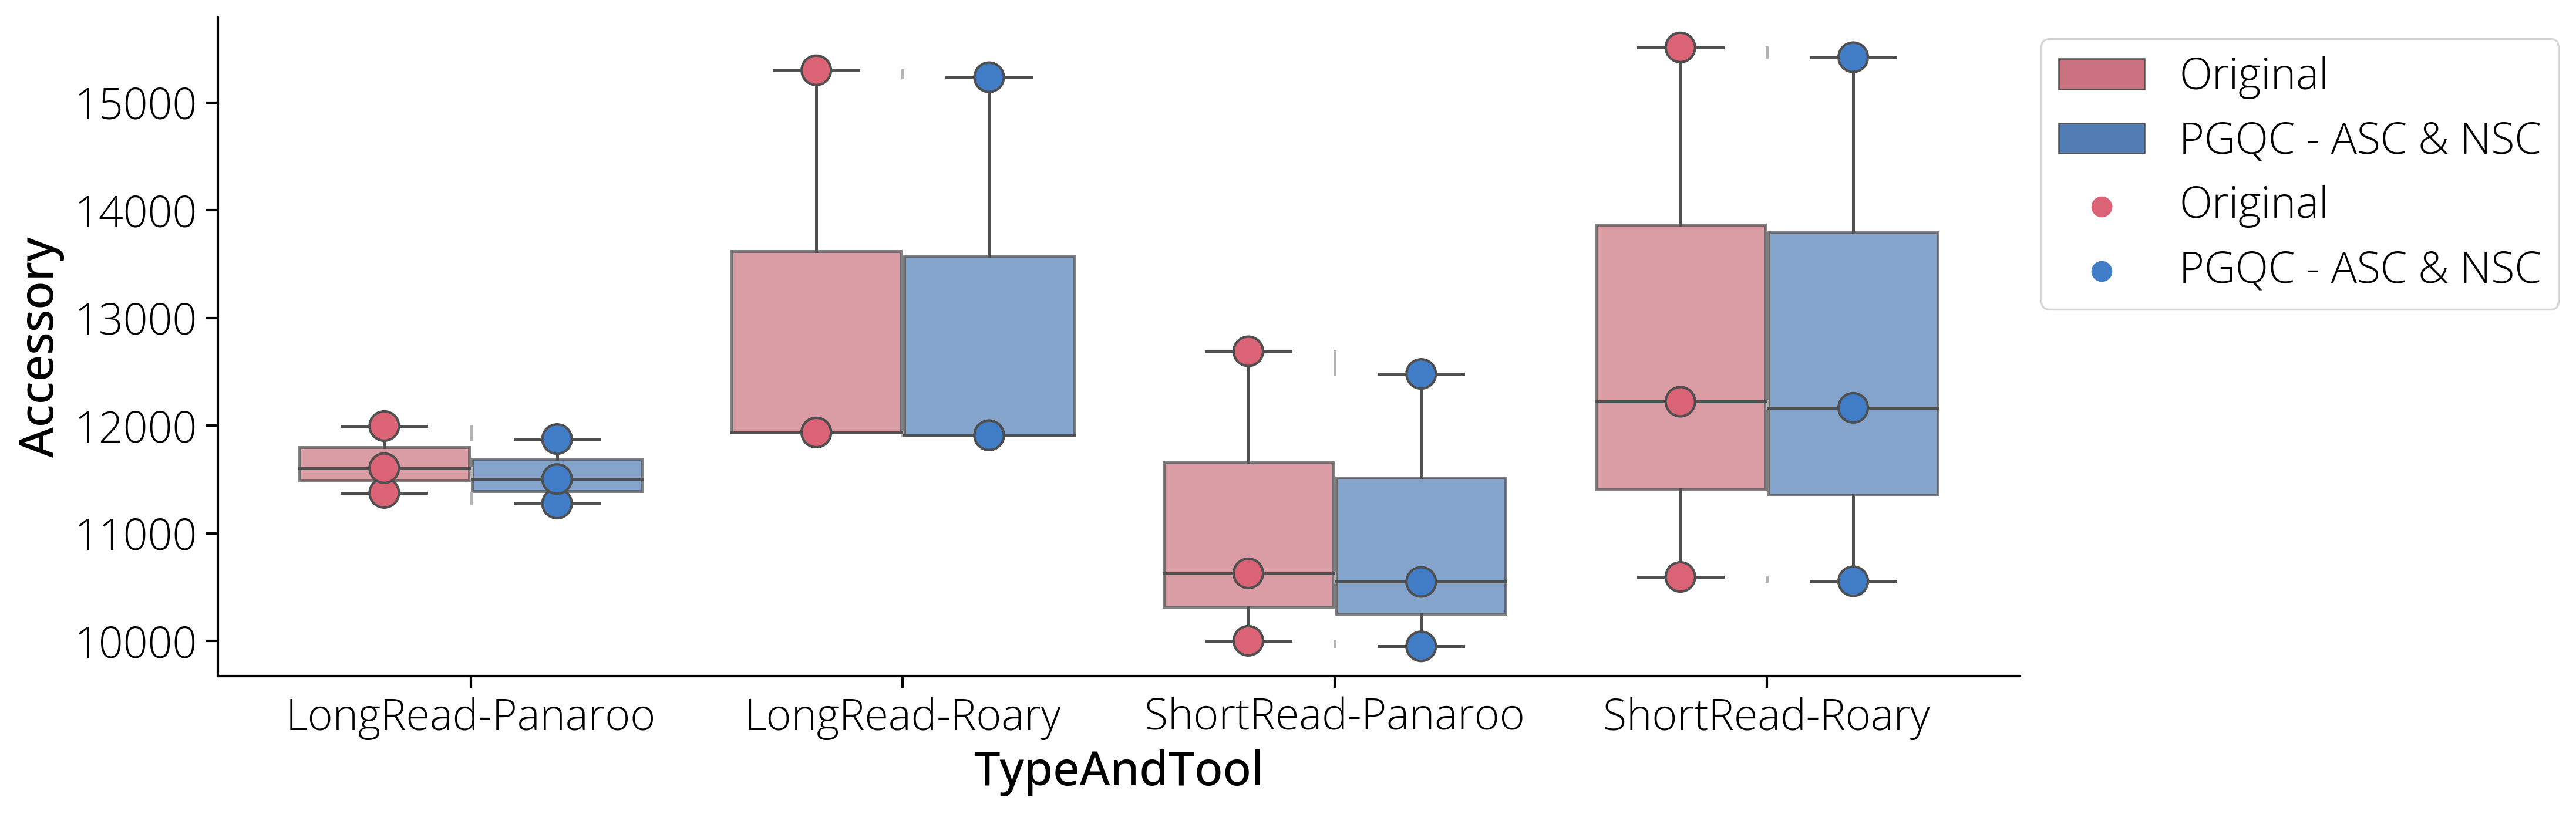

In [84]:
#sns.set_context("paper", font_scale=1.5)
sns.set_context("paper", font_scale=2)

fig, axs = plt.subplots(1, 1, figsize= (15, 5))

sns.boxplot(x = "TypeAndTool", y = "Accessory", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, 
             palette = ["#DA6376", "#417CC6"],
            boxprops=dict(alpha=0.7), fliersize = 0)

sns.stripplot(x = "TypeAndTool", y = "Accessory", hue = "Approach",
              data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs,   
              alpha=1, dodge = True, jitter = False,
              palette = ["#DA6376", "#417CC6"],
              edgecolor='gray', linewidth=1, size = 12)


sns.lineplot(
    data=PG_Summ_ASC_ASCwiNSC_DF, x="TypeAndTool", y="Accessory", units="TypeAndParam",
    color=".7", estimator=None
)


# Add a legend outside of the plot to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

#axs.set_ylim(0, 1750)
#axs.set_xlabel("")
#axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()

plt.show()

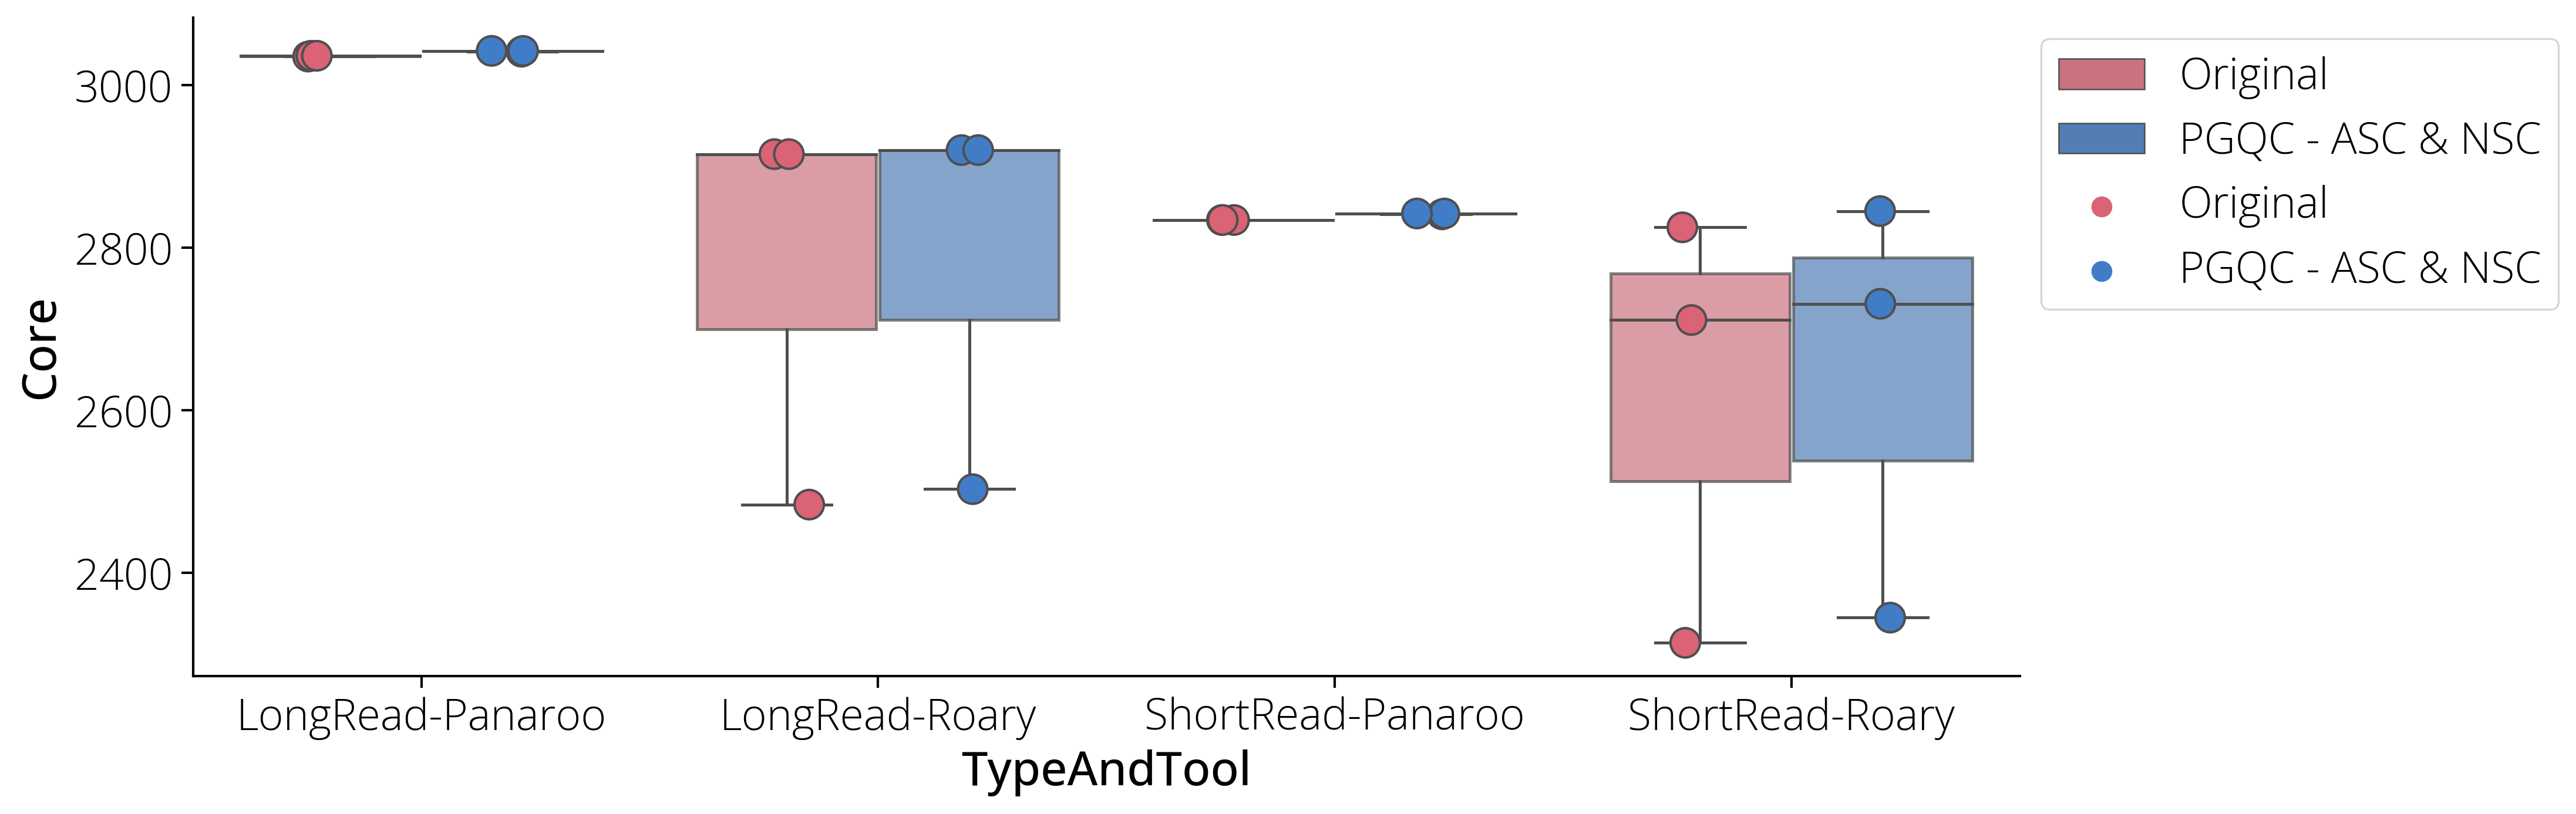

In [85]:
#sns.set_context("paper", font_scale=1.5)
sns.set_context("paper", font_scale=2)

fig, axs = plt.subplots(1, 1, figsize= (15, 5))

sns.boxplot(x = "TypeAndTool", y = "Core", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, 
             palette = ["#DA6376", "#417CC6"],
            boxprops=dict(alpha=0.7), fliersize = 0)

sns.stripplot(x = "TypeAndTool", y = "Core", hue = "Approach",
              data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs,   
              alpha=1, dodge = True,
              palette = ["#DA6376", "#417CC6"],
              edgecolor='gray', linewidth=1, size = 12)

# Add a legend outside of the plot to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

#axs.set_ylim(0, 1750)
#axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()

plt.show()

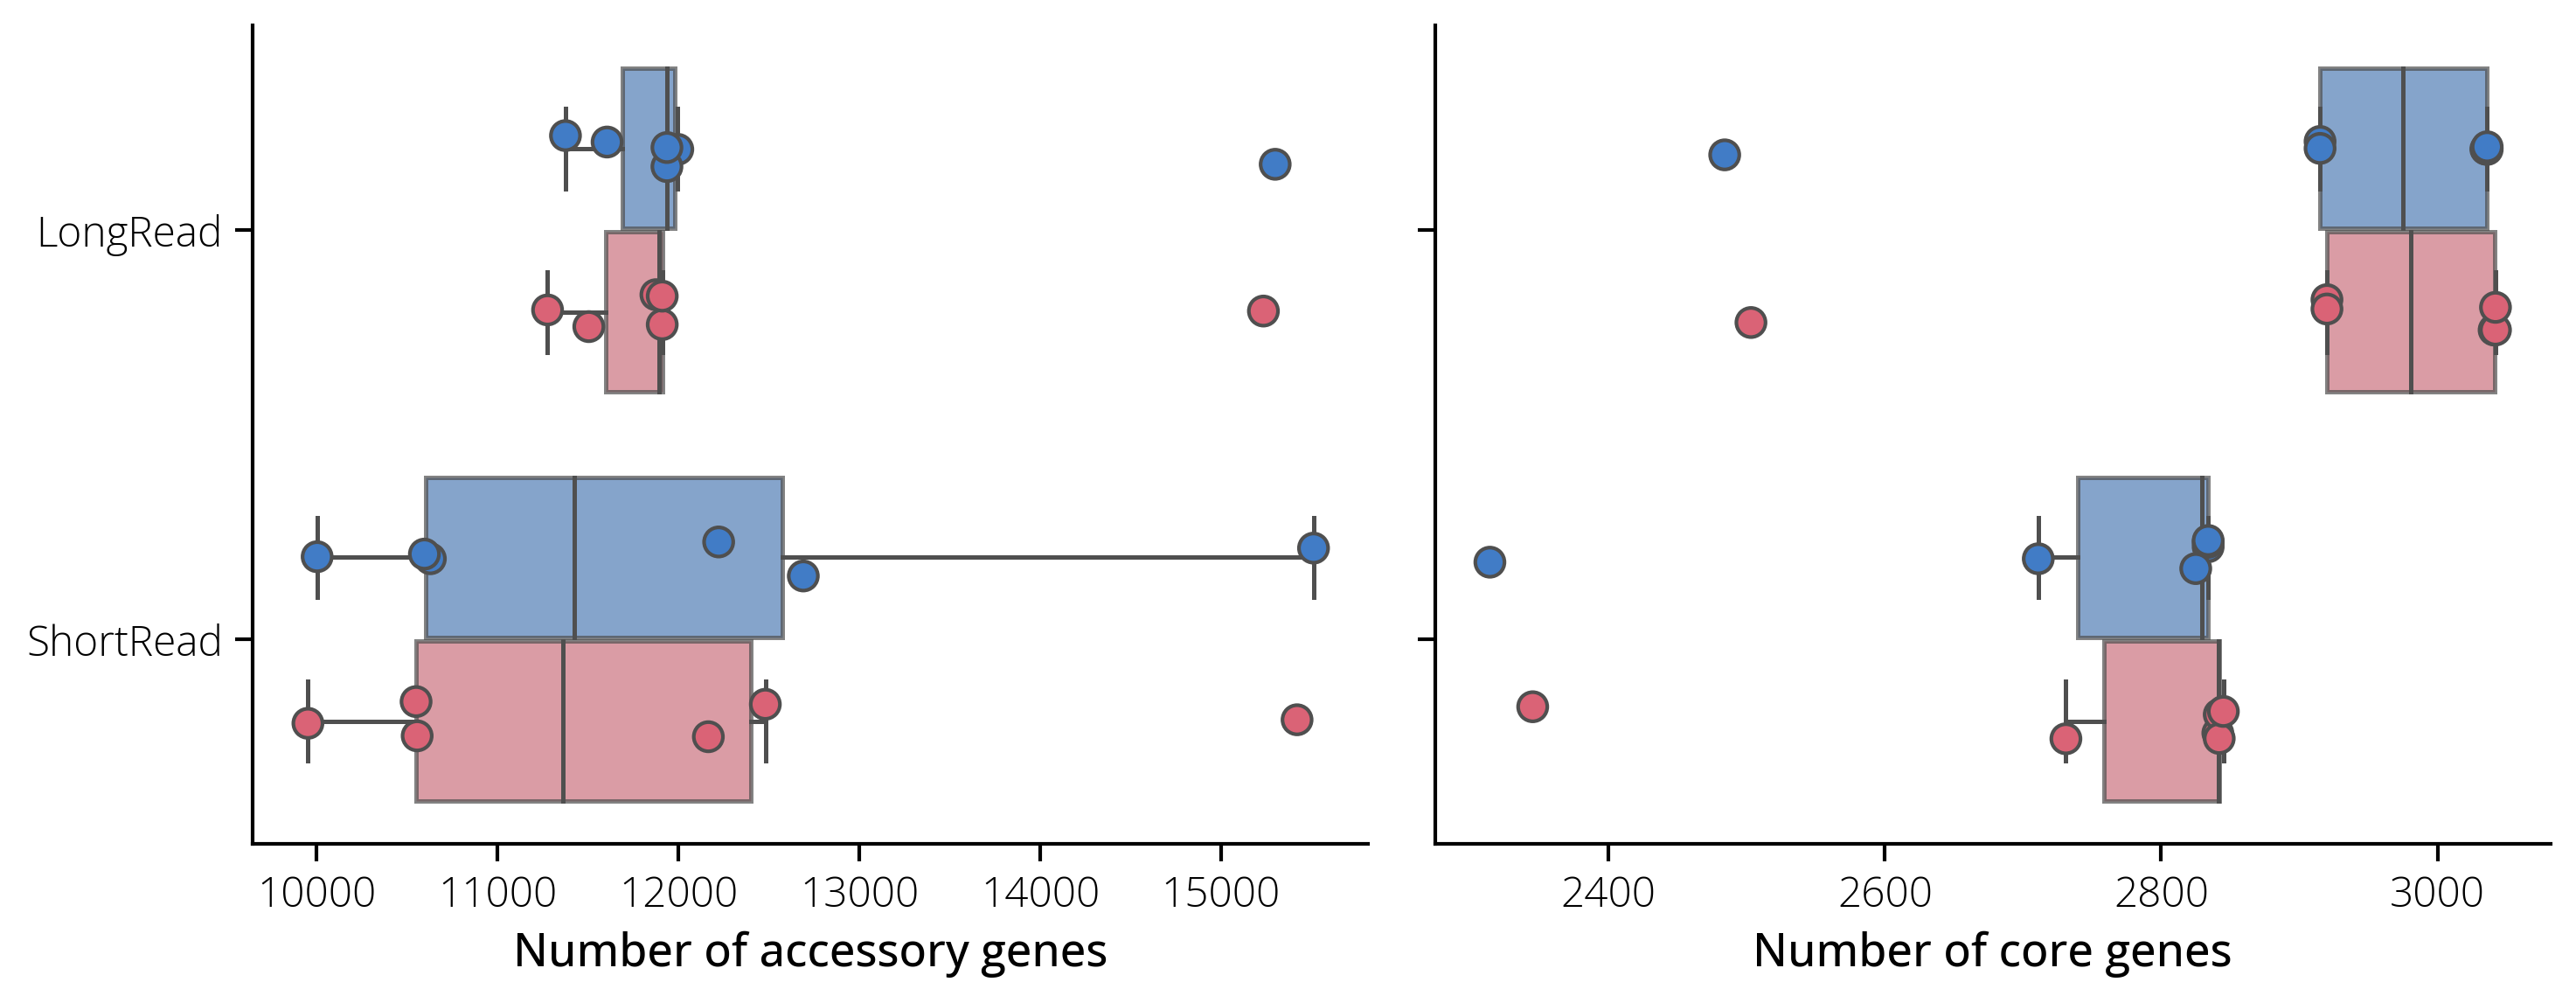

In [86]:
#sns.set_context("poster", font_scale=1)
#sns.set_context("paper", font_scale=2)
sns.set_context("paper", font_scale=1.3)

OG_patch = mpatches.Patch(color="#3F84E5", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#E85D75", label='PGQC-NRC Adjusted Estimate')


fig, axs = plt.subplots(1, 2, figsize= (10, 4), sharex=False, sharey=True)

sns.boxplot(y = "SeqType", x = "Accessory", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[0], 
             palette = ["#417CC6", "#DA6376"],
            boxprops=dict(alpha=0.7), fliersize = 0)

sns.stripplot(y = "SeqType", x = "Accessory", hue = "Approach",
              data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[0],   
              alpha=1, dodge = True, jitter = True,
              palette = ["#417CC6", "#DA6376"],
              edgecolor='gray', linewidth=1, size = 8)

sns.boxplot(y = "SeqType", x = "Core", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[1], 
             palette = ["#417CC6", "#DA6376"],
            boxprops=dict(alpha=0.7), fliersize = 0)

sns.stripplot(y = "SeqType", x = "Core", hue = "Approach",
              data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs[1],   
              alpha=1, dodge = True, jitter = True,
              palette = ["#417CC6", "#DA6376"],
              edgecolor='gray', linewidth=1, size = 8)

# Add a legend outside of the plot to the right

#axs[0].set_ylim(0, 1750)
axs[0].set_xlabel("Number of accessory genes")
axs[1].set_xlabel("Number of core genes")
axs[0].set_ylabel("")
axs[1].set_ylabel("")

#axs[0].legend(handles=[OG_patch, NRA_patch],
#              bbox_to_anchor=(1.35, 1), fontsize= 10) 
axs[0].get_legend().remove()
axs[1].get_legend().remove()

#axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()

plt.show()

In [87]:
# sns.set_context("paper", font_scale=1.5)

# fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

# sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
#             data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# # Add a legend outside of the plot to the right
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# axs.set_xlabel("# of accessory genes", fontsize = 20)
# sns.despine()
# plt.show()

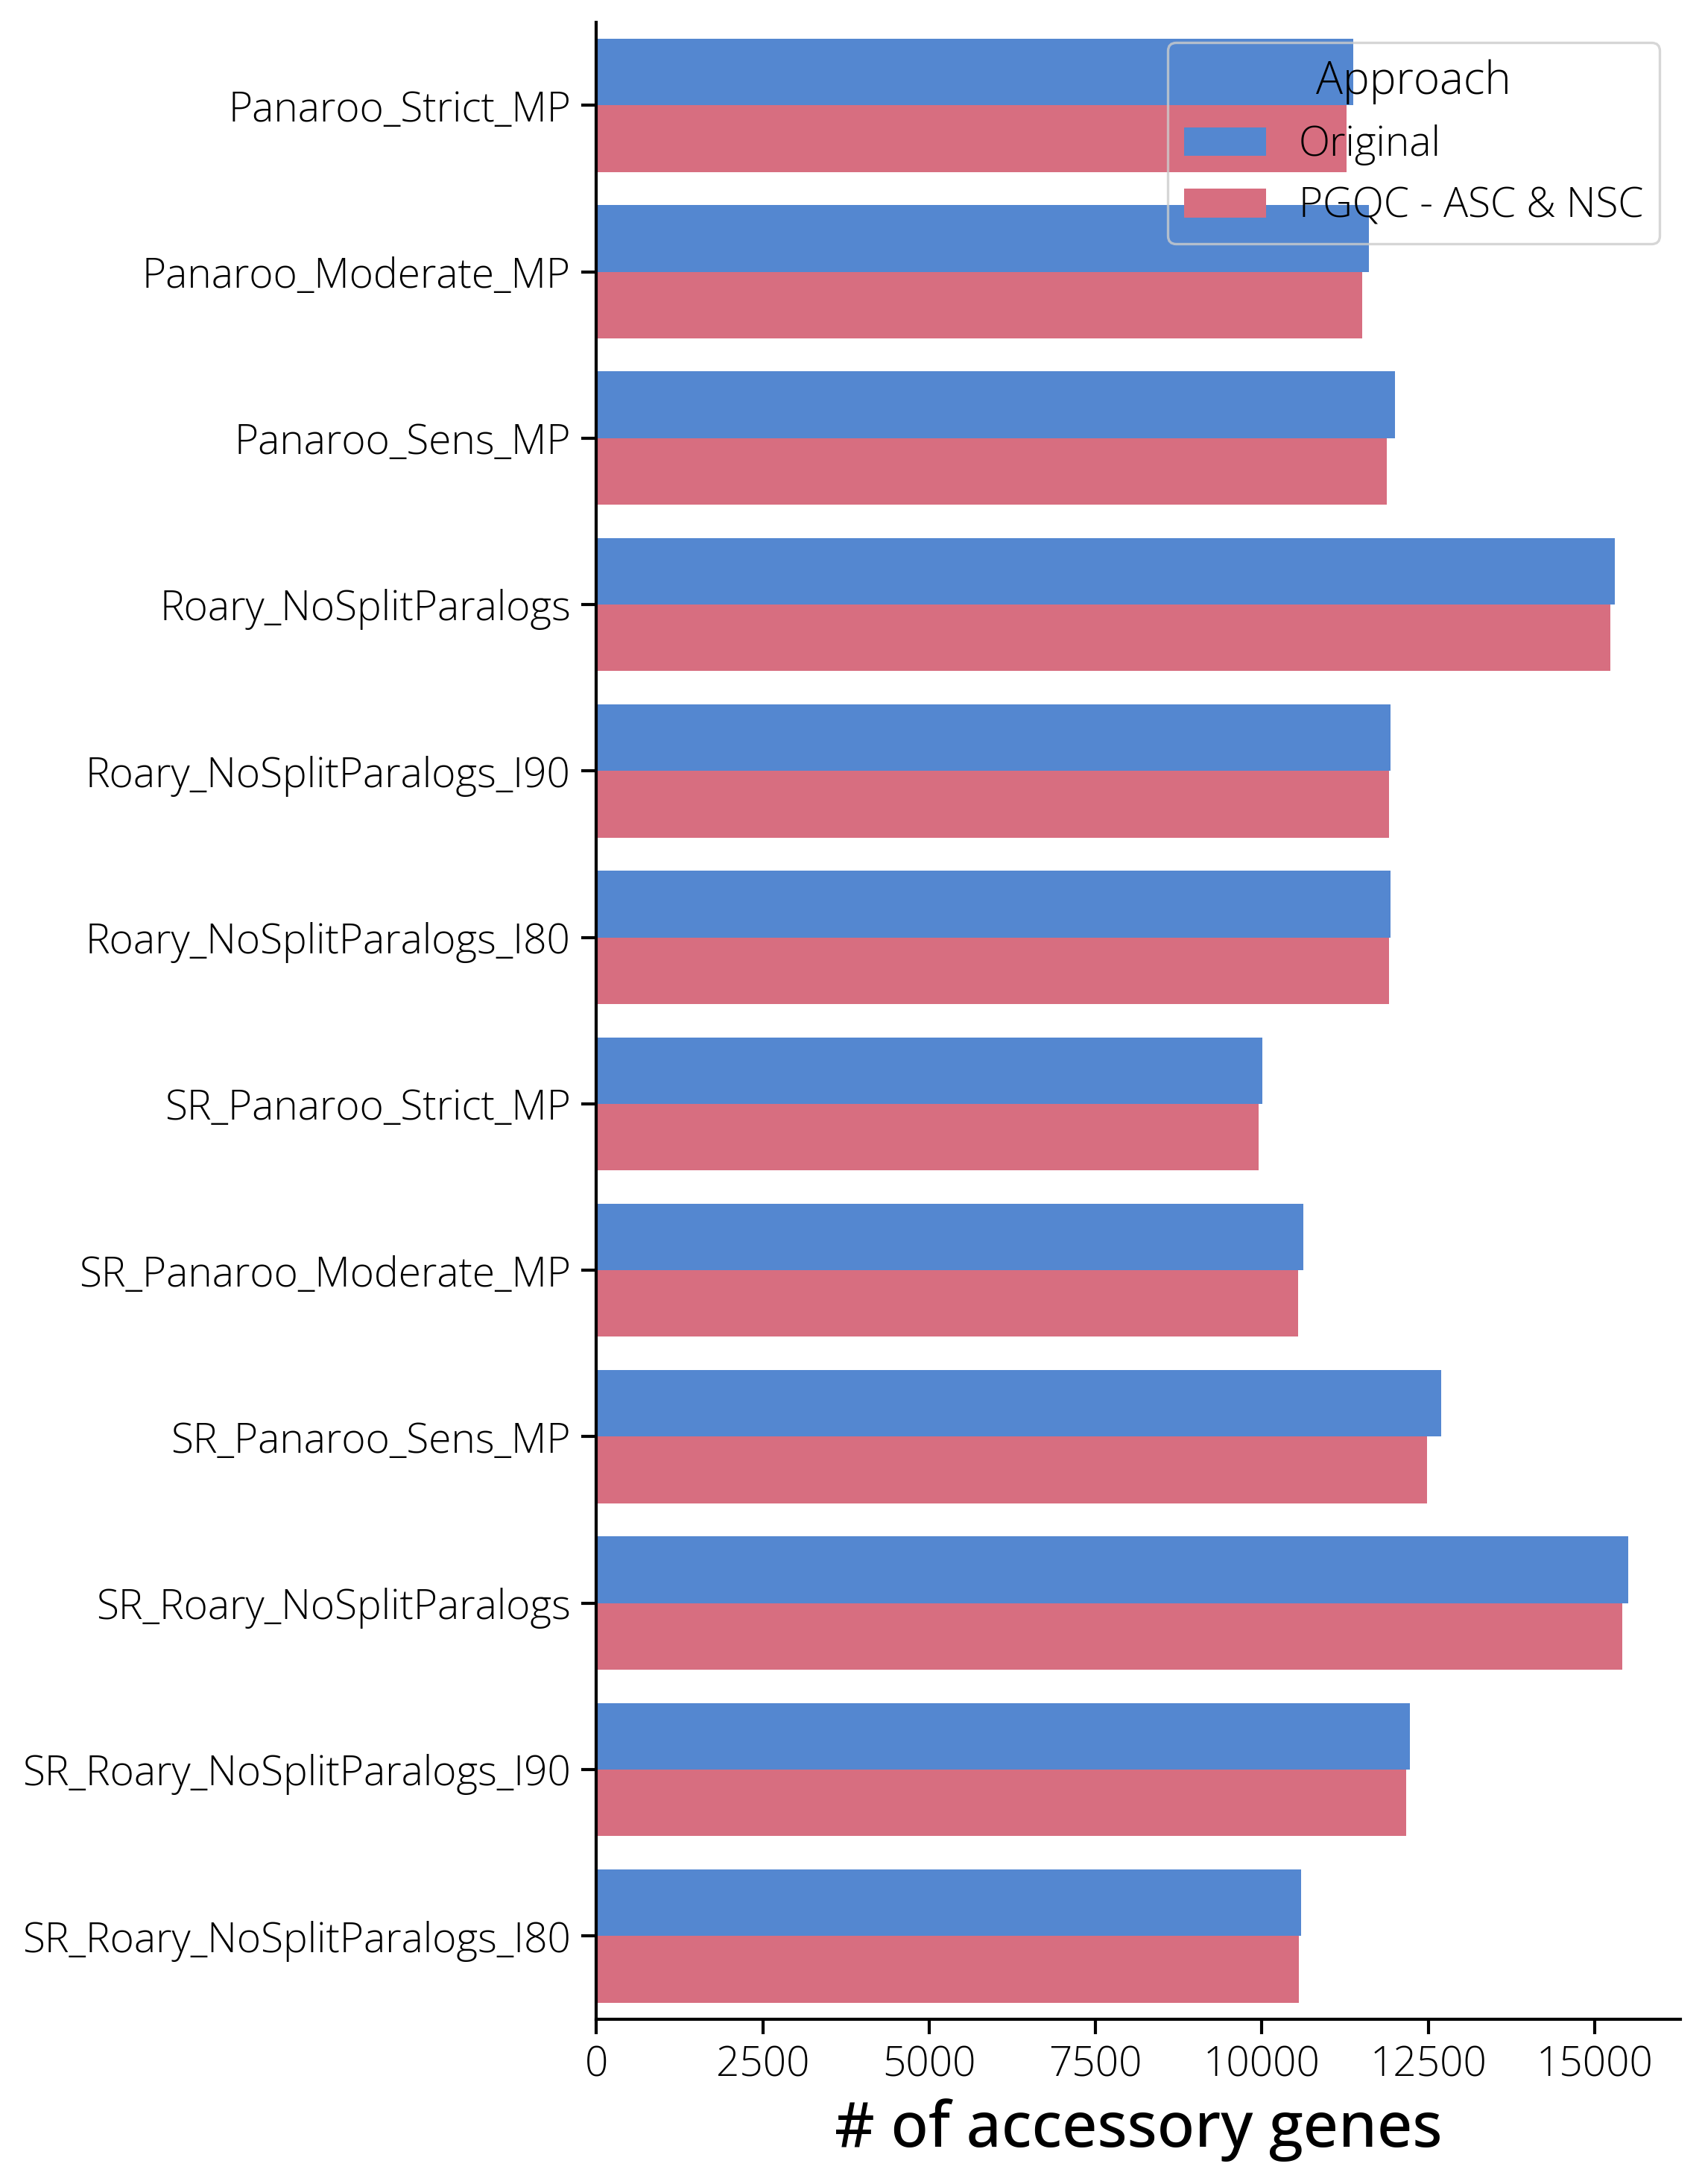

In [88]:
sns.set_context("paper", font_scale=1.5)

fig, axs = plt.subplots(1, 1, figsize= (8, 10), sharex=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# Add a legend outside of the plot to the right
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs.set_xlabel("# of accessory genes", fontsize = 20)
plt.ylabel("")
sns.despine()
plt.show()

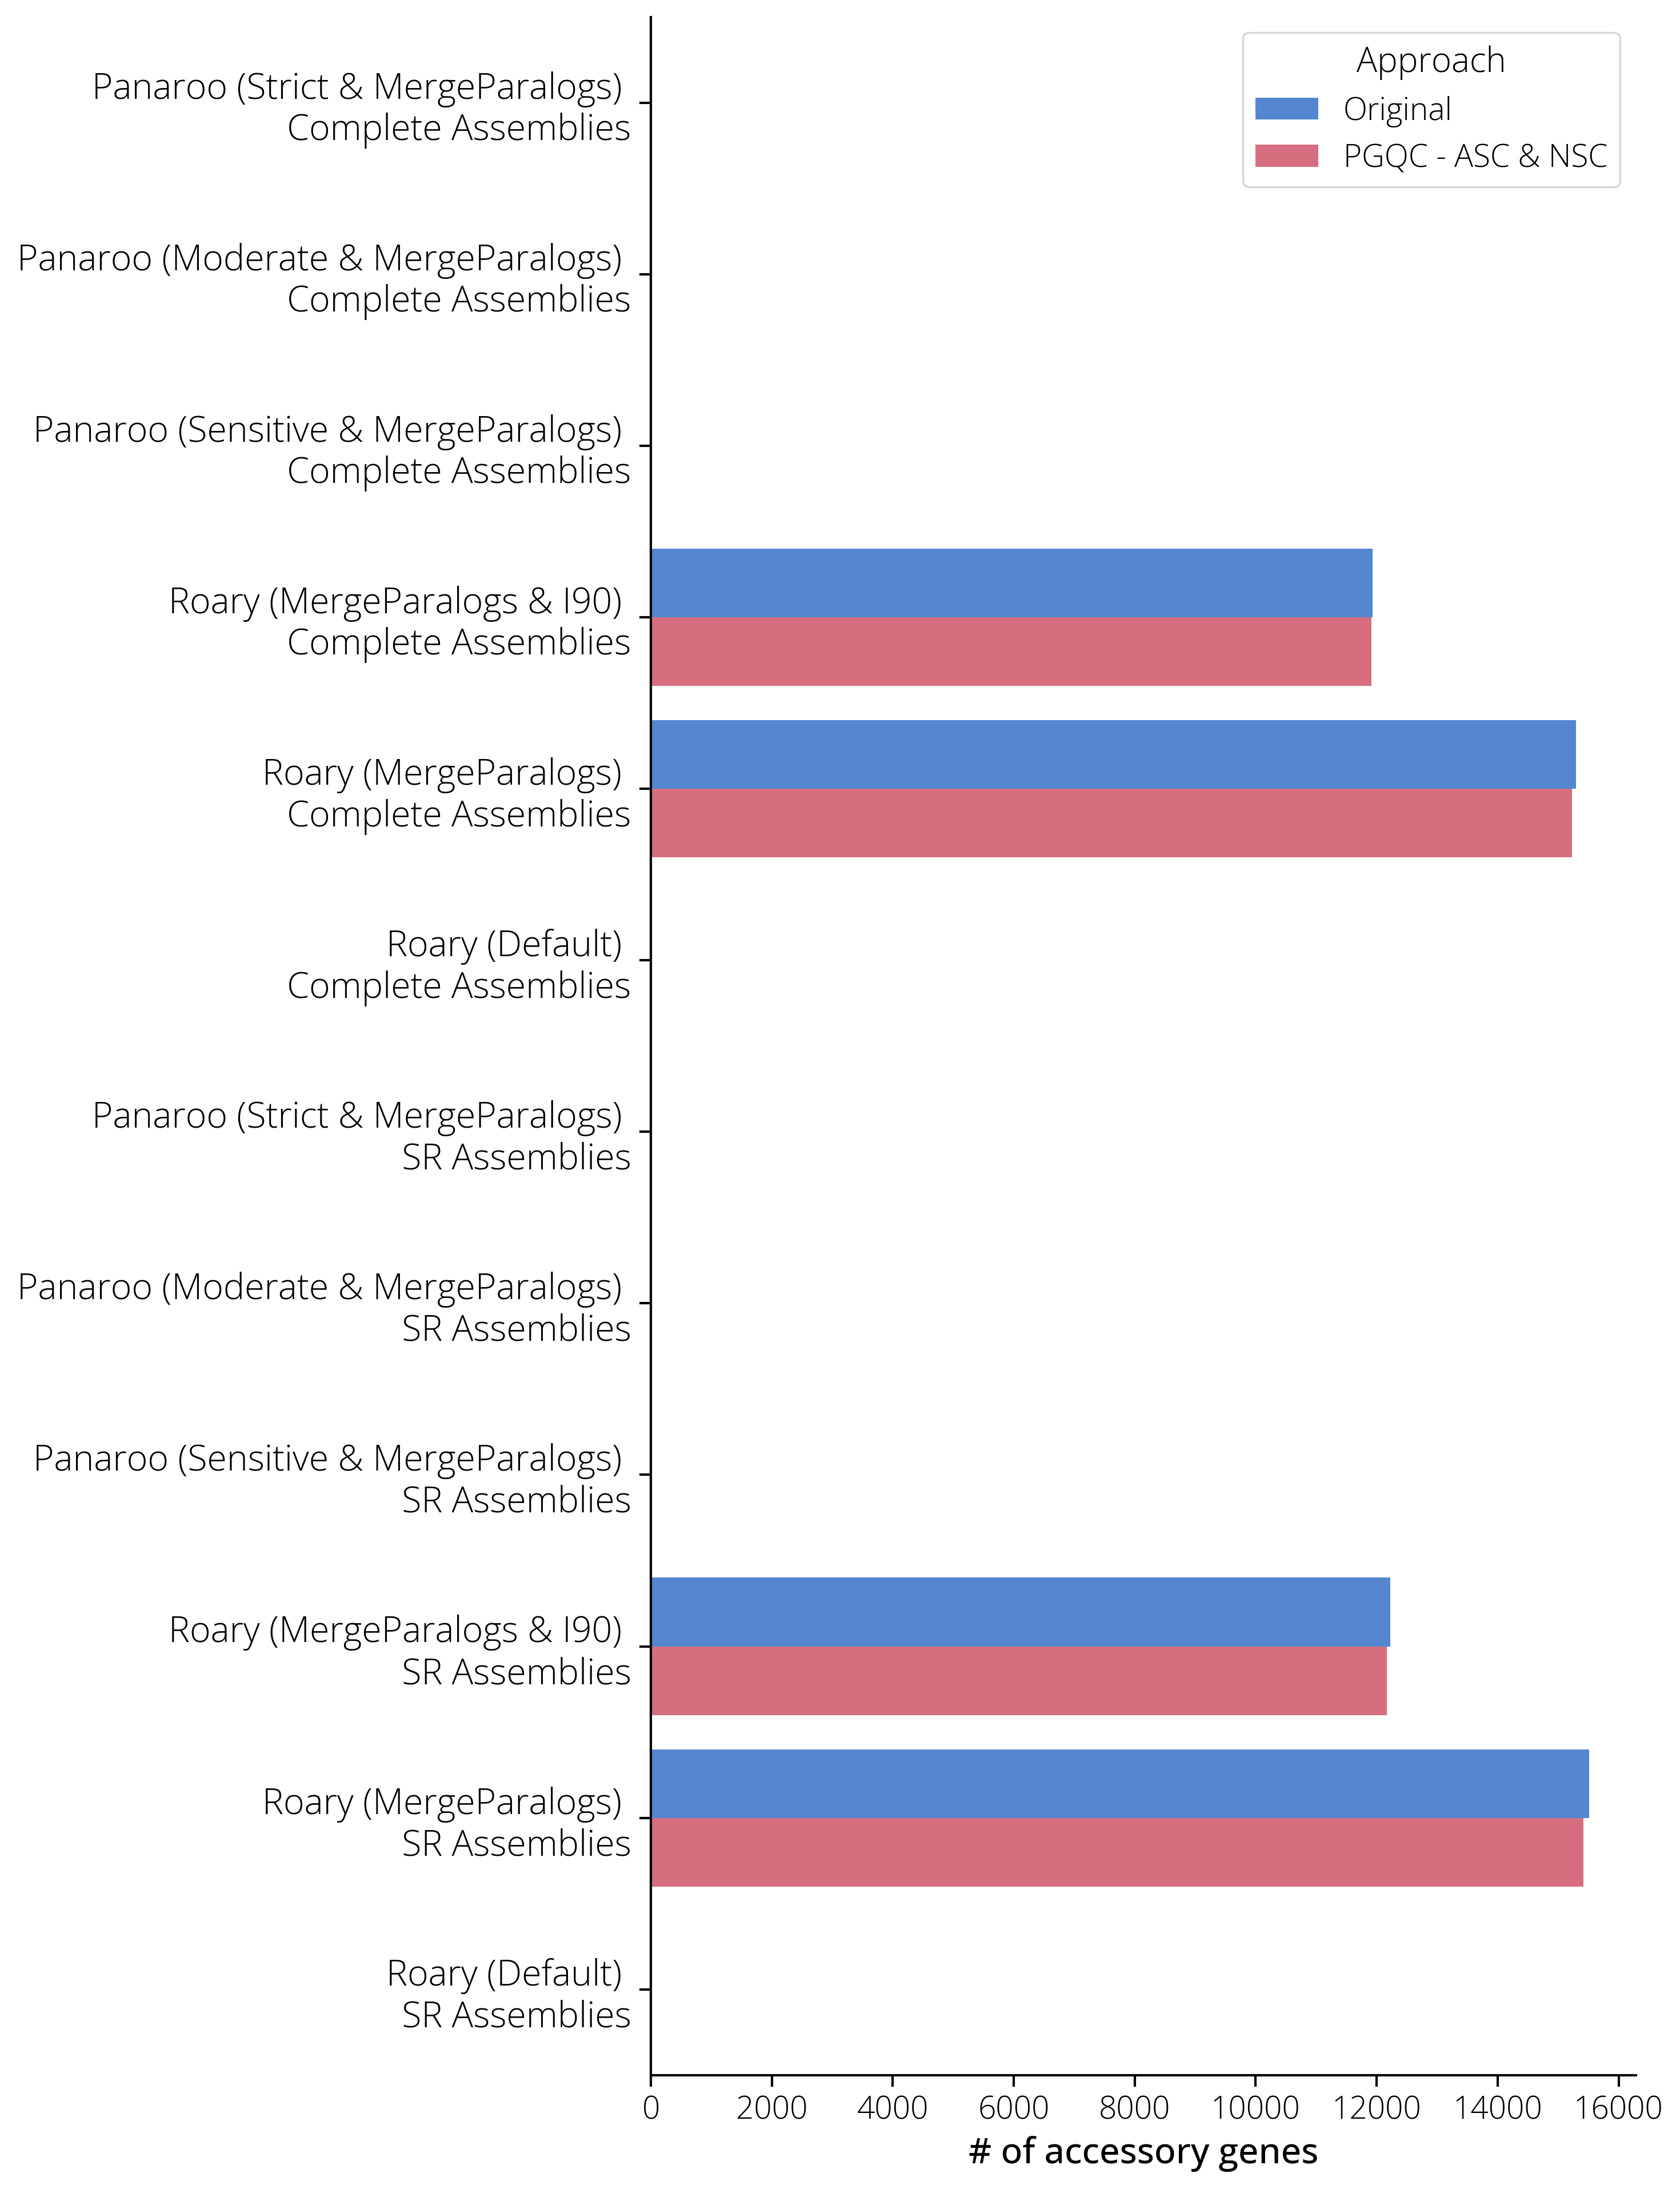

In [89]:
sns.set_context("paper", font_scale=1.5)


orderToPlot_X = ['Panaroo_Strict_MergeParalogs',
                 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sens_MergeParalogs',
                 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',
                 'Roary_Default', 
                 'SR_Panaroo_Strict_MergeParalogs',
                 'SR_Panaroo_Moderate_MergeParalogs',
                 'SR_Panaroo_Sens_MergeParalogs',
                 'SR_Roary_NoSplitParalogs_I90',
                 'SR_Roary_NoSplitParalogs',
                 'SR_Roary_Default', ]

Plot_TickLabels = ['Panaroo (Strict & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n Complete Assemblies',
                   'Roary (MergeParalogs & I90) \n Complete Assemblies',
                   'Roary (MergeParalogs) \n Complete Assemblies', 
                   'Roary (Default) \n Complete Assemblies',
                   'Panaroo (Strict & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n SR Assemblies',
                   'Roary (MergeParalogs & I90) \n SR Assemblies',
                   'Roary (MergeParalogs) \n SR Assemblies', 
                   'Roary (Default) \n SR Assemblies',
                  ]


fig, axs = plt.subplots(1, 1, figsize= (10, 13), sharex=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, 
            order = orderToPlot_X, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})


# Add a legend outside of the plot to the right
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs.set_xlabel("# of accessory genes", fontsize = 15)
plt.ylabel("")
sns.despine()
plt.show()

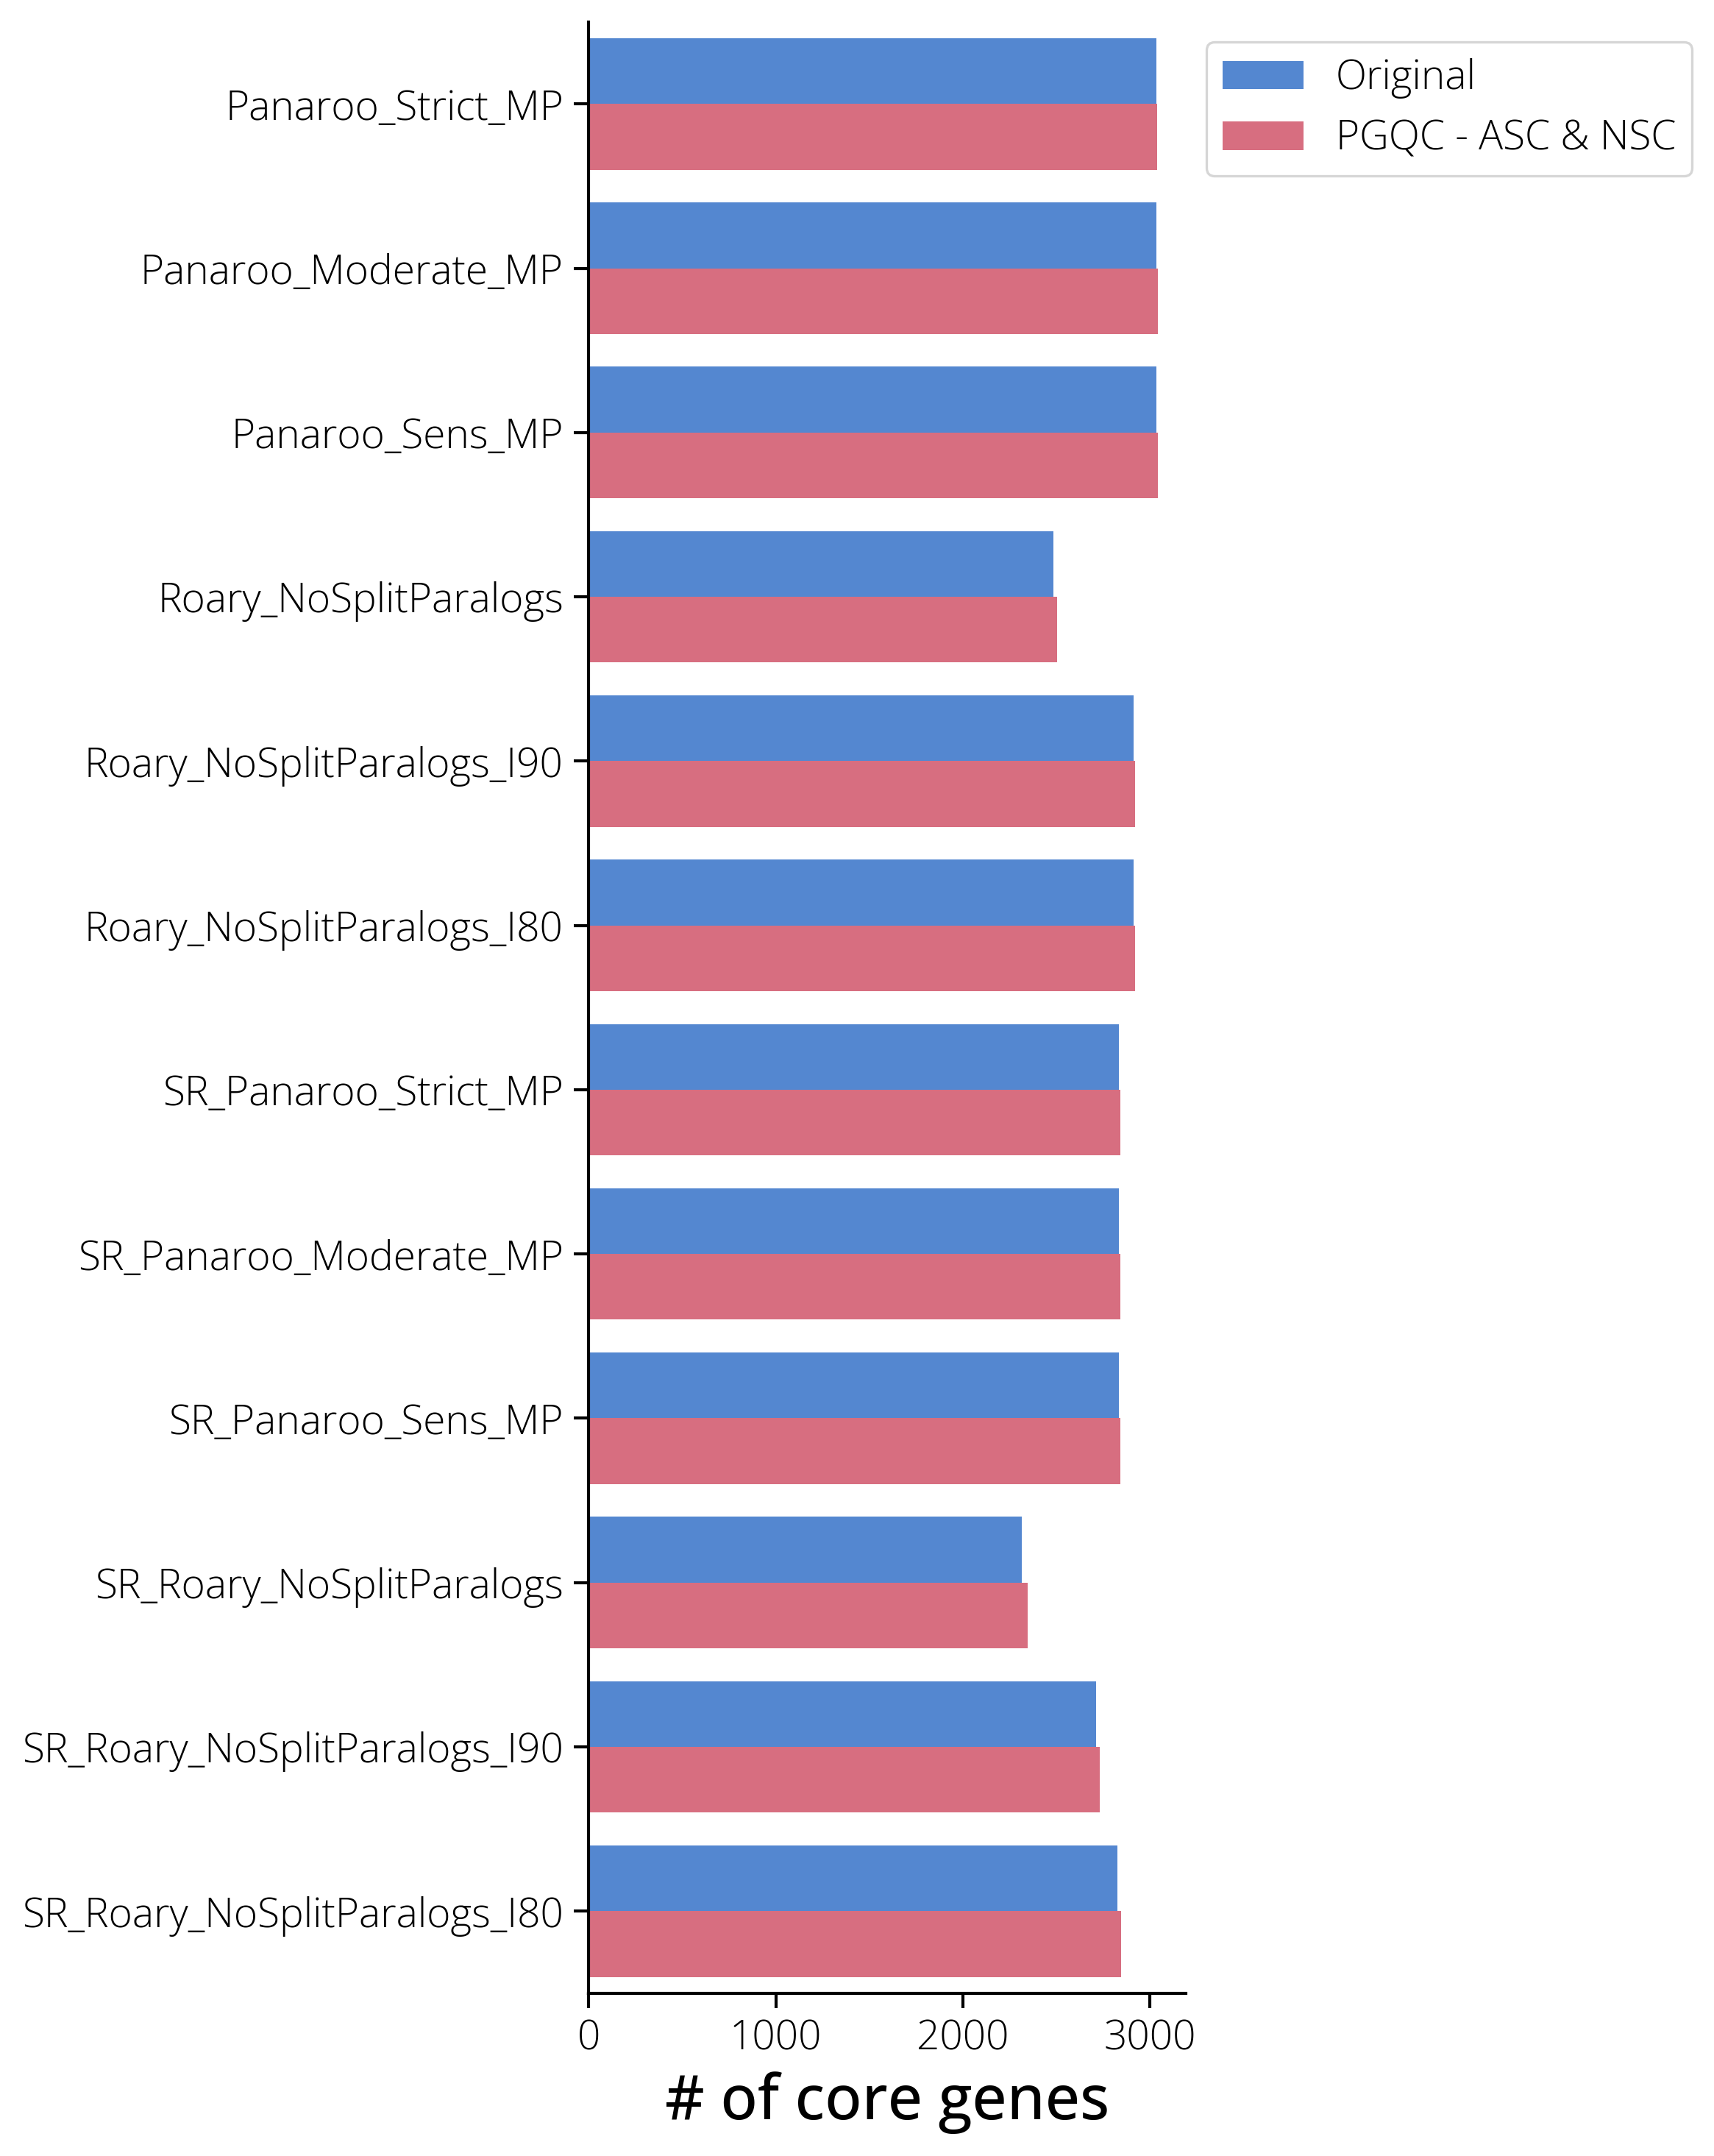

In [90]:
sns.set_context("paper", font_scale=1.5)

fig, axs = plt.subplots(1, 1, figsize= (8, 10), sharex=True)

sns.barplot(y = "Param", x = "Core", hue = "Approach",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# Add a legend outside of the plot to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs.set_xlabel("# of core genes", fontsize = 20)
plt.ylabel("")
sns.despine()
plt.show()

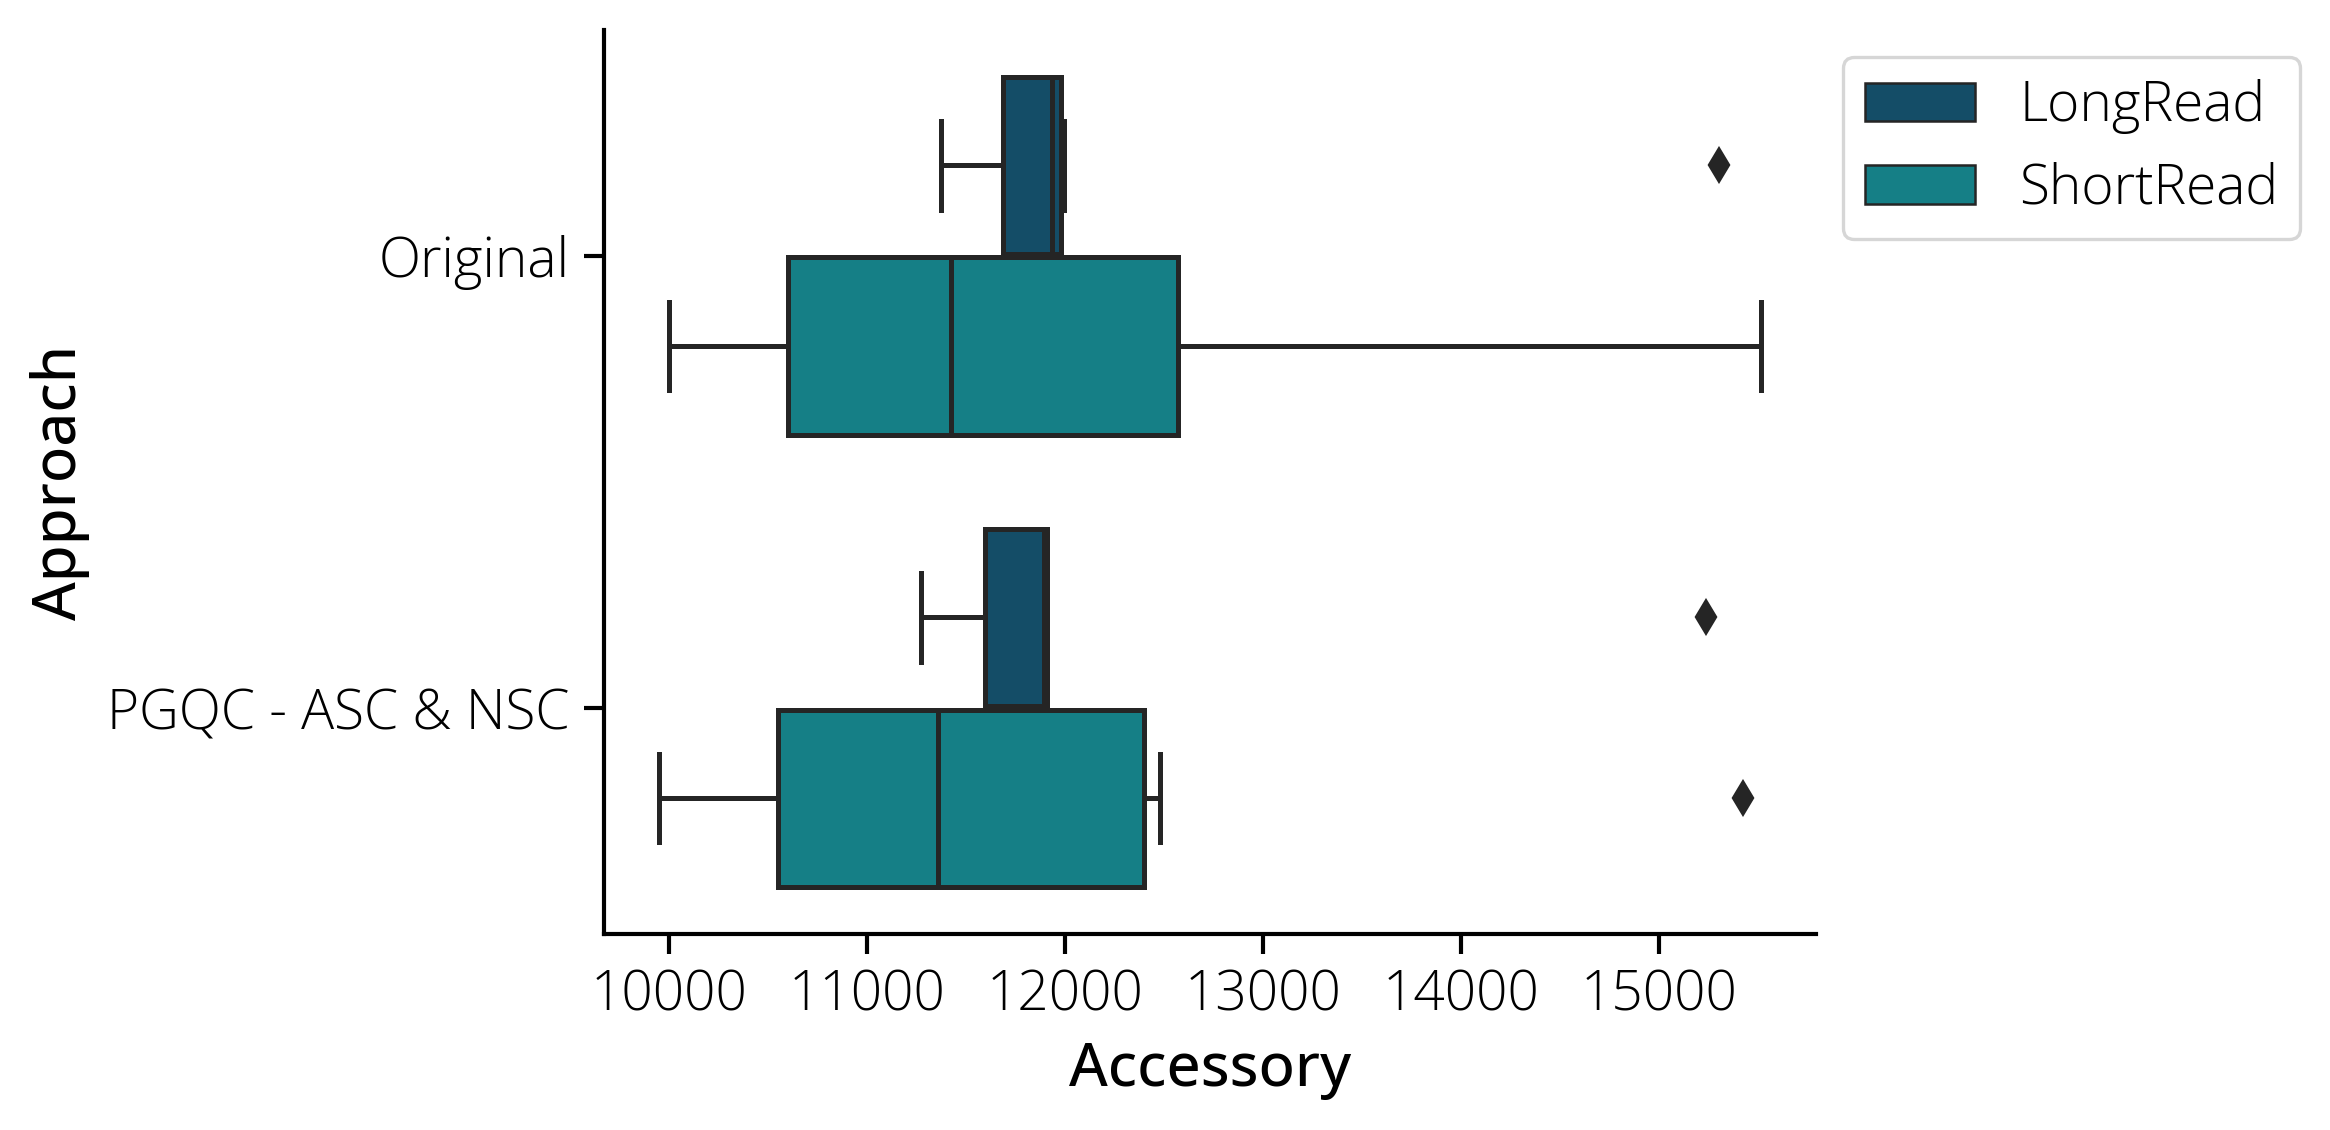

In [91]:
sns.set_context("paper", font_scale=1.5)

fig, axs = plt.subplots(1, 1, figsize= (8, 4))

sns.boxplot(y = "Approach", x = "Accessory", hue = "SeqType",
            data = PG_Summ_ASC_ASCwiNSC_DF, ax = axs)

# Add a legend outside of the plot to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

#axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()
plt.show()


In [93]:
!mkdir ./Tables
PG_Summ_ASC_ASCwiNSC_DF.to_csv("./Tables/Ecoli50CI.PG.SummStats.ASC.ASCwiNSC.tsv", sep = "\t", index = False)   

mkdir: cannot create directory ‘./Tables’: File exists


In [97]:
PG_Summ_ASC_ASCwiNSC_DF.query("Approach != 'PGQC - ASC' ") 

SeqType PangenomeTool                         Param          Approach  \
0    LongRead       Panaroo             Panaroo_Strict_MP          Original   
1    LongRead       Panaroo             Panaroo_Strict_MP  PGQC - ASC & NSC   
2    LongRead       Panaroo           Panaroo_Moderate_MP          Original   
3    LongRead       Panaroo           Panaroo_Moderate_MP  PGQC - ASC & NSC   
4    LongRead       Panaroo               Panaroo_Sens_MP          Original   
5    LongRead       Panaroo               Panaroo_Sens_MP  PGQC - ASC & NSC   
6    LongRead         Roary         Roary_NoSplitParalogs          Original   
7    LongRead         Roary         Roary_NoSplitParalogs  PGQC - ASC & NSC   
8    LongRead         Roary     Roary_NoSplitParalogs_I90          Original   
9    LongRead         Roary     Roary_NoSplitParalogs_I90  PGQC - ASC & NSC   
10   LongRead         Roary     Roary_NoSplitParalogs_I80          Original   
11   LongRead         Roary     Roary_NoSplitParalogs_I80  PGQC - ASC & NSC   
12  ShortRead       Panaroo          SR_Panaroo_Strict_MP          Original   
13  ShortRead       Panaroo          SR_Panaroo_Strict_MP  PGQC - ASC & NSC   
14  ShortRead       Panaroo        SR_Panaroo_Moderate_MP          Original   
15  ShortRead       Panaroo        SR_Panaroo_Moderate_MP  PGQC - ASC & NSC   
16  ShortRead       Panaroo            SR_Panaroo_Sens_MP          Original   
17  ShortRead       Panaroo            SR_Panaroo_Sens_MP  PGQC - ASC & NSC   
18  ShortRead         Roary      SR_Roary_NoSplitParalogs          Original   
19  ShortRead         Roary      SR_Roary_NoSplitParalogs  PGQC - ASC & NSC   
20  ShortRead         Roary  SR_Roary_NoSplitParalogs_I90          Original   
21  ShortRead         Roary  SR_Roary_NoSplitParalogs_I90  PGQC - ASC & NSC   
22  ShortRead         Roary  SR_Roary_NoSplitParalogs_I80          Original   
23  ShortRead         Roary  SR_Roary_NoSplitParalogs_I80  PGQC - ASC & NSC   

    Total  Core  Accessory        TypeAndTool  \
0   14410  3035      11375   LongRead-Panaroo   
1   14317  3041      11276   LongRead-Panaroo   
2   14641  3036      11605   LongRead-Panaroo   
3   14546  3042      11504   LongRead-Panaroo   
4   15032  3036      11996   LongRead-Panaroo   
5   14917  3042      11875   LongRead-Panaroo   
6   17783  2484      15299     LongRead-Roary   
7   17737  2503      15234     LongRead-Roary   
8   14851  2915      11936     LongRead-Roary   
9   14830  2920      11910     LongRead-Roary   
10  14851  2915      11936     LongRead-Roary   
11  14830  2920      11910     LongRead-Roary   
12  12836  2834      10002  ShortRead-Panaroo   
13  12792  2841       9951  ShortRead-Panaroo   
14  13462  2834      10628  ShortRead-Panaroo   
15  13391  2842      10549  ShortRead-Panaroo   
16  15524  2834      12690  ShortRead-Panaroo   
17  15322  2842      12480  ShortRead-Panaroo   
18  17825  2314      15511    ShortRead-Roary   
19  17765  2345      15420    ShortRead-Roary   
20  14933  2711      12222    ShortRead-Roary   
21  14896  2731      12165    ShortRead-Roary   
22  13420  2825      10595    ShortRead-Roary   
23  13400  2845      10555    ShortRead-Roary   

                              TypeAndParam  
0               LongRead-Panaroo_Strict_MP  
1               LongRead-Panaroo_Strict_MP  
2             LongRead-Panaroo_Moderate_MP  
3             LongRead-Panaroo_Moderate_MP  
4                 LongRead-Panaroo_Sens_MP  
5                 LongRead-Panaroo_Sens_MP  
6           LongRead-Roary_NoSplitParalogs  
7           LongRead-Roary_NoSplitParalogs  
8       LongRead-Roary_NoSplitParalogs_I90  
9       LongRead-Roary_NoSplitParalogs_I90  
10      LongRead-Roary_NoSplitParalogs_I80  
11      LongRead-Roary_NoSplitParalogs_I80  
12          ShortRead-SR_Panaroo_Strict_MP  
13          ShortRead-SR_Panaroo_Strict_MP  
14        ShortRead-SR_Panaroo_Moderate_MP  
15        ShortRead-SR_Panaroo_Moderate_MP  
16            ShortRead-SR_Panaroo_Sens

In [100]:
# Isolate the original approach data as baseline
baseline = PG_Summ_ASC_ASCwiNSC_DF[PG_Summ_ASC_ASCwiNSC_DF['Approach'] == 'Original']

# Merge the baseline data with the full dataset to calculate the reduction percentage
comparison_df = PG_Summ_ASC_ASCwiNSC_DF.merge(baseline, on='Param', suffixes=('', '_Original'))


# Calculate the absolute change for Total, Core, and Accessory genes
comparison_df['Total_Change'] = comparison_df['Total'] - comparison_df['Total_Original']
comparison_df['Core_Change'] =  comparison_df['Core'] - comparison_df['Core_Original']
comparison_df['Accessory_Change'] = comparison_df['Accessory'] - comparison_df['Accessory_Original']

# Isolate the absolute changes
absolute_change_df = comparison_df[['Param', 'Approach', 'Total_Change', 'Core_Change', 'Accessory_Change']]

# Filter out the 'Original' approach since its change is zero by definition
absolute_change_df = absolute_change_df[absolute_change_df['Approach'] != 'Original']

absolute_change_df.reset_index(drop=True, inplace=True)

# Merging the absolute_change_df with the original dataframe PG_Summ_ASC_ASCwiNSC_DF
summary_absolute_change_df = PG_Summ_ASC_ASCwiNSC_DF.merge(absolute_change_df, on=['Param', 'Approach'], how='left')

# For the 'Original' approach, we should set the change to 0 as there is no change
summary_absolute_change_df['Total_Change'] = summary_absolute_change_df['Total_Change'].fillna(0)
summary_absolute_change_df['Core_Change'] = summary_absolute_change_df['Core_Change'].fillna(0)
summary_absolute_change_df['Accessory_Change'] = summary_absolute_change_df['Accessory_Change'].fillna(0)

summary_absolute_change_df.head()

SeqType PangenomeTool                Param          Approach  Total  Core  \
0  LongRead       Panaroo    Panaroo_Strict_MP          Original  14410  3035   
1  LongRead       Panaroo    Panaroo_Strict_MP  PGQC - ASC & NSC  14317  3041   
2  LongRead       Panaroo  Panaroo_Moderate_MP          Original  14641  3036   
3  LongRead       Panaroo  Panaroo_Moderate_MP  PGQC - ASC & NSC  14546  3042   
4  LongRead       Panaroo      Panaroo_Sens_MP          Original  15032  3036   

   Accessory       TypeAndTool                  TypeAndParam  Total_Change  \
0      11375  LongRead-Panaroo    LongRead-Panaroo_Strict_MP           0.0   
1      11276  LongRead-Panaroo    LongRead-Panaroo_Strict_MP         -93.0   
2      11605  LongRead-Panaroo  LongRead-Panaroo_Moderate_MP           0.0   
3      11504  LongRead-Panaroo  LongRead-Panaroo_Moderate_MP         -95.0   
4      11996  LongRead-Panaroo      LongRead-Panaroo_Sens_MP           0.0   

   Core_Change  Accessory_Change  
0          0.0               0.0  
1          6.0             -99.0  
2          0.0               0.0  
3          6.0            -101.0  
4          0.0               0.0

In [101]:
summary_absolute_change_df.query("Approach == 'PGQC - ASC & NSC' ")

SeqType PangenomeTool                         Param          Approach  \
1    LongRead       Panaroo             Panaroo_Strict_MP  PGQC - ASC & NSC   
3    LongRead       Panaroo           Panaroo_Moderate_MP  PGQC - ASC & NSC   
5    LongRead       Panaroo               Panaroo_Sens_MP  PGQC - ASC & NSC   
7    LongRead         Roary         Roary_NoSplitParalogs  PGQC - ASC & NSC   
9    LongRead         Roary     Roary_NoSplitParalogs_I90  PGQC - ASC & NSC   
11   LongRead         Roary     Roary_NoSplitParalogs_I80  PGQC - ASC & NSC   
13  ShortRead       Panaroo          SR_Panaroo_Strict_MP  PGQC - ASC & NSC   
15  ShortRead       Panaroo        SR_Panaroo_Moderate_MP  PGQC - ASC & NSC   
17  ShortRead       Panaroo            SR_Panaroo_Sens_MP  PGQC - ASC & NSC   
19  ShortRead         Roary      SR_Roary_NoSplitParalogs  PGQC - ASC & NSC   
21  ShortRead         Roary  SR_Roary_NoSplitParalogs_I90  PGQC - ASC & NSC   
23  ShortRead         Roary  SR_Roary_NoSplitParalogs_I80  PGQC - ASC & NSC   

    Total  Core  Accessory        TypeAndTool  \
1   14317  3041      11276   LongRead-Panaroo   
3   14546  3042      11504   LongRead-Panaroo   
5   14917  3042      11875   LongRead-Panaroo   
7   17737  2503      15234     LongRead-Roary   
9   14830  2920      11910     LongRead-Roary   
11  14830  2920      11910     LongRead-Roary   
13  12792  2841       9951  ShortRead-Panaroo   
15  13391  2842      10549  ShortRead-Panaroo   
17  15322  2842      12480  ShortRead-Panaroo   
19  17765  2345      15420    ShortRead-Roary   
21  14896  2731      12165    ShortRead-Roary   
23  13400  2845      10555    ShortRead-Roary   

                              TypeAndParam  Total_Change  Core_Change  \
1               LongRead-Panaroo_Strict_MP         -93.0          6.0   
3             LongRead-Panaroo_Moderate_MP         -95.0          6.0   
5                 LongRead-Panaroo_Sens_MP        -115.0          6.0   
7           LongRead-Roary_NoSplitParalogs         -46.0         19.0   
9       LongRead-Roary_NoSplitParalogs_I90         -21.0          5.0   
11      LongRead-Roary_NoSplitParalogs_I80         -21.0          5.0   
13          ShortRead-SR_Panaroo_Strict_MP         -44.0          7.0   
15        ShortRead-SR_Panaroo_Moderate_MP         -71.0          8.0   
17            ShortRead-SR_Panaroo_Sens_MP        -202.0          8.0   
19      ShortRead-SR_Roary_NoSplitParalogs         -60.0         31.0   
21  ShortRead-SR_Roary_NoSplitParalogs_I90         -37.0         20.0   
23  ShortRead-SR_Roary_NoSplitParalogs_I80         -20.0         20.0   

    Accessory_Change  
1              -99.0  
3             -101.0  
5             -121.0  
7              -65.0  
9              -26.0  
11             -26.0  
13             -51.0  
15             -79.0  
17            -210.0  
19             -91.0  
21             -57.0  
23             -40.0

In [40]:
# Isolate the original approach data as baseline
baseline = PG_Summ_ASC_ASCwiNSC_DF[PG_Summ_ASC_ASCwiNSC_DF['Approach'] == 'Original']

# Merge the baseline data with the full dataset to calculate the reduction percentage
comparison_df = PG_Summ_ASC_ASCwiNSC_DF.merge(baseline, on='Param', suffixes=('', '_Original'))

# Calculate the percent reduction for Total, Core, and Accessory genes
comparison_df['Total_Reduction'] = 100 * (1 - comparison_df['Total'] / comparison_df['Total_Original'])
comparison_df['Core_Reduction'] = 100 * (1 - comparison_df['Core'] / comparison_df['Core_Original'])
comparison_df['Accessory_Reduction'] = 100 * (1 - comparison_df['Accessory'] / comparison_df['Accessory_Original'])

# Isolate the percent reductions
percent_reduction_df = comparison_df[['Param', 'Approach', 'Total_Reduction', 'Core_Reduction', 'Accessory_Reduction']]

# Filter out the 'Original' approach since its reduction is zero by definition
percent_reduction_df = percent_reduction_df[percent_reduction_df['Approach'] != 'Original']

percent_reduction_df.reset_index(drop=True, inplace=True)

percent_reduction_df


Param          Approach  Total_Reduction  \
0              Panaroo_Strict_MP        PGQC - ASC         0.000000   
1              Panaroo_Strict_MP  PGQC - ASC & NSC         0.645385   
2            Panaroo_Moderate_MP        PGQC - ASC         0.000000   
3            Panaroo_Moderate_MP  PGQC - ASC & NSC         0.648863   
4                Panaroo_Sens_MP        PGQC - ASC         0.000000   
5                Panaroo_Sens_MP  PGQC - ASC & NSC         0.765035   
6          Roary_NoSplitParalogs        PGQC - ASC         0.000000   
7          Roary_NoSplitParalogs  PGQC - ASC & NSC         0.258674   
8      Roary_NoSplitParalogs_I90        PGQC - ASC         0.000000   
9      Roary_NoSplitParalogs_I90  PGQC - ASC & NSC         0.141405   
10     Roary_NoSplitParalogs_I80        PGQC - ASC         0.000000   
11     Roary_NoSplitParalogs_I80  PGQC - ASC & NSC         0.141405   
12          SR_Panaroo_Strict_MP        PGQC - ASC         0.000000   
13          SR_Panaroo_Strict_MP  PGQC - ASC & NSC         0.342786   
14        SR_Panaroo_Moderate_MP        PGQC - ASC         0.000000   
15        SR_Panaroo_Moderate_MP  PGQC - ASC & NSC         0.527410   
16            SR_Panaroo_Sens_MP        PGQC - ASC         0.000000   
17            SR_Panaroo_Sens_MP  PGQC - ASC & NSC         1.301211   
18      SR_Roary_NoSplitParalogs        PGQC - ASC         0.000000   
19      SR_Roary_NoSplitParalogs  PGQC - ASC & NSC         0.336606   
20  SR_Roary_NoSplitParalogs_I90        PGQC - ASC         0.000000   
21  SR_Roary_NoSplitParalogs_I90  PGQC - ASC & NSC         0.247773   
22  SR_Roary_NoSplitParalogs_I80        PGQC - ASC         0.000000   
23  SR_Roary_NoSplitParalogs_I80  PGQC - ASC & NSC         0.149031   

    Core_Reduction  Accessory_Reduction  
0        -0.197694             0.052747  
1        -0.197694             0.870330  
2        -0.197628             0.051702  
3        -0.197628             0.870315  
4        -0.197628             0.050017  
5        -0.197628             1.008670  
6        -0.724638             0.117655  
7        -0.764895             0.424864  
8        -0.137221             0.033512  
9        -0.171527             0.217828  
10       -0.137221             0.033512  
11       -0.171527             0.217828  
12       -0.247001             0.069986  
13       -0.247001             0.509898  
14       -0.282287             0.075273  
15       -0.282287             0.743320  
16       -0.282287             0.063042  
17       -0.282287             1.654846  
18       -1.253241             0.186964  
19       -1.339672             0.586680  
20       -0.663962             0.147275  
21       -0.737735             0.466372  
22       -0.637168             0.169891  
23       -0.707965             0.377537

In [41]:
# # Merging the percent_reduction_df with the original dataframe PG_Summ_ASC_ASCwiNSC_DF
# summary_df = PG_Summ_ASC_ASCwiNSC_DF.merge(percent_reduction_df, on=['Param', 'Approach'], how='left')

# # For the 'Original' approach, we should set the reduction to 0% as there is no reduction
# summary_df['Total_Reduction'] = summary_df['Total_Reduction'].fillna(0)
# summary_df['Core_Reduction'] = summary_df['Core_Reduction'].fillna(0)
# summary_df['Accessory_Reduction'] = summary_df['Accessory_Reduction'].fillna(0)

# summary_df.head()

In [42]:
#summary_df

In [43]:

listOfRows = []
for i_param in list( PG_Summ_DF["Param"].unique() ):

    i_OG_Acc_Size = PG_Summ_DF.query(f"Param == '{i_param}' & Approach == 'Original' ")["Accessory"].values[0]   

    i_Adjust_Acc_Size = PG_Summ_DF.query(f"Param == '{i_param}' & Approach == 'AdjustByDNASeq_And_NSCluster08' ")["Accessory"].values[0]   

    Frac_Decrease = ((i_OG_Acc_Size - i_Adjust_Acc_Size) / i_OG_Acc_Size) * 100

    #print(i_param, i_OG_Acc_Size, i_Adjust_Acc_Size, round(Frac_Decrease, 2) )

    listOfRows.append( (i_param, i_OG_Acc_Size, i_Adjust_Acc_Size, round(Frac_Decrease, 2) ) )

FracReduce_Acc_DF = pd.DataFrame(listOfRows)

FracReduce_Acc_DF.columns = ["i_param", "i_OG_Acc_Size", "i_Adjust_Acc_Size", "Frac_Decrease"]
FracReduce_Acc_DF["Decrease_Acc_Size"] = FracReduce_Acc_DF["i_Adjust_Acc_Size"] -  FracReduce_Acc_DF["i_OG_Acc_Size"] 

FracReduce_Acc_DF


i_param  i_OG_Acc_Size  i_Adjust_Acc_Size  \
0              Panaroo_Strict_MP          11375              11276   
1            Panaroo_Moderate_MP          11605              11504   
2                Panaroo_Sens_MP          11996              11875   
3          Roary_NoSplitParalogs          15299              15234   
4      Roary_NoSplitParalogs_I90          11936              11910   
5      Roary_NoSplitParalogs_I80          11936              11910   
6           SR_Panaroo_Strict_MP          10002               9951   
7         SR_Panaroo_Moderate_MP          10628              10549   
8             SR_Panaroo_Sens_MP          12690              12480   
9       SR_Roary_NoSplitParalogs          15511              15420   
10  SR_Roary_NoSplitParalogs_I90          12222              12165   
11  SR_Roary_NoSplitParalogs_I80          10595              10555   

    Frac_Decrease  Decrease_Acc_Size  
0            0.87                -99  
1            0.87               -101  
2            1.01               -121  
3            0.42                -65  
4            0.22                -26  
5            0.22                -26  
6            0.51                -51  
7            0.74                -79  
8            1.65               -210  
9            0.59                -91  
10           0.47                -57  
11           0.38                -40

In [44]:
FracReduce_Acc_DF["Frac_Decrease"].describe()

count    12.000000
mean      0.662500
std       0.402698
min       0.220000
25%       0.410000
50%       0.550000
75%       0.870000
max       1.650000
Name: Frac_Decrease, dtype: float64

In [45]:
listOfRows = []

for i_param in list( PG_Summ_DF["Param"].unique() ):

    i_OG_Acc_Size = PG_Summ_DF.query(f"Param == '{i_param}' & Approach == 'Original' ")["Total"].values[0]   

    i_Adjust_Acc_Size = PG_Summ_DF.query(f"Param == '{i_param}' & Approach == 'AdjustByDNASeq_And_NSCluster08' ")["Total"].values[0]   

    Frac_Decrease = ((i_OG_Acc_Size - i_Adjust_Acc_Size) / i_OG_Acc_Size) * 100

    listOfRows.append( (i_param, i_OG_Acc_Size, i_Adjust_Acc_Size, round(Frac_Decrease, 2) ) )

FracReduce_Total_DF = pd.DataFrame(listOfRows)

FracReduce_Total_DF.columns = ["i_param", "i_OG_Total_Size", "i_Adjust_Total_Size", "Frac_Decrease"]
FracReduce_Total_DF["Decrease_Total_Size"] = FracReduce_Total_DF["i_Adjust_Total_Size"] -  FracReduce_Total_DF["i_OG_Total_Size"] 

FracReduce_Total_DF

i_param  i_OG_Total_Size  i_Adjust_Total_Size  \
0              Panaroo_Strict_MP            14410                14317   
1            Panaroo_Moderate_MP            14641                14546   
2                Panaroo_Sens_MP            15032                14917   
3          Roary_NoSplitParalogs            17783                17737   
4      Roary_NoSplitParalogs_I90            14851                14830   
5      Roary_NoSplitParalogs_I80            14851                14830   
6           SR_Panaroo_Strict_MP            12836                12792   
7         SR_Panaroo_Moderate_MP            13462                13391   
8             SR_Panaroo_Sens_MP            15524                15322   
9       SR_Roary_NoSplitParalogs            17825                17765   
10  SR_Roary_NoSplitParalogs_I90            14933                14896   
11  SR_Roary_NoSplitParalogs_I80            13420                13400   

    Frac_Decrease  Decrease_Total_Size  
0            0.65                  -93  
1            0.65                  -95  
2            0.77                 -115  
3            0.26                  -46  
4            0.14                  -21  
5            0.14                  -21  
6            0.34                  -44  
7            0.53                  -71  
8            1.30                 -202  
9            0.34                  -60  
10           0.25                  -37  
11           0.15                  -20

In [107]:
#percent_reduction_df.query("Approach == 'PGQC - ASC & NSC'")[["Accessory_Reduction", "Core_Reduction"]].describe()

In [105]:
summary_absolute_change_df.query("Approach == 'PGQC - ASC & NSC'")[["Accessory_Change", "Core_Change"]].describe()

Accessory_Change  Core_Change
count         12.000000    12.000000
mean         -80.500000    11.750000
std           50.926864     8.529361
min         -210.000000     5.000000
25%          -99.500000     6.000000
50%          -72.000000     7.500000
75%          -48.250000    19.250000
max          -26.000000    31.000000

In [106]:
summary_absolute_change_df.query("Approach == 'PGQC - ASC & NSC'")[["Accessory_Change", "Core_Change", "Total_Change"]].describe()

Accessory_Change  Core_Change  Total_Change
count         12.000000    12.000000     12.000000
mean         -80.500000    11.750000    -68.750000
std           50.926864     8.529361     52.508224
min         -210.000000     5.000000   -202.000000
25%          -99.500000     6.000000    -93.500000
50%          -72.000000     7.500000    -53.000000
75%          -48.250000    19.250000    -33.000000
max          -26.000000    31.000000    -20.000000

In [46]:
FracReduce_Total_DF["Frac_Decrease"].mean()

0.46

In [47]:
FracReduce_Total_DF["Frac_Decrease"].describe()

count    12.000000
mean      0.460000
std       0.342796
min       0.140000
25%       0.225000
50%       0.340000
75%       0.650000
max       1.300000
Name: Frac_Decrease, dtype: float64

In [48]:
PG_Summ_DF.head(1)

Param  Approach  Total  Core  Accessory
0  Panaroo_Strict_MP  Original  14410  3035      11375

In [49]:
PG_Summ_LR_DF = PG_Summ_DF[~PG_Summ_DF["Param"].str.contains("SR_") ]
PG_Summ_LR_DF.shape

(18, 5)

In [50]:
PG_Summ_SR_DF = PG_Summ_DF[PG_Summ_DF["Param"].str.contains("SR_") ]
PG_Summ_SR_DF.shape

(18, 5)

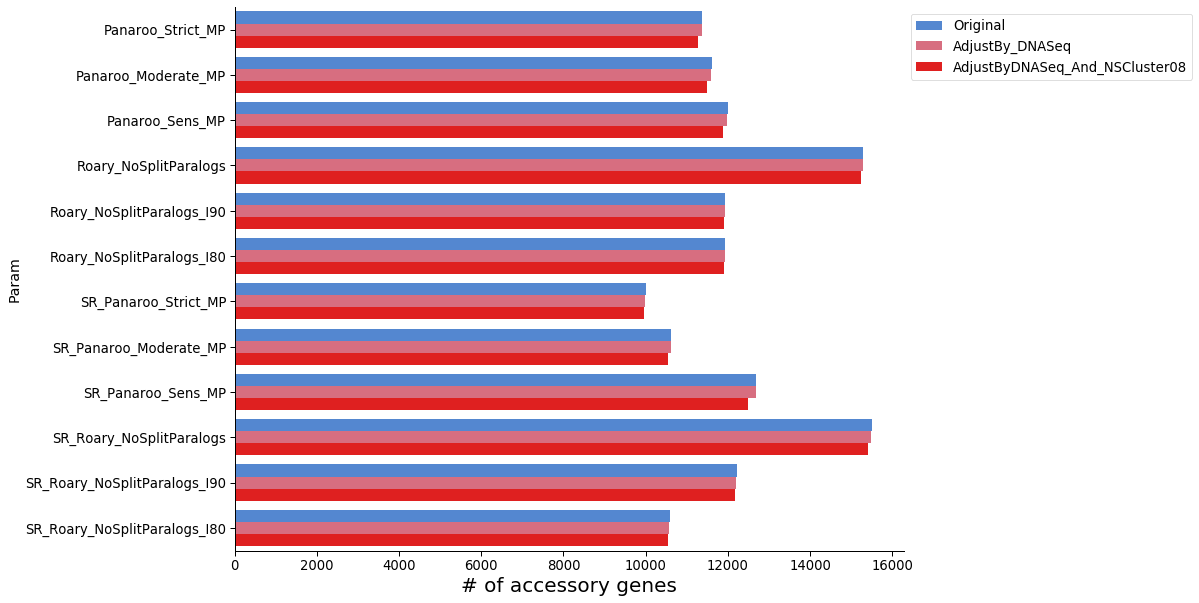

In [51]:
sns.set_context("paper", font_scale=1.5)

fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# Add a legend outside of the plot to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()
plt.show()

In [52]:
PG_Summ_DF.head(2)

Param         Approach  Total  Core  Accessory
0  Panaroo_Strict_MP         Original  14410  3035      11375
1  Panaroo_Strict_MP  AdjustBy_DNASeq  14410  3041      11369

## Measure # of genes merged during NSC step (0.8 thresh)

In [53]:
listOfRows = []

for i_Param, i_Cluster_WiType_DF in ClusterStats_AsmSeqCheck_And_NSC08_Dict.items():

    print(i_Param, i_Cluster_WiType_DF["NS_ClusterID"].nunique(), i_Cluster_WiType_DF["NumGenes"].sum() )

    N_NSCs = i_Cluster_WiType_DF["NS_ClusterID"].nunique()
    N_NSC_Genes = i_Cluster_WiType_DF["NumGenes"].sum()

    listOfRows.append((i_Param, N_NSCs, N_NSC_Genes)  )

     
NSC08_Stats_DF = pd.DataFrame(listOfRows)

NSC08_Stats_DF.columns = ["Param", "Num_NSClusters", "N_Genes_InNSCs"]
NSC08_Stats_DF["GenesToClusters_Ratio"] = NSC08_Stats_DF["N_Genes_InNSCs"] / NSC08_Stats_DF["Num_NSClusters"]
NSC08_Stats_DF.shape



Panaroo_Strict_MP 78 171
Panaroo_Moderate_MP 79 174
Panaroo_Sens_MP 90 205
Roary_NoSplitParalogs 49 104
Roary_NoSplitParalogs_I90 24 49
Roary_NoSplitParalogs_I80 24 49
SR_Panaroo_Strict_MP 35 79
SR_Panaroo_Moderate_MP 57 128
SR_Panaroo_Sens_MP 146 348
SR_Roary_NoSplitParalogs 60 129
SR_Roary_NoSplitParalogs_I90 38 80
SR_Roary_NoSplitParalogs_I80 22 45


(12, 4)

In [54]:
NSC08_Stats_DF

Param  Num_NSClusters  N_Genes_InNSCs  \
0              Panaroo_Strict_MP              78             171   
1            Panaroo_Moderate_MP              79             174   
2                Panaroo_Sens_MP              90             205   
3          Roary_NoSplitParalogs              49             104   
4      Roary_NoSplitParalogs_I90              24              49   
5      Roary_NoSplitParalogs_I80              24              49   
6           SR_Panaroo_Strict_MP              35              79   
7         SR_Panaroo_Moderate_MP              57             128   
8             SR_Panaroo_Sens_MP             146             348   
9       SR_Roary_NoSplitParalogs              60             129   
10  SR_Roary_NoSplitParalogs_I90              38              80   
11  SR_Roary_NoSplitParalogs_I80              22              45   

    GenesToClusters_Ratio  
0                2.192308  
1                2.202532  
2                2.277778  
3                2.122449  
4                2.041667  
5                2.041667  
6                2.257143  
7                2.245614  
8                2.383562  
9                2.150000  
10               2.105263  
11               2.045455

# Measure AsmSeqCheck Change Stats

### AsmSeqCheck Notes
- 0 means absent (CDS AA seq & DNA seq not found in ASM)
- 1 means CDS AA seq present in SR
- 2 Means abesnt but DNA Seq In Asm ("CDS Annotation Discrepancy")


In [55]:
i_SampleIDs = E50I_SampleIDs

In [56]:
listOfRows = []

for i_Param, i_PA_ASC_DF in PresAbs_DF_AsmSeqChk_Dict.items():
    
    #print(i_Param, i_PA_ASC_DF.shape)

    NAbs_0 = (i_PA_ASC_DF[i_SampleIDs] == 0).sum().sum()
    NPres_1 = (i_PA_ASC_DF[i_SampleIDs] == 1).sum().sum()
    NPres_InASC_2 = (i_PA_ASC_DF[i_SampleIDs] == 2).sum().sum()  
    listOfRows.append((i_Param, NAbs_0, NPres_1, NPres_InASC_2)  )
    
    # #print("\n\n\n")

   # break
     
ASC_Stats_DF = pd.DataFrame(listOfRows)

ASC_Stats_DF.columns = ["Param", "NAbs_0", "NPres_1", "NAbs_DNAInAsm_2"]
ASC_Stats_DF["NAbs_Total"] = ASC_Stats_DF["NAbs_0"] + ASC_Stats_DF["NAbs_DNAInAsm_2"]

ASC_Stats_DF["PercAbs_0"] = ASC_Stats_DF["NAbs_0"] / ASC_Stats_DF["NAbs_Total"] * 100
ASC_Stats_DF["PercAbs_2"] = ASC_Stats_DF["NAbs_DNAInAsm_2"] / ASC_Stats_DF["NAbs_Total"] * 100
ASC_Stats_DF["PercAbs_AnnoDiscrep"] = ASC_Stats_DF["PercAbs_2"]

ASC_Stats_DF.shape

(12, 8)

In [57]:
#(i_PA_ASC_DF[i_SampleIDs] == 0).sum().sum()

In [58]:
#(i_PA_ASC_DF[i_SampleIDs] == 1).sum().sum()   

In [59]:
#(i_PA_ASC_DF[i_SampleIDs] == 2).sum().sum()

In [60]:
ASC_Stats_DF

Param  NAbs_0  NPres_1  NAbs_DNAInAsm_2  \
0              Panaroo_Strict_MP  475986   238599             5915   
1            Panaroo_Moderate_MP  486006   239994             6050   
2                Panaroo_Sens_MP  504408   240394             6798   
3          Roary_NoSplitParalogs  642245   237803             9102   
4      Roary_NoSplitParalogs_I90  504937   236048             1565   
5      Roary_NoSplitParalogs_I80  504937   236048             1565   
6           SR_Panaroo_Strict_MP  402071   235206             4523   
7         SR_Panaroo_Moderate_MP  429843   237388             5869   
8             SR_Panaroo_Sens_MP  526130   239554            10516   
9       SR_Roary_NoSplitParalogs  644151   236687            10412   
10  SR_Roary_NoSplitParalogs_I90  508532   235213             2905   
11  SR_Roary_NoSplitParalogs_I80  434697   233884             2419   

    NAbs_Total  PercAbs_0  PercAbs_2  PercAbs_AnnoDiscrep  
0       481901  98.772569   1.227431             1.227431  
1       492056  98.770465   1.229535             1.229535  
2       511206  98.670203   1.329797             1.329797  
3       651347  98.602588   1.397412             1.397412  
4       506502  99.691018   0.308982             0.308982  
5       506502  99.691018   0.308982             0.308982  
6       406594  98.887588   1.112412             1.112412  
7       435712  98.653009   1.346991             1.346991  
8       536646  98.040421   1.959579             1.959579  
9       654563  98.409320   1.590680             1.590680  
10      511437  99.431993   0.568007             0.568007  
11      437116  99.446600   0.553400             0.553400

In [61]:
ASC_Stats_DF["PercAbs_AnnoDiscrep"].describe()

count    12.000000
mean      1.077767
std       0.525906
min       0.308982
25%       0.564356
50%       1.228483
75%       1.359596
max       1.959579
Name: PercAbs_AnnoDiscrep, dtype: float64

In [62]:
i_PA_ASC_DF.shape

(13420, 53)

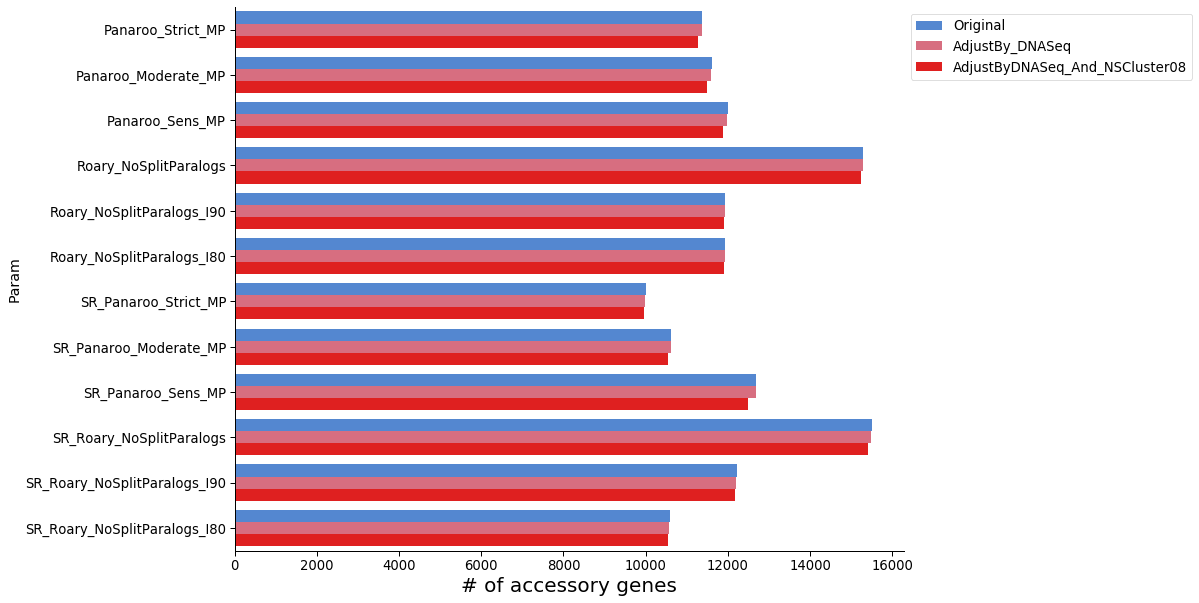

In [63]:
sns.set_context("paper", font_scale=1.5)

fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_DF, ax = axs, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

# Add a legend outside of the plot to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs.set_xlabel("# of accessory genes", fontsize = 20)
sns.despine()
plt.show()

In [64]:
PG_Summ_BeforeAfter_DF = PG_Summ_ASC_ASCwiNSC_DF.query("Approach != 'PGQC - ASC' ")

In [65]:
PG_Summ_BeforeAfter_DF.head(6)

Param          Approach  Total  Core  Accessory       SeqType
0    Panaroo_Strict_MP          Original  14410  3035      11375  Complete Asm
2    Panaroo_Strict_MP  PGQC - ASC & NSC  14317  3041      11276  Complete Asm
3  Panaroo_Moderate_MP          Original  14641  3036      11605  Complete Asm
5  Panaroo_Moderate_MP  PGQC - ASC & NSC  14546  3042      11504  Complete Asm
6      Panaroo_Sens_MP          Original  15032  3036      11996  Complete Asm
8      Panaroo_Sens_MP  PGQC - ASC & NSC  14917  3042      11875  Complete Asm

In [66]:
!mkdir Results5_Plots/

mkdir: cannot create directory ‘Results5_Plots/’: File exists


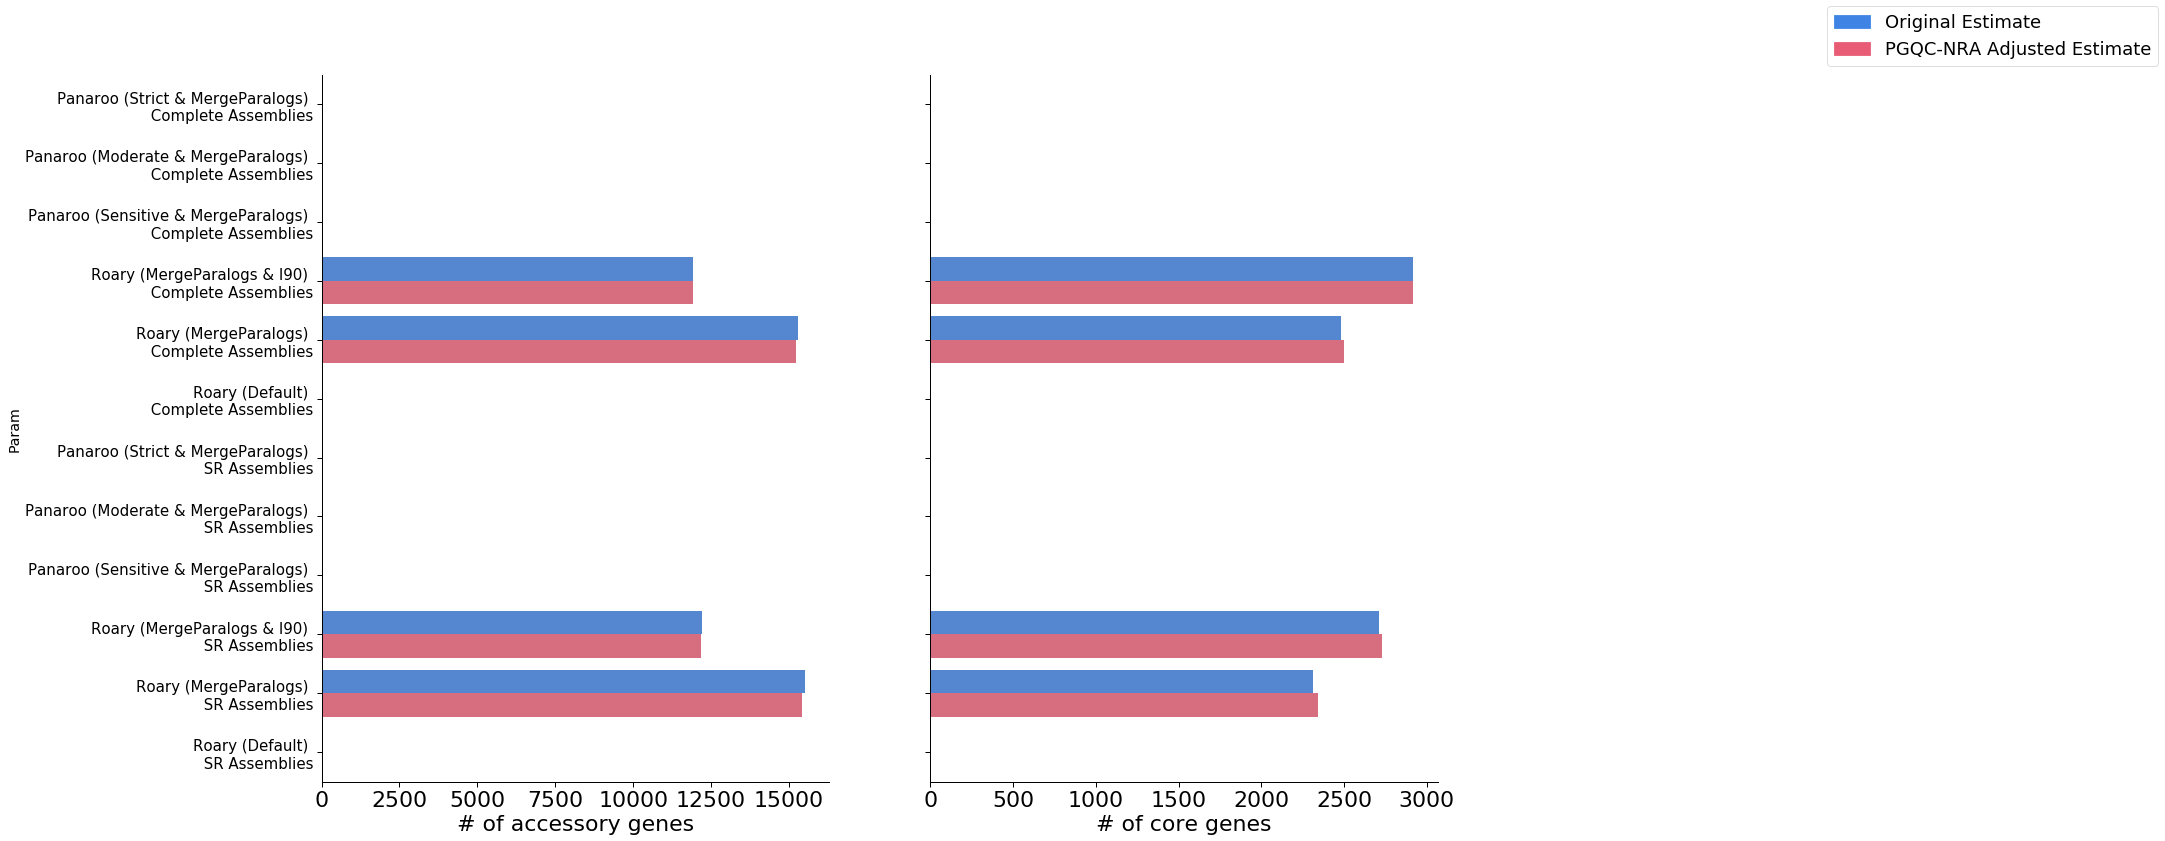

In [67]:
sns.set_context("paper", font_scale=1.5)


orderToPlot_X = ['Panaroo_Strict_MergeParalogs',
                 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sens_MergeParalogs',
                 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',
                 'Roary_Default', 
                 'SR_Panaroo_Strict_MergeParalogs',
                 'SR_Panaroo_Moderate_MergeParalogs',
                 'SR_Panaroo_Sens_MergeParalogs',
                 'SR_Roary_NoSplitParalogs_I90',
                 'SR_Roary_NoSplitParalogs',
                 'SR_Roary_Default', ]

Plot_TickLabels = ['Panaroo (Strict & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n Complete Assemblies',
                   'Roary (MergeParalogs & I90) \n Complete Assemblies',
                   'Roary (MergeParalogs) \n Complete Assemblies', 
                   'Roary (Default) \n Complete Assemblies',
                   'Panaroo (Strict & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n SR Assemblies',
                   'Roary (MergeParalogs & I90) \n SR Assemblies',
                   'Roary (MergeParalogs) \n SR Assemblies', 
                   'Roary (Default) \n SR Assemblies',
                  ]


fig, axs = plt.subplots(1, 2, figsize= (20, 13), sharex=False, sharey=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs[0], 
            order = orderToPlot_X, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

axs[0].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})

sns.barplot(y = "Param", x = "Core", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs[1], 
            order = orderToPlot_X, palette = ["#3F84E5", "#E85D75", "red", "purple"] )

axs[1].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})



# Add a legend outside of the plot to the right
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs[0].set_xlabel("# of accessory genes", fontsize = 22)
axs[1].set_xlabel("# of core genes", fontsize = 22)

OG_patch = mpatches.Patch(color="#3F84E5", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#E85D75", label='PGQC-NRA Adjusted Estimate')

bbox_to_anchor=(1.75, 1)

axs[1].legend(handles=[OG_patch, NRA_patch],
              bbox_to_anchor=(1.75, 1), fontsize= 18) 

axs[0].get_legend().remove()

axs[0].tick_params(axis='x', labelsize=22)
axs[1].tick_params(axis='x', labelsize=22)


plt.ylabel("")
sns.despine()

#plt.savefig("Results5_Plots/5.Ecoli50.PG.GeneCounts.BeforeAndAfter.NRAAdjust.CombinedBarplot.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results5_Plots/5.Ecoli50.PG.GeneCounts.BeforeAndAfter.NRAAdjust.CombinedBarplot.svg", bbox_inches="tight")

plt.show()

# Generate barplots for PGQC-NRC analysis - Ecoli50CI

In [68]:
!mkdir Results5_Plots/

mkdir: cannot create directory ‘Results5_Plots/’: File exists


In [69]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [70]:
plt.style.use('../240103_2_MtbPangenome_151CI_V5/nqo.mplstyle')

In [71]:
PG_Summ_BeforeAfter_DF["Param"].value_counts()

Panaroo_Strict_MP               2
Panaroo_Moderate_MP             2
Panaroo_Sens_MP                 2
Roary_NoSplitParalogs           2
Roary_NoSplitParalogs_I90       2
Roary_NoSplitParalogs_I80       2
SR_Panaroo_Strict_MP            2
SR_Panaroo_Moderate_MP          2
SR_Panaroo_Sens_MP              2
SR_Roary_NoSplitParalogs        2
SR_Roary_NoSplitParalogs_I90    2
SR_Roary_NoSplitParalogs_I80    2
Name: Param, dtype: int64

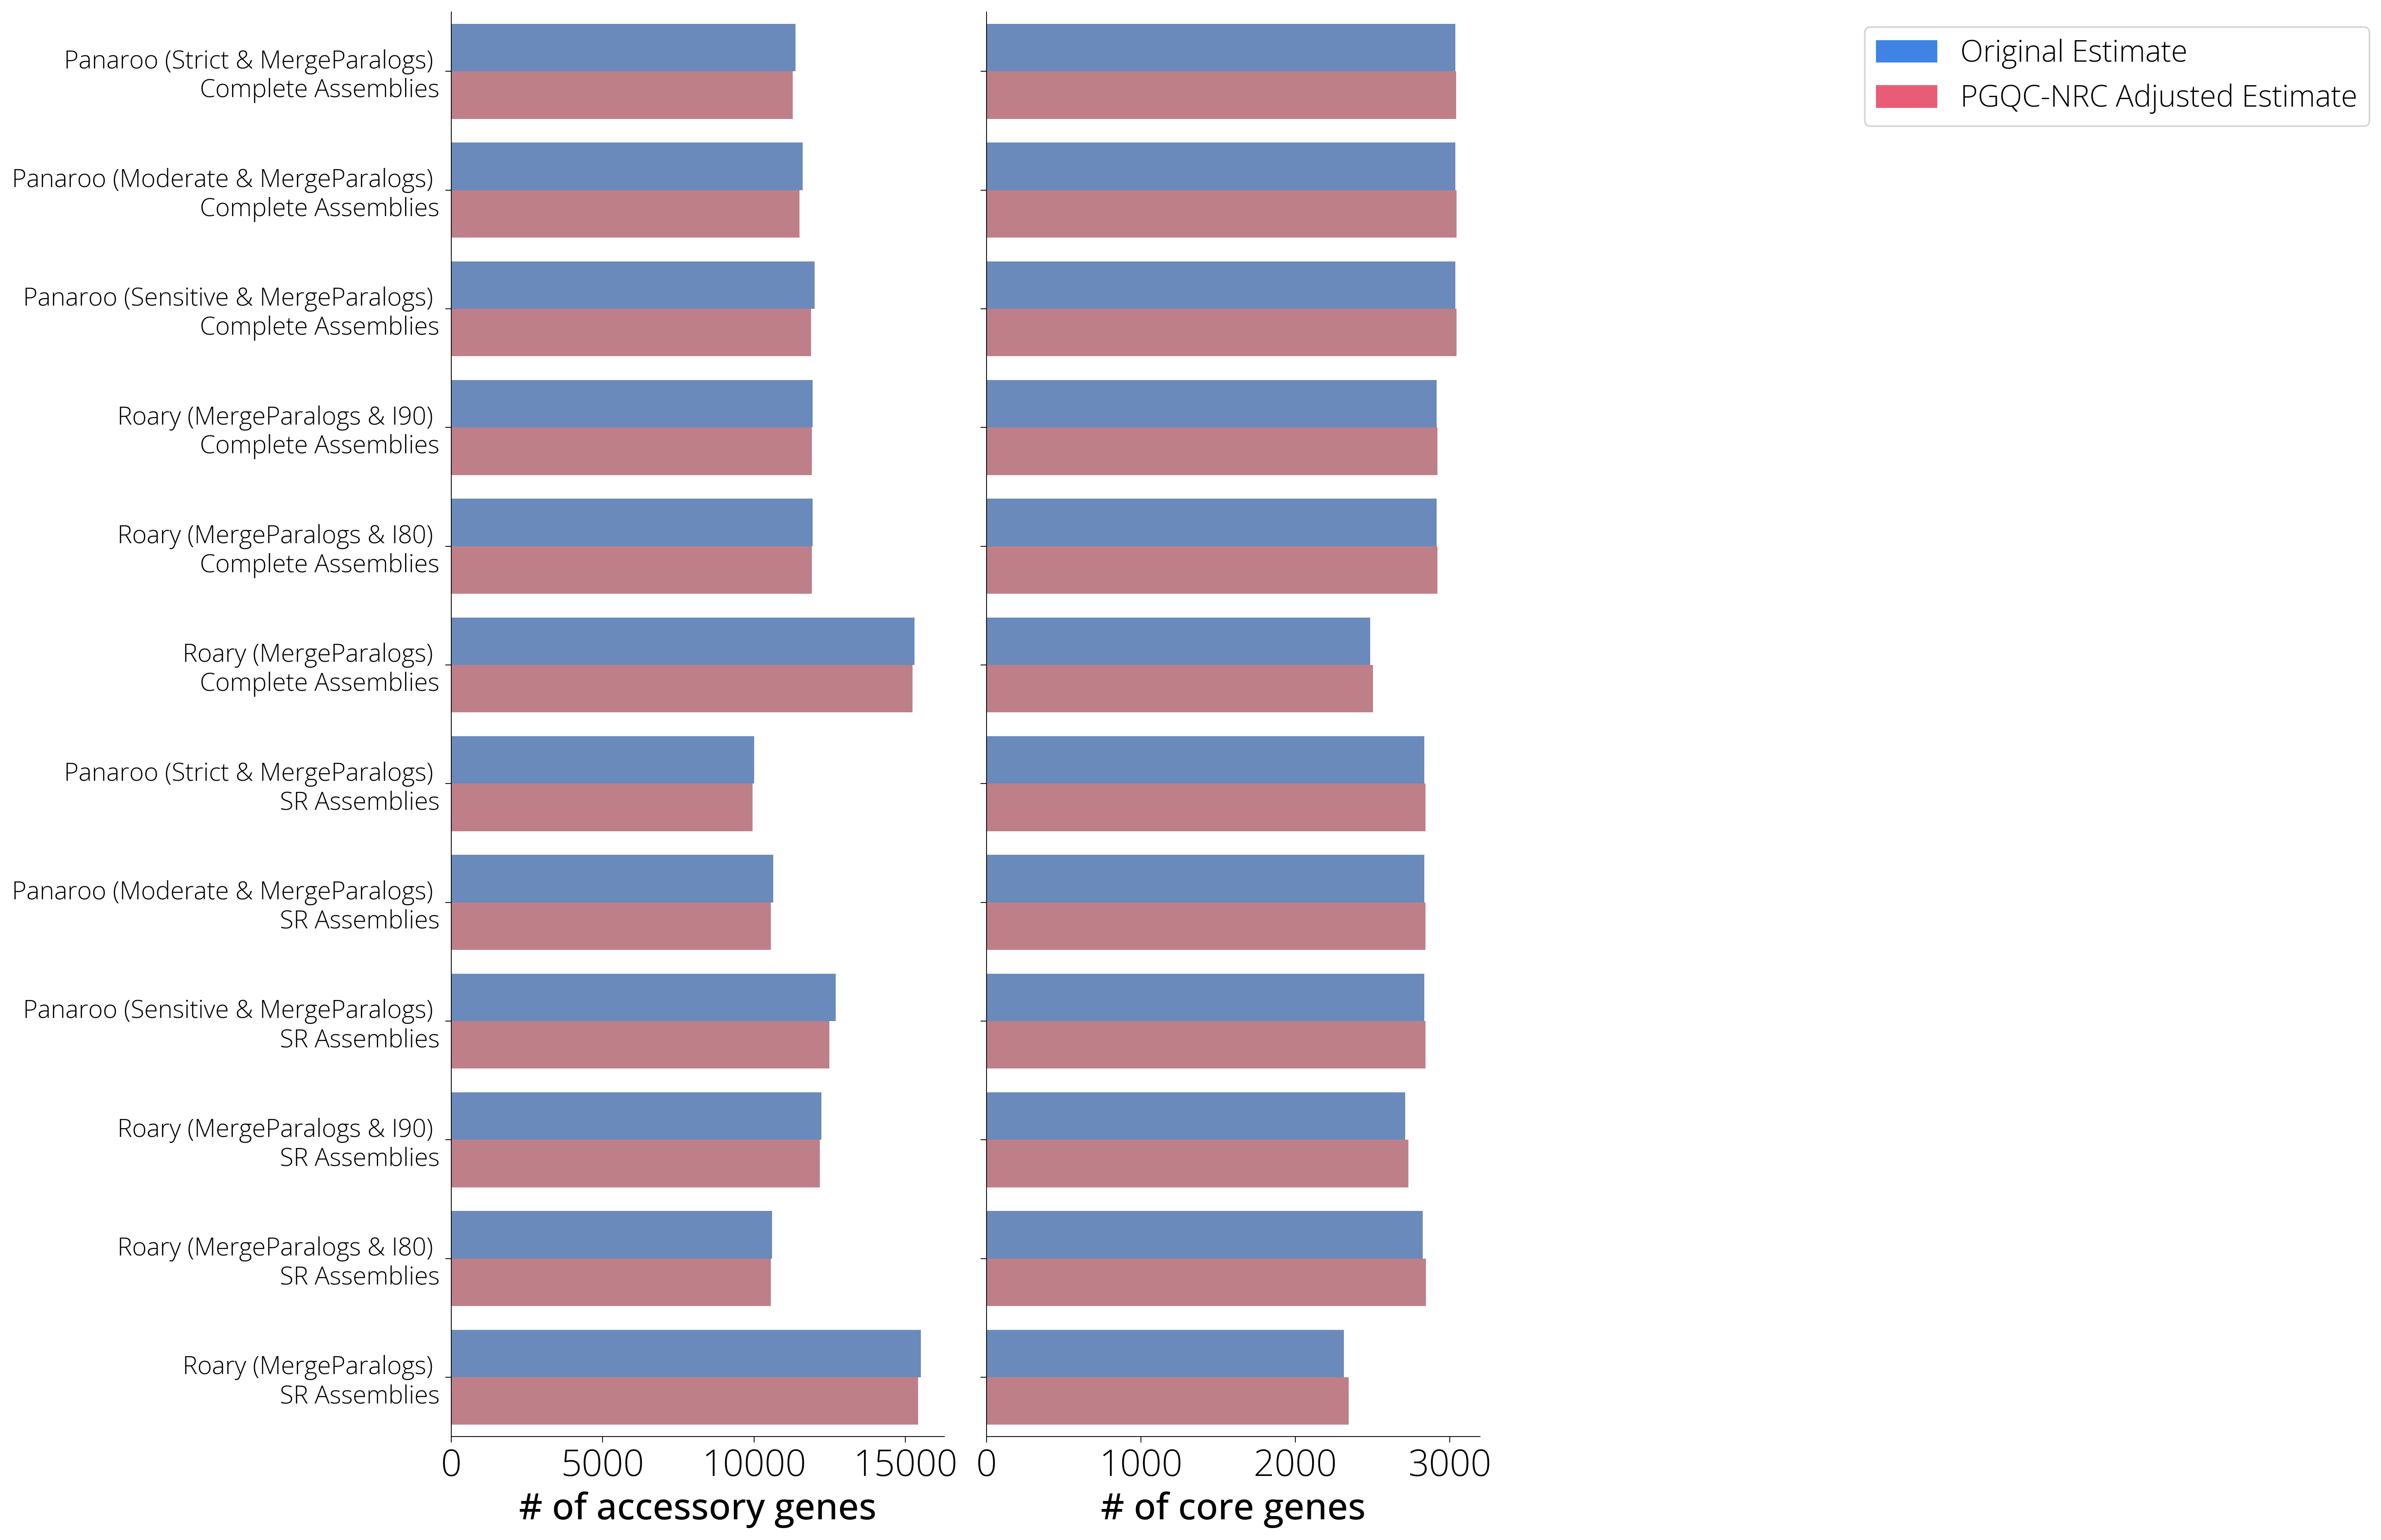

In [72]:
#sns.set_context("paper", font_scale=1.5)


orderToPlot_X = ['Panaroo_Strict_MP',
                 'Panaroo_Moderate_MP',
                 'Panaroo_Sens_MP',
                 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs_I80',
                 'Roary_NoSplitParalogs',
                 'SR_Panaroo_Strict_MP',
                 'SR_Panaroo_Moderate_MP',
                 'SR_Panaroo_Sens_MP',
                 'SR_Roary_NoSplitParalogs_I90',
                 'SR_Roary_NoSplitParalogs_I80',
                 'SR_Roary_NoSplitParalogs',]

Plot_TickLabels = ['Panaroo (Strict & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n Complete Assemblies',
                   'Roary (MergeParalogs & I90) \n Complete Assemblies',
                   'Roary (MergeParalogs & I80) \n Complete Assemblies',
                   'Roary (MergeParalogs) \n Complete Assemblies',
                   'Panaroo (Strict & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Moderate & MergeParalogs) \n SR Assemblies',
                   'Panaroo (Sensitive & MergeParalogs) \n SR Assemblies',
                   'Roary (MergeParalogs & I90) \n SR Assemblies',
                   'Roary (MergeParalogs & I80) \n SR Assemblies',
                   'Roary (MergeParalogs) \n SR Assemblies', ]


fig, axs = plt.subplots(1, 2, figsize= (20, 13), sharex=False, sharey=True)

sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs[0], 
            order = orderToPlot_X, palette = ["#5E87CA", "#CA7481", "red", "purple"] )

axs[0].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})

sns.barplot(y = "Param", x = "Core", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs[1], 
            order = orderToPlot_X, palette = ["#5E87CA", "#CA7481", "red", "purple"] )

axs[1].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})



# Add a legend outside of the plot to the right
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

axs[0].set_xlabel("# of accessory genes", fontsize = 22)
axs[1].set_xlabel("# of core genes", fontsize = 22)

OG_patch = mpatches.Patch(color="#3F84E5", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#E85D75", label='PGQC-NRC Adjusted Estimate')

bbox_to_anchor=(1.75, 1)

axs[1].legend(handles=[OG_patch, NRA_patch],
              bbox_to_anchor=(1.75, 1), fontsize= 18) 

axs[0].get_legend().remove()

axs[0].tick_params(axis='x', labelsize=22)
axs[1].tick_params(axis='x', labelsize=22)

axs[0].set_ylabel("")
axs[1].set_ylabel("")

sns.despine()

plt.savefig("Results5_Plots/6.Ecoli50CI.PG.GeneCounts.BeforeAndAfter.NRAAdjust.CombinedBarplot.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results5_Plots/6.Ecoli50CI.PG.GeneCounts.BeforeAndAfter.NRAAdjust.CombinedBarplot.svg", bbox_inches="tight")

plt.show()

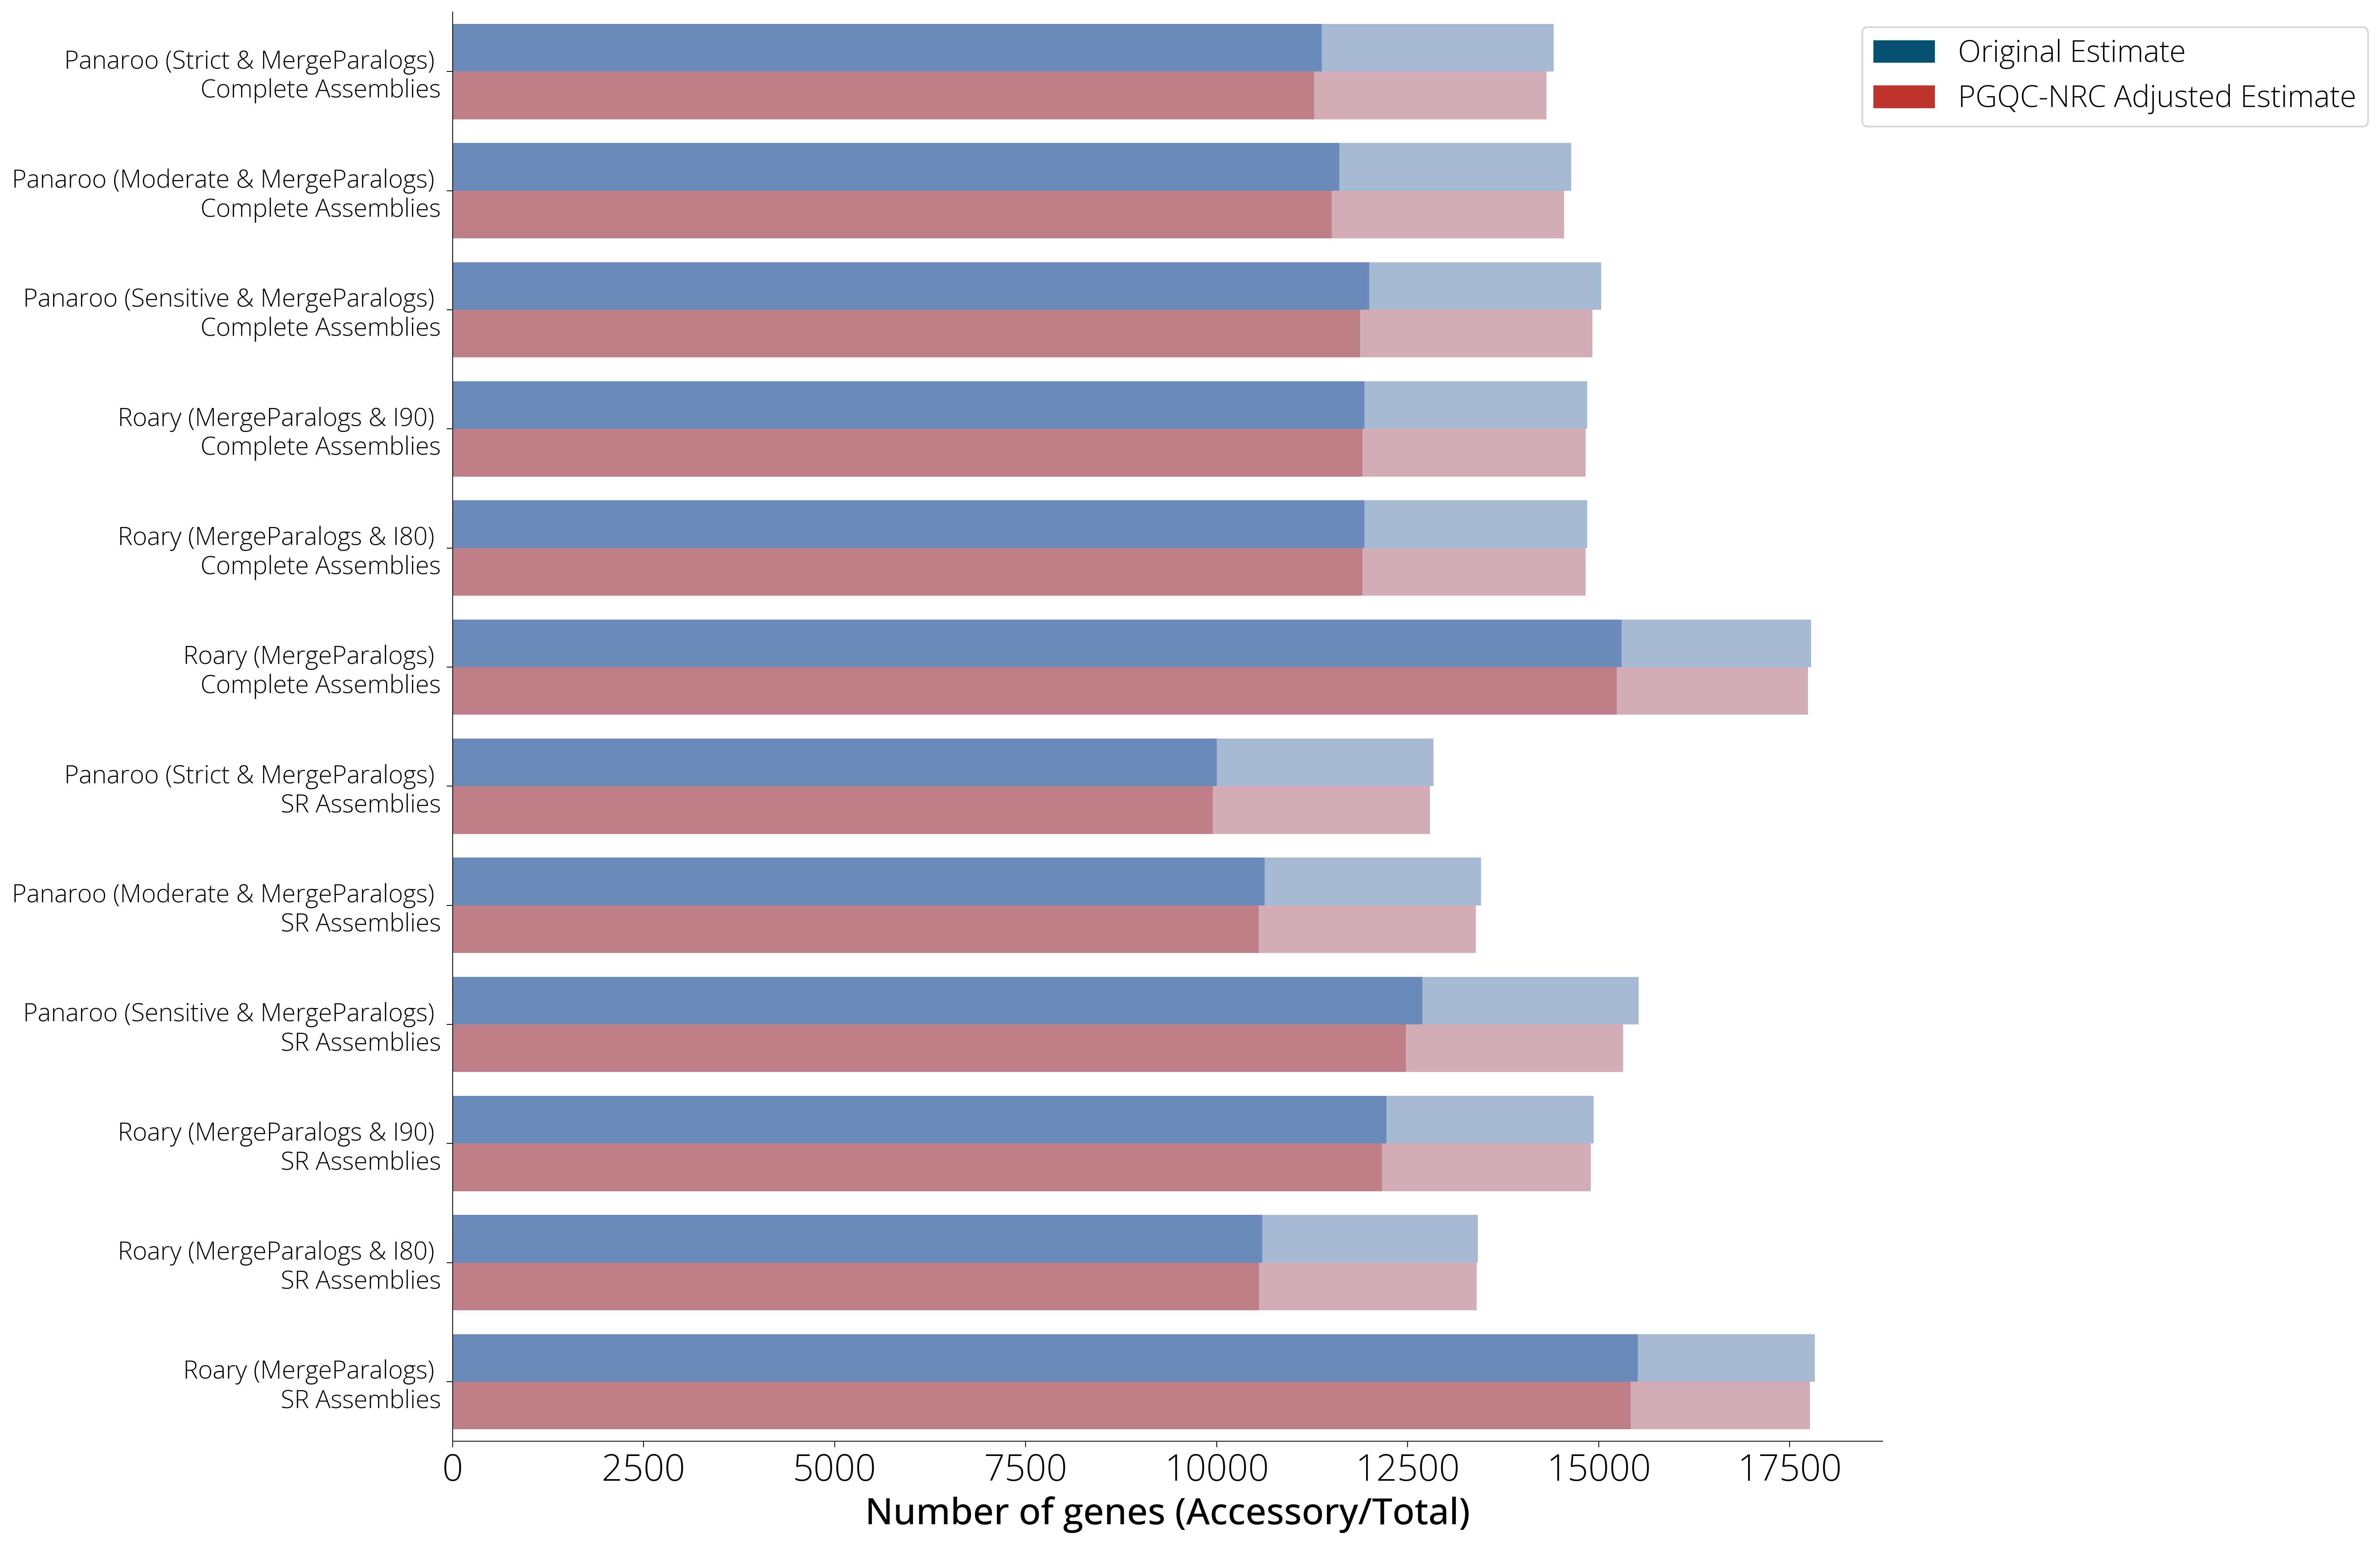

In [73]:
#sns.set_context("paper", font_scale=1.5)


fig, axs = plt.subplots(1, 1, figsize= (20, 13), sharex=False, sharey=True)

sns.barplot(y = "Param", x = "Total", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs, 
            order = orderToPlot_X, palette = ["#9FB9DC", "#DBA6B2"] )


sns.barplot(y = "Param", x = "Accessory", hue = "Approach",
            data = PG_Summ_BeforeAfter_DF, ax = axs, 
            order = orderToPlot_X, palette = ["#5E87CA", "#CA7481"] )

axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})


axs.set_xlabel("Number of genes (Accessory/Total)", fontsize = 22)

OG_patch = mpatches.Patch(color="#065275", label='Original Estimate')
NRA_patch = mpatches.Patch(color = "#bd342d", label='PGQC-NRC Adjusted Estimate')

axs.legend(handles=[OG_patch, NRA_patch],
              bbox_to_anchor=(1.35, 1), fontsize= 18) 

axs.tick_params(axis='x', labelsize=22)

axs.set_ylabel("")

sns.despine()

plt.savefig("Results5_Plots/6.Ecoli50CI.PG.GeneCounts.BeforeAndAfter.NRAAdjust.OverlapBarplot.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results5_Plots/6.Ecoli50CI.PG.GeneCounts.BeforeAndAfter.NRAAdjust.OverlapBarplot.svg", bbox_inches="tight")

plt.show()

In [ ]:
STOP!!!

# Presence Absence Matrix Visualization

# Test - Explore code for Viz of PA matrices (Wi PGQC)

In [117]:
from matplotlib.colors import ListedColormap

colormap_dict = {0: "#FFFFD6", 1: "#041B4C", 2: "black", 3: "red", 4: "#15ACBB", 5: "#15ACBB"}

# Convert the custom dictionary to a colormap
colors = [colormap_dict[i] for i in sorted(colormap_dict.keys())]
custom_cmap = ListedColormap(colors)


#colormap_dict2 = {0: "#FFFFD6", 1: "#041B4C", 2: "#FFFFD6", 3: "#FFFFD6", 4: "#FFFFD6", 5: "#FFFFD6"}

# Convert the custom dictionary to a colormap
#colors_2 = [colormap_dict2[i] for i in sorted(colormap_dict2.keys())]
#custom_cmap_2 = ListedColormap(colors_2)


colormap_dict_PGQC_3 = {0: "#FFFFD6", 1: "#041B4C", 2: "#15ACBB", }

# Convert the custom dictionary to a colormap
colors_PGQC_3 = [colormap_dict_PGQC_3[i] for i in sorted(colormap_dict_PGQC_3.keys())]
custom_cmap_PGQC_3 = ListedColormap(colors_PGQC_3)


### Test viz w/ Panaroo - Mod MP - LR

In [118]:
PresAbs_DF_AsmSeqChk_Dict.keys()

dict_keys(['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs', 'Panaroo_Sens_MergeParalogs', 'Roary_Default', 'Roary_NoSplitParalogs', 'Roary_NoSplitParalogs_I90', 'SR_Panaroo_Strict_MergeParalogs', 'SR_Panaroo_Moderate_MergeParalogs', 'SR_Panaroo_Sens_MergeParalogs', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90'])

In [119]:
PresAbs_DF_AsmSeqChk_Dict["Panaroo_Moderate_MergeParalogs"].head(2)

Gene  GCA_014109125  GCA_014109065  GCA_013923405  \
Gene                                                                    
yphF~~~rbsB  yphF~~~rbsB              1              1              1   
yojI                yojI              1              1              1   

             GCA_013821965  GCA_013819985  GCA_013899665  GCA_013895455  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013783465  GCA_013752075  GCA_013891895  GCA_013796065  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013782445  GCA_013928845  GCA_013924285  GCA_013713325  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013712565  GCA_013894775  GCA_013752295  GCA_013750375  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013899205  GCA_013898935  GCA_014103665  GCA_014103465  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013746655  GCA_013745515  GCA_013732895  GCA_013786125  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013728735  GCA_013897665  GCA_013897255  GCA_013896775  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013896515  GCA_013886475  GCA_013806925  GCA_013806525  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013806085  GCA_013835405  GCA_013817865  GCA_013790245  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013900245  GCA_013836945  GCA_013823125  GCA_013894235  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013817505  GCA_013898995  GCA_013898775  GCA_013830785  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
yojI                     1              1              1              1   

             GCA_013800125  GCA_014103195  GCA_013602835  NumAsm_WiGene  \
Gene                                                                      
yphF~~~rbsB              1              1              1             50   
yojI                     1              1              1             50   

             NumAsm_WiGene_DNASeq  
Gene                               
yphF~~~rbsB                    50  
yojI   

#### Set param of interest

In [120]:
i_Param = "Panaroo_Moderate_MergeParalogs"


In [121]:
i_PA_DF = PresAbs_DF_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)

i_PA_ASC_DF = PresAbs_DF_AsmSeqChk_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)

i_PA_ASC_NSC08_DF = PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)



In [122]:
get_PG_Stats_FromPresAbs(i_PA_DF, N_Genomes)


Accessory Thresh: 49.5


(14641, 3036, 11605)

In [123]:
get_PG_Stats_FromDNASeqPresAbs(i_PA_ASC_DF, N_Genomes)


Accessory Thresh: 49.5


(14641, 3042, 11599)

In [124]:
get_PG_Stats_FromPresAbs(i_PA_ASC_NSC08_DF, N_Genomes)


Accessory Thresh: 49.5


(14546, 3042, 11504)

In [125]:
i_PA_ASC_NSC08_DF.head(4)

Gene  GCA_014109125  GCA_014109065  GCA_013923405  GCA_013821965  \
0   yphF~~~rbsB              1              1              1              1   
10         manA              1              1              1              1   
11         lysC              1              1              1              1   
2          yjfN              1              1              1              1   

    GCA_013819985  GCA_013899665  GCA_013895455  GCA_013783465  GCA_013752075  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1              1              1              1   

    GCA_013891895  GCA_013796065  GCA_013782445  GCA_013928845  GCA_013924285  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1              1              1              1   

    GCA_013713325  GCA_013712565  GCA_013894775  GCA_013752295  GCA_013750375  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1              1              1              1   

    GCA_013899205  GCA_013898935  GCA_014103665  GCA_014103465  GCA_013746655  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1              1              1              1   

    GCA_013745515  GCA_013732895  GCA_013786125  GCA_013728735  GCA_013897665  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1              1              1              1   

    GCA_013897255  GCA_013896775  GCA_013896515  GCA_013886475  GCA_013806925  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1              1              1              1   

    GCA_013806525  GCA_013806085  GCA_013835405  GCA_013817865  GCA_013790245  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1              1              1              1   

    GCA_013900245  GCA_013836945  GCA_013823125  GCA_013894235  GCA_013817505  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1              1              1              1   

    GCA_013898995  GCA_013898775  GCA_013830785  GCA_013800125  GCA_014103195  \
0               1              1              1              1              1   
10              1              1              1              1              1   
11              1              1              1              1              1   
2               1              1           

### A) Plot PresAbs (OG) - Panaroo Mod + MP

#### Plot entire PG

(50, 14641)


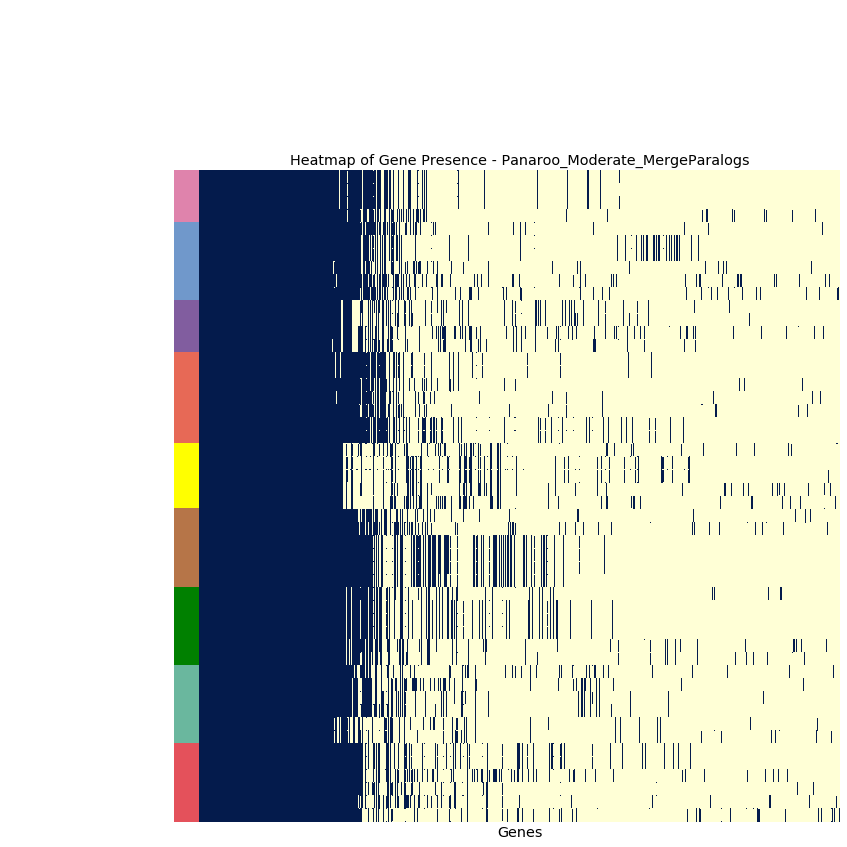

In [126]:
DF = i_PA_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

#### Plot Acc Genes

(50, 11605)


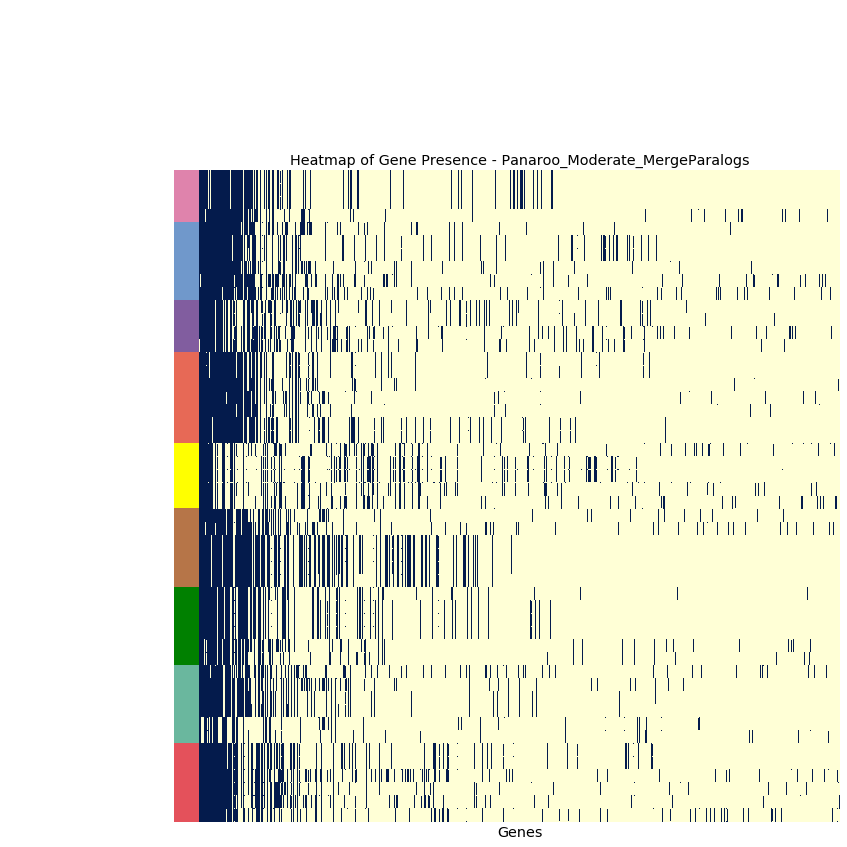

Accessory Thresh: 49.5


(50, 11605)

In [127]:
DF = i_PA_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 49")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

get_PG_Stats_FromPresAbs(i_PA_DF, N_Genomes)

heatmap_data.shape

### B) Plot PresAbs (ASC Adjusted) - Panaroo Mod + MP

In [128]:
i_PA_ASC_DF.head(1)

Gene  GCA_014109125  GCA_014109065  GCA_013923405  \
Gene                                                                    
yphF~~~rbsB  yphF~~~rbsB              1              1              1   

             GCA_013821965  GCA_013819985  GCA_013899665  GCA_013895455  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013783465  GCA_013752075  GCA_013891895  GCA_013796065  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013782445  GCA_013928845  GCA_013924285  GCA_013713325  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013712565  GCA_013894775  GCA_013752295  GCA_013750375  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013899205  GCA_013898935  GCA_014103665  GCA_014103465  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013746655  GCA_013745515  GCA_013732895  GCA_013786125  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013728735  GCA_013897665  GCA_013897255  GCA_013896775  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013896515  GCA_013886475  GCA_013806925  GCA_013806525  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013806085  GCA_013835405  GCA_013817865  GCA_013790245  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013900245  GCA_013836945  GCA_013823125  GCA_013894235  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013817505  GCA_013898995  GCA_013898775  GCA_013830785  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   

             GCA_013800125  GCA_014103195  GCA_013602835  NumAsm_WiGene  \
Gene                                                                      
yphF~~~rbsB              1              1              1             50   

             NumAsm_WiGene_DNASeq  
Gene                               
yphF~~~rbsB                    50

(50, 11605)


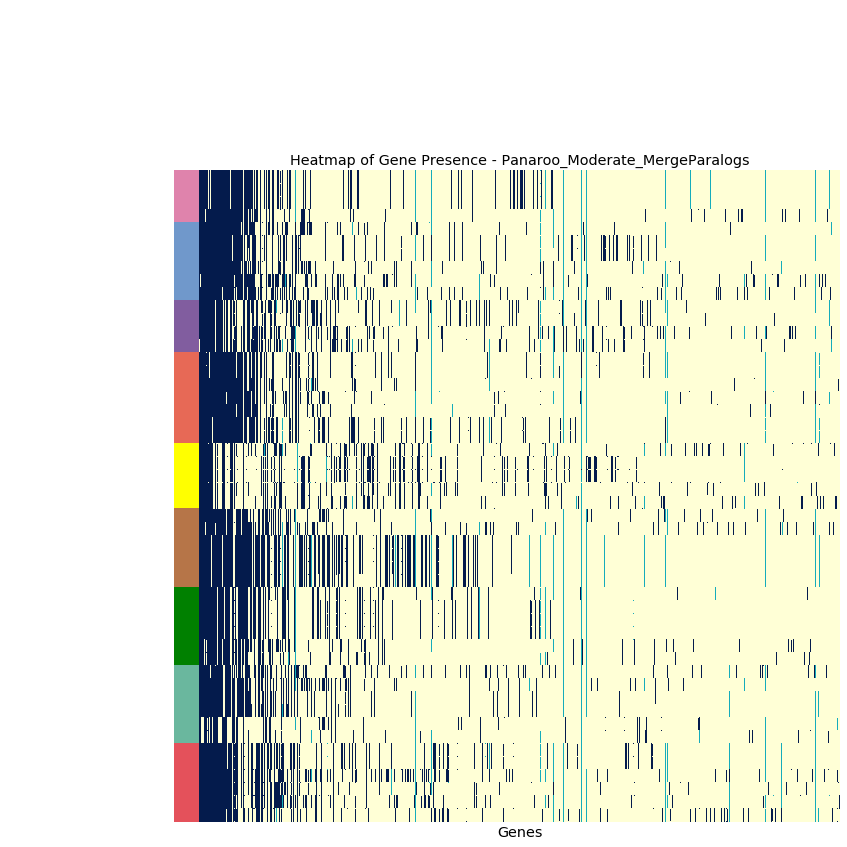

Accessory Thresh: 49.5
(14641, 3042, 11599)
(50, 11605)


In [129]:
DF = i_PA_ASC_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 49")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 

print(get_PG_Stats_FromDNASeqPresAbs(DF, N_Genomes))
print(heatmap_data.shape)

In [130]:
DF.head(2)

Gene  GCA_014109125  GCA_014109065  GCA_013923405  \
Gene                                                                    
yphF~~~rbsB  yphF~~~rbsB              1              1              1   
osmY                osmY              1              1              1   

             GCA_013821965  GCA_013819985  GCA_013899665  GCA_013895455  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013783465  GCA_013752075  GCA_013891895  GCA_013796065  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013782445  GCA_013928845  GCA_013924285  GCA_013713325  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013712565  GCA_013894775  GCA_013752295  GCA_013750375  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013899205  GCA_013898935  GCA_014103665  GCA_014103465  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013746655  GCA_013745515  GCA_013732895  GCA_013786125  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013728735  GCA_013897665  GCA_013897255  GCA_013896775  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013896515  GCA_013886475  GCA_013806925  GCA_013806525  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013806085  GCA_013835405  GCA_013817865  GCA_013790245  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013900245  GCA_013836945  GCA_013823125  GCA_013894235  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013817505  GCA_013898995  GCA_013898775  GCA_013830785  \
Gene                                                                      
yphF~~~rbsB              1              1              1              1   
osmY                     1              1              1              1   

             GCA_013800125  GCA_014103195  GCA_013602835  NumAsm_WiGene  \
Gene                                                                      
yphF~~~rbsB              1              1              1             50   
osmY                     1              1              1             50   

             NumAsm_WiGene_DNASeq  
Gene                               
yphF~~~rbsB                    50  
osmY   

(50, 11605)


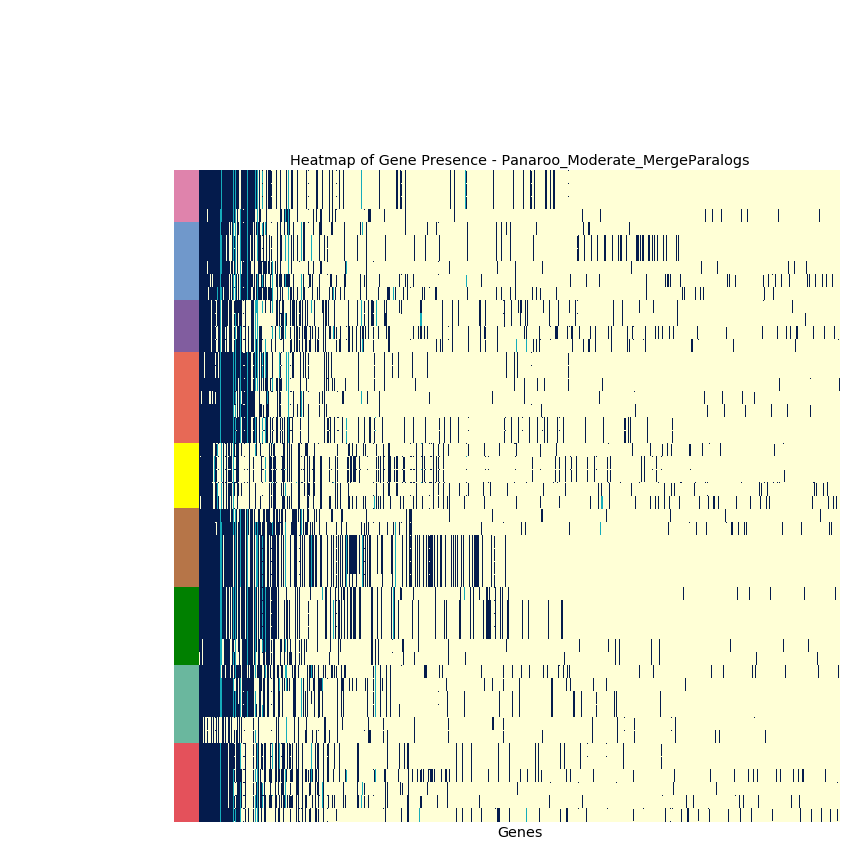

Accessory Thresh: 49.5
(14641, 3042, 11599)
(50, 11605)


In [131]:
DF = i_PA_ASC_DF.sort_values("NumAsm_WiGene_DNASeq", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 49")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 
print(get_PG_Stats_FromDNASeqPresAbs(DF, N_Genomes))
print(heatmap_data.shape)

### C) Plot PresAbs (ASC & NSC Adjusted) - Panaroo Mod + MP

(50, 11504)


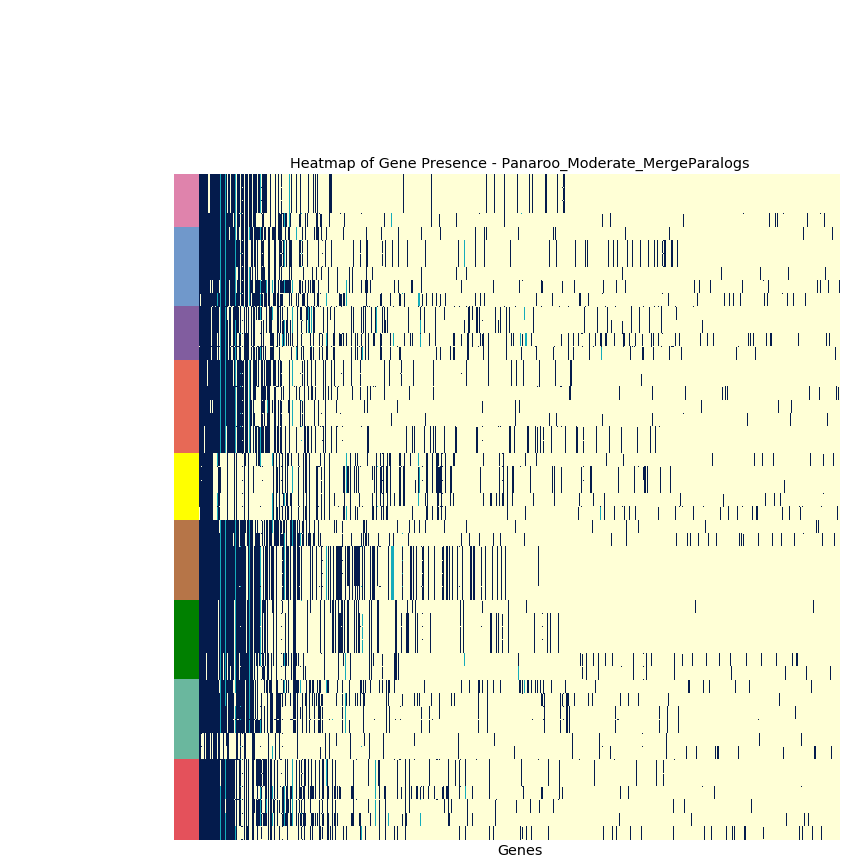

Accessory Thresh: 49.5
(14546, 3042, 11504)
(50, 11504)


In [132]:
DF = i_PA_ASC_NSC08_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 49")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 
print(get_PG_Stats_FromPresAbs(DF, N_Genomes))
print(heatmap_data.shape)

In [133]:
heatmap_data.shape

(50, 11504)

### C) Plot PresAbs (ASC & NSC 0.8 Adjusted) - Panaroo Mod + MP

(50, 14546)


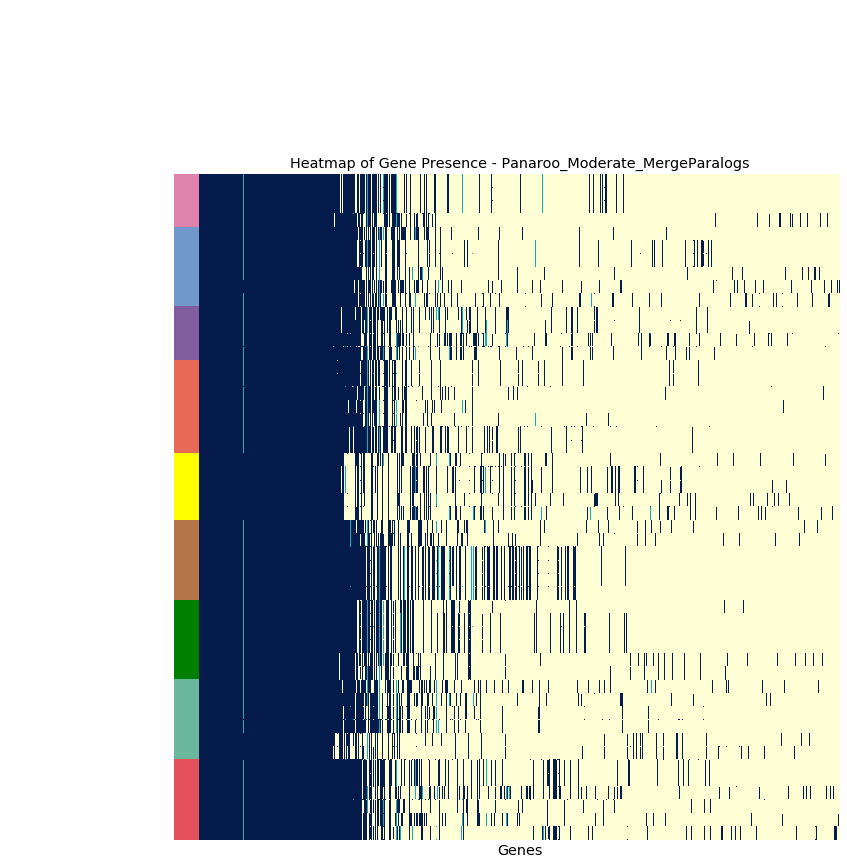

Accessory Thresh: 49.5


(14546, 3042, 11504)

In [134]:
DF = i_PA_ASC_NSC08_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 157")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 
get_PG_Stats_FromPresAbs(DF, N_Genomes)

#DF.query("NumAsm_WiGene < 10").shape

(50, 14546)


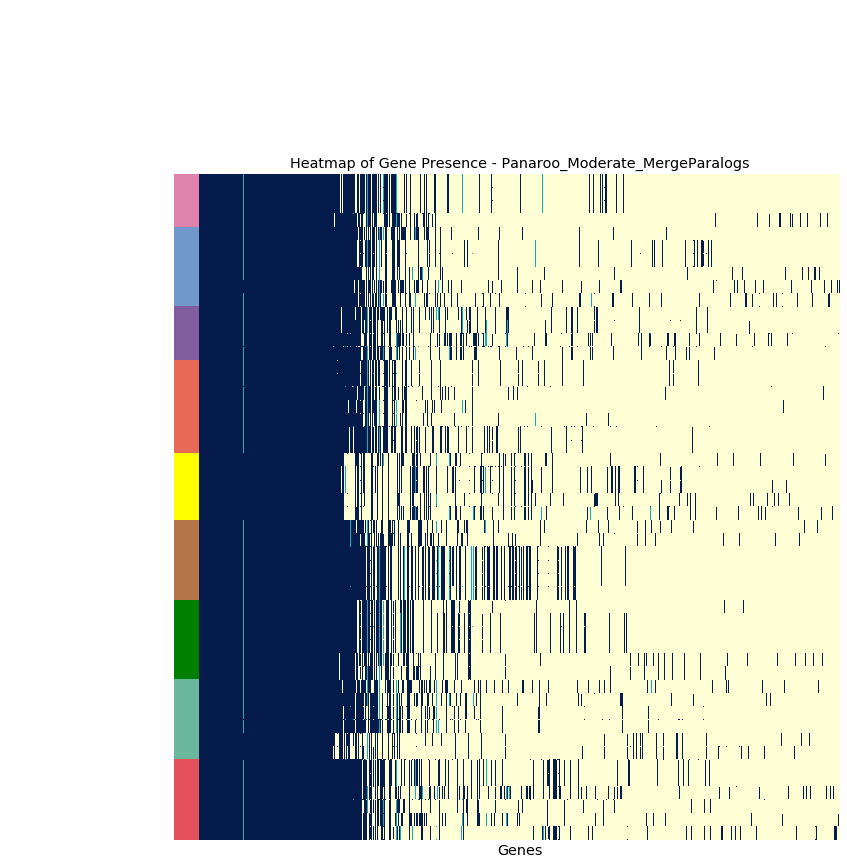

Accessory Thresh: 49.5


(8873, 52)

In [135]:
DF = i_PA_ASC_NSC08_DF.sort_values("NumAsm_WiGene", ascending=False)

heatmap_data = DF.query("NumAsm_WiGene <= 158")[OrderOfSampleIDs_Phylo].T
print(heatmap_data.shape)

row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]

# Plotting the heatmap - BEFORE QC

fig_dims = (12, 12)
clustermap_plot = sns.clustermap(heatmap_data, 
                                 row_colors=row_colors,
                                 cmap = custom_cmap_PGQC_3, vmax= 3,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False)

#sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
plt.title(f'Heatmap of Gene Presence - {i_Param}')
plt.ylabel('Assemblies')
plt.ylabel('')

plt.xlabel('Genes')
plt.show() 
get_PG_Stats_FromPresAbs(DF, N_Genomes)

DF.query("NumAsm_WiGene < 10").shape

In [136]:
#DF.query("NumAsm_WiGene < 10")[OrderOfSampleIDs_Phylo + ["NumAsm_WiGene"]]

In [137]:
get_PG_Stats_FromPresAbs(DF, N_Genomes, True)

Accessory Thresh: 49.5
# of core genes: 3042
# of accessory genes: 11504


(14546, 3042, 11504)

## Plot all BEFORE & AFTER PGQC ASC & NSC Adjustment - PA plots

Panaroo_Strict_MergeParalogs
(50, 11375)


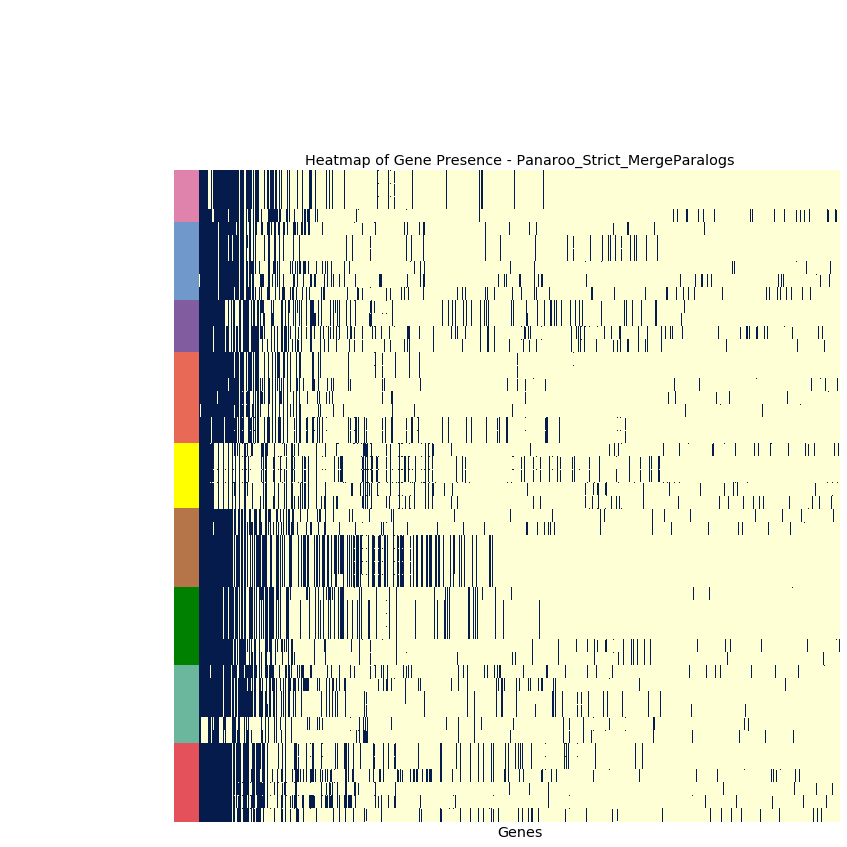

(50, 11276)


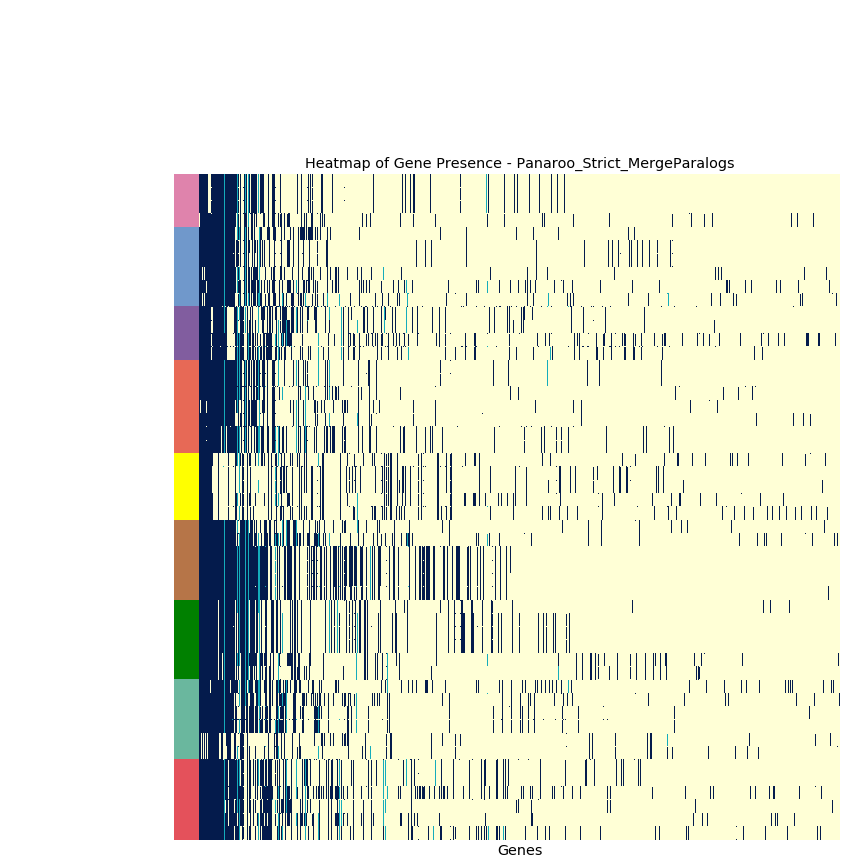

Panaroo_Moderate_MergeParalogs
(50, 11605)


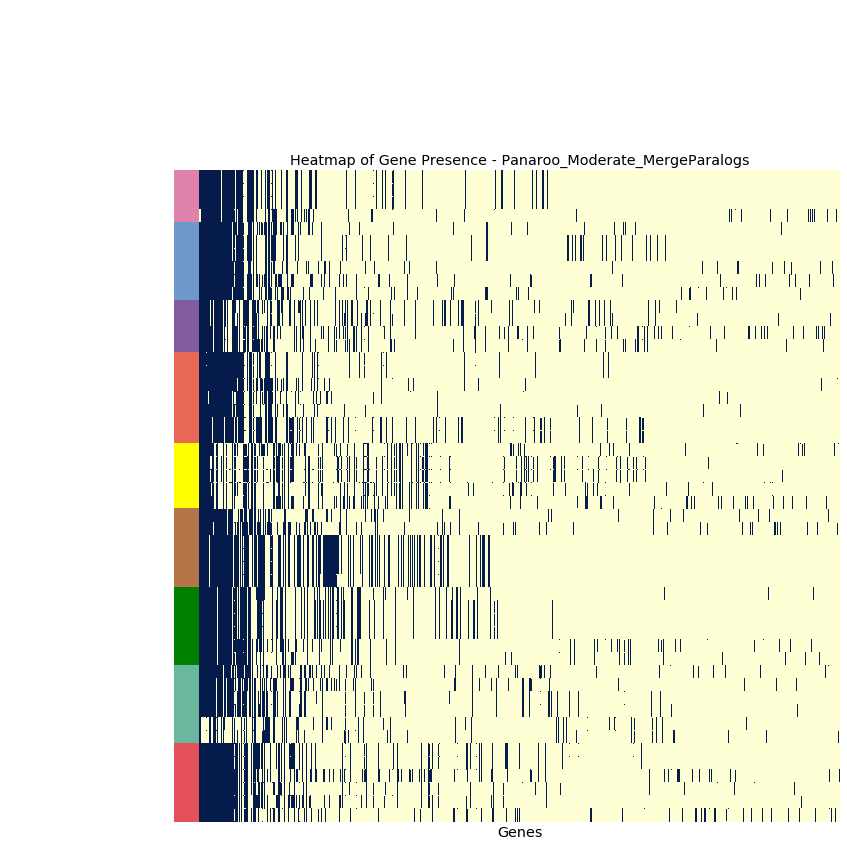

(50, 11504)


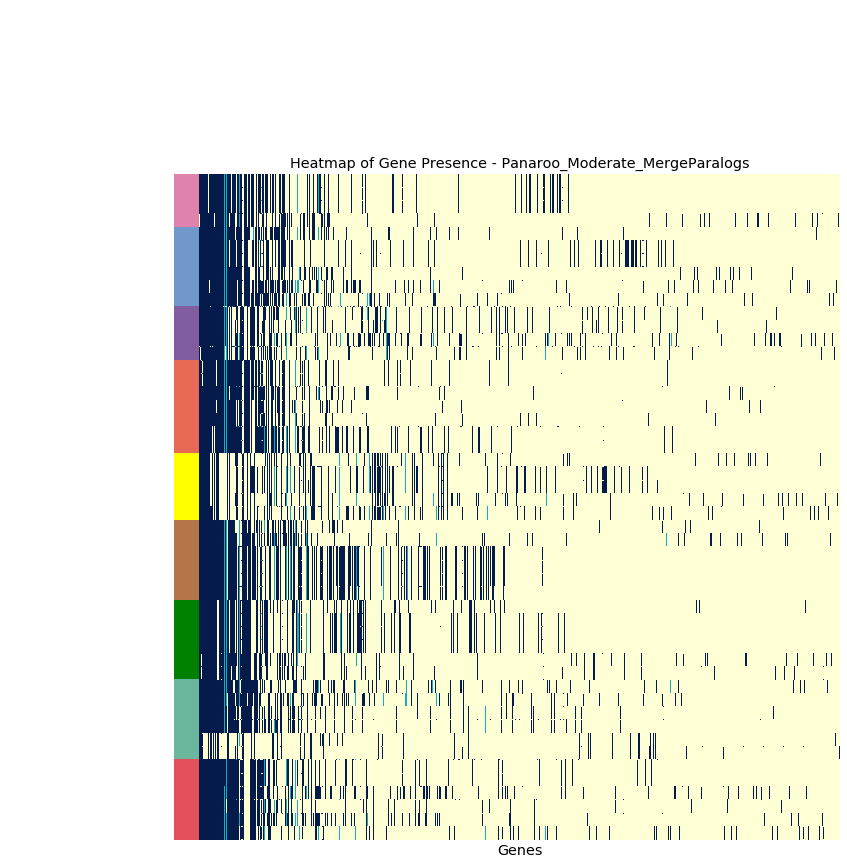

Panaroo_Sens_MergeParalogs
(50, 11996)


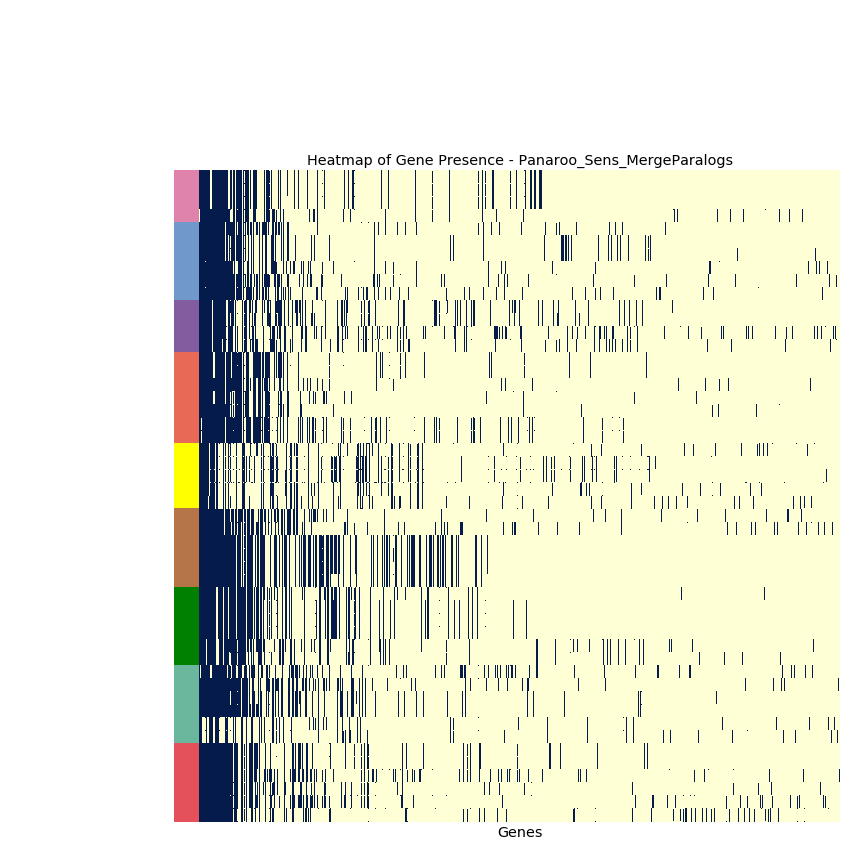

(50, 11875)


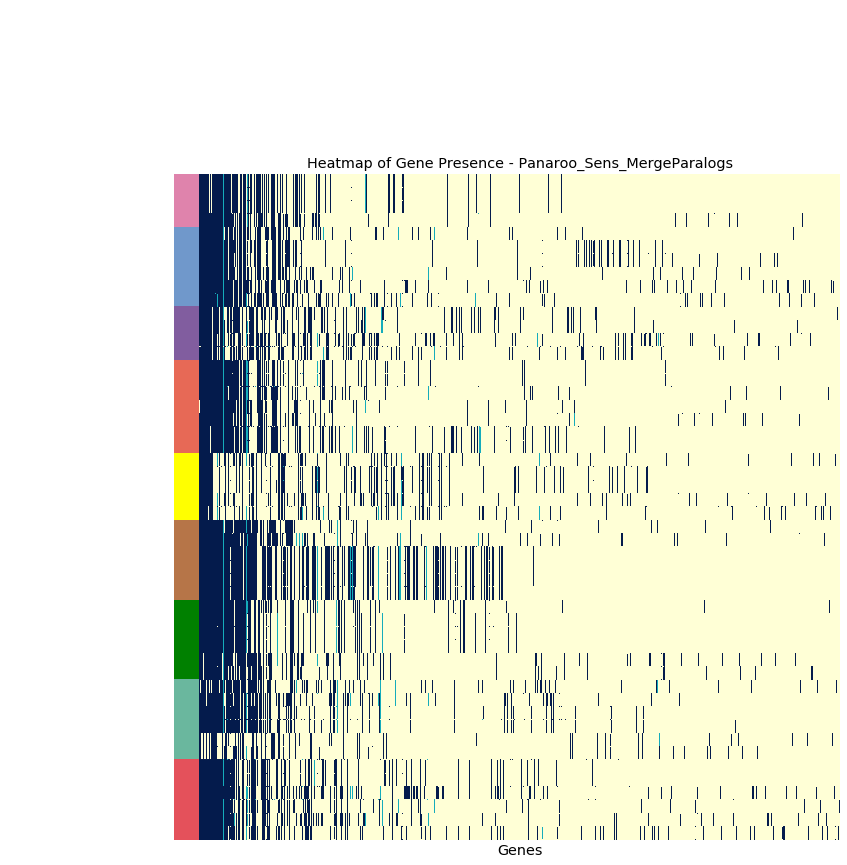

Roary_Default
(50, 19006)


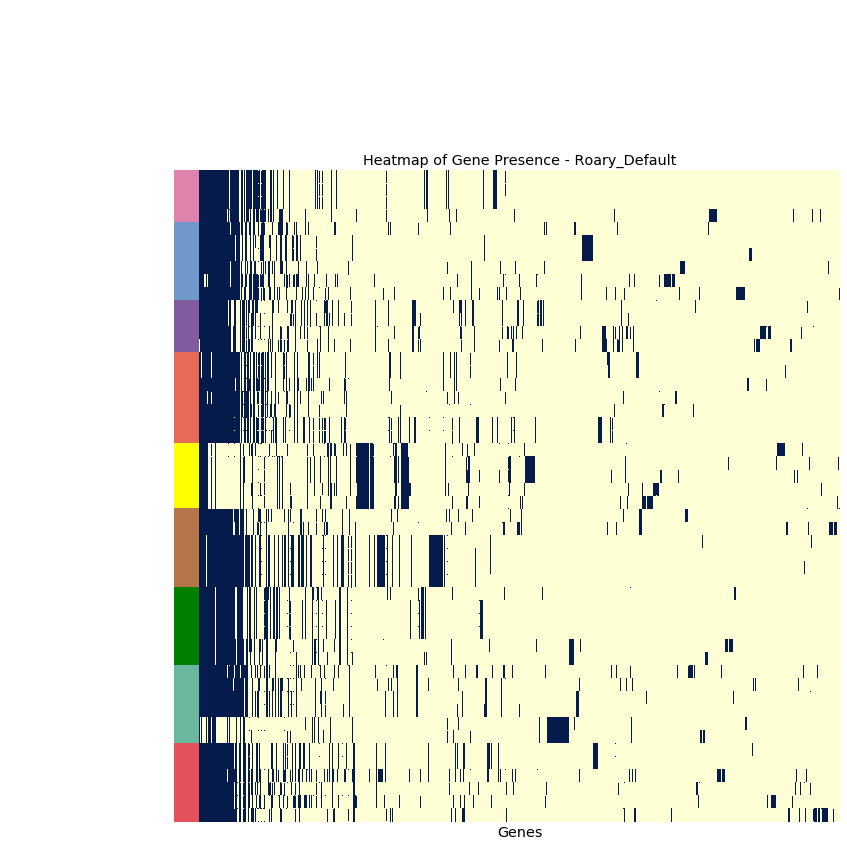

(50, 17365)


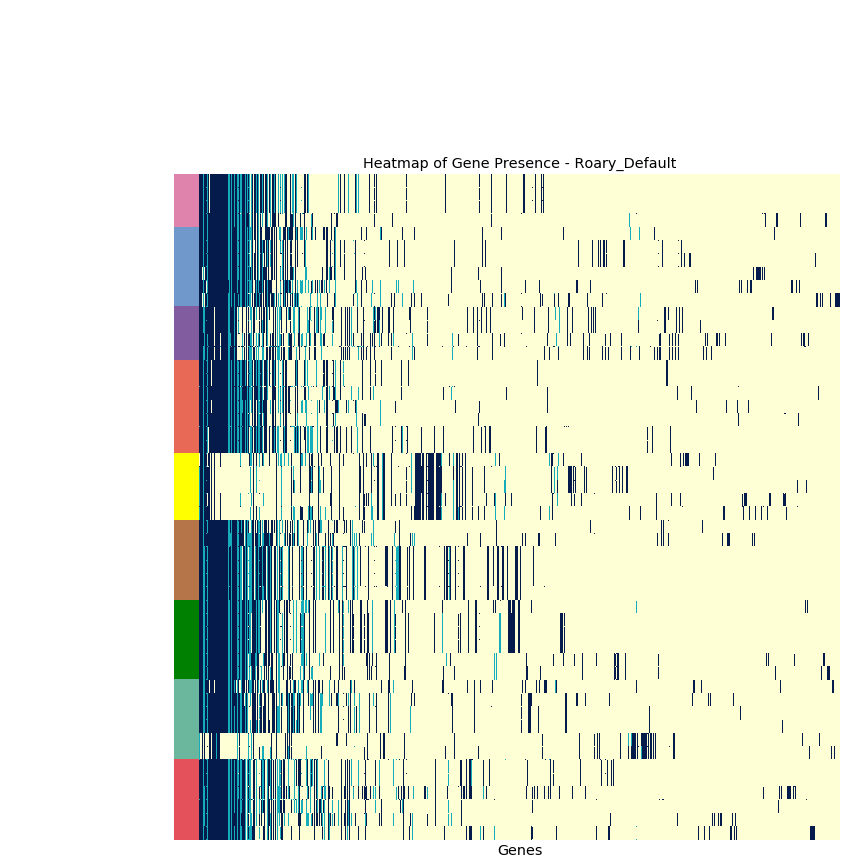

Roary_NoSplitParalogs
(50, 15299)


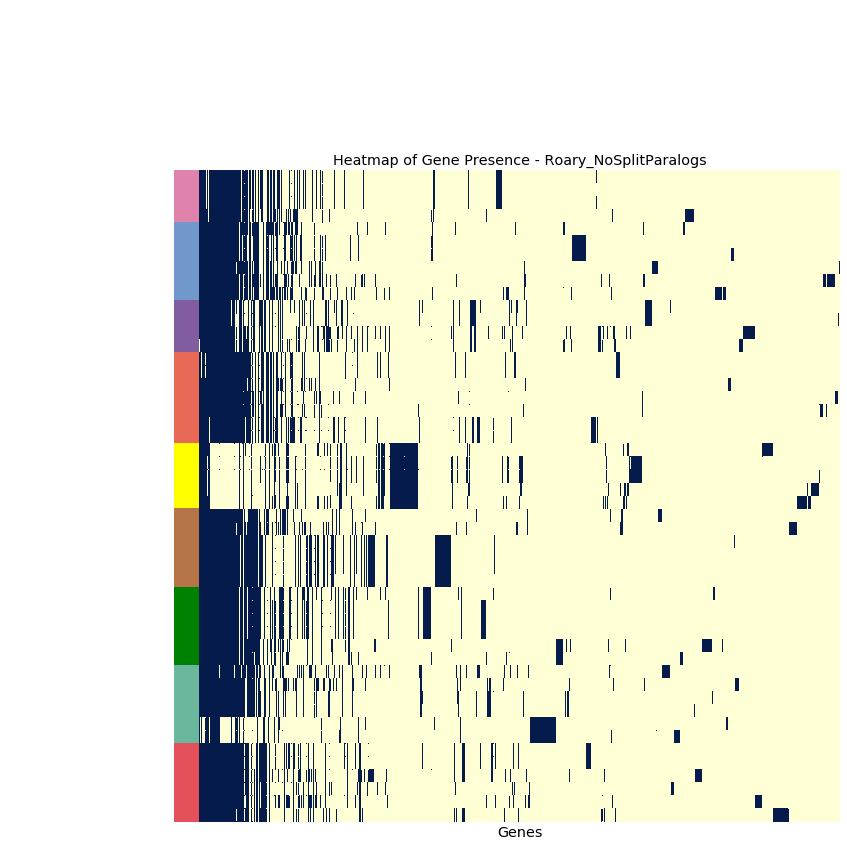

(50, 15234)


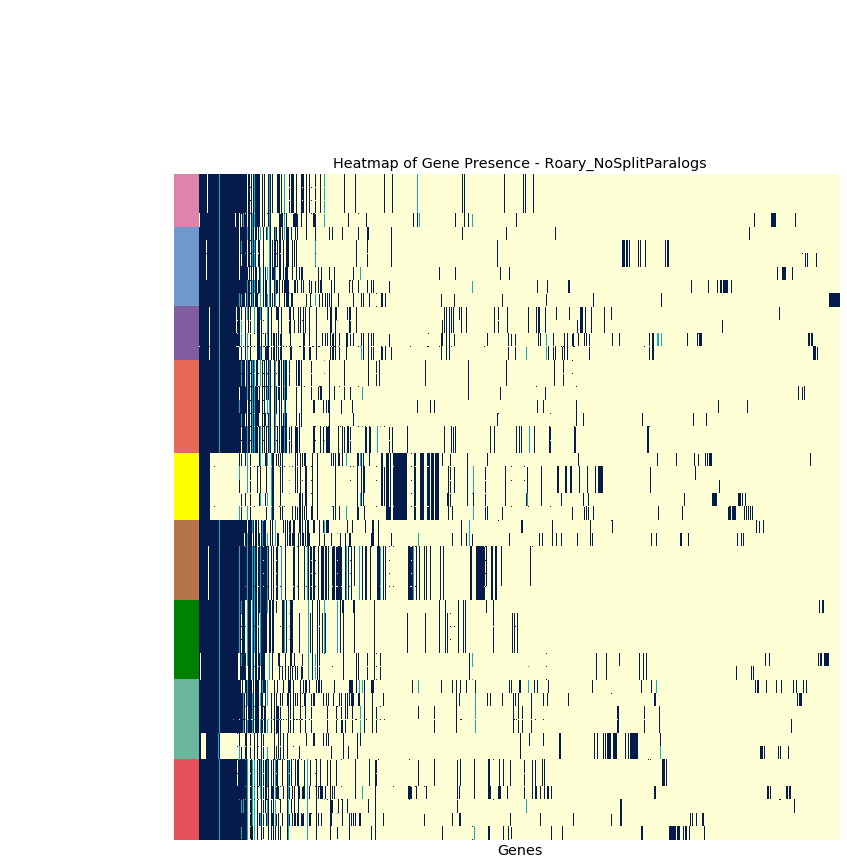

Roary_NoSplitParalogs_I90
(50, 11936)


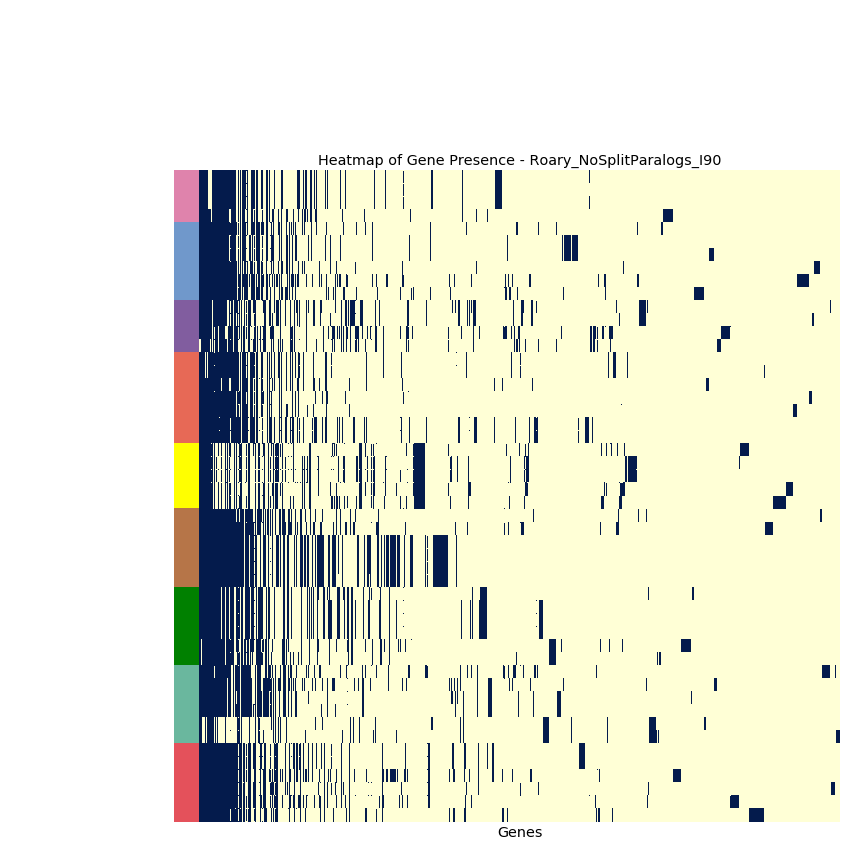

(50, 11910)


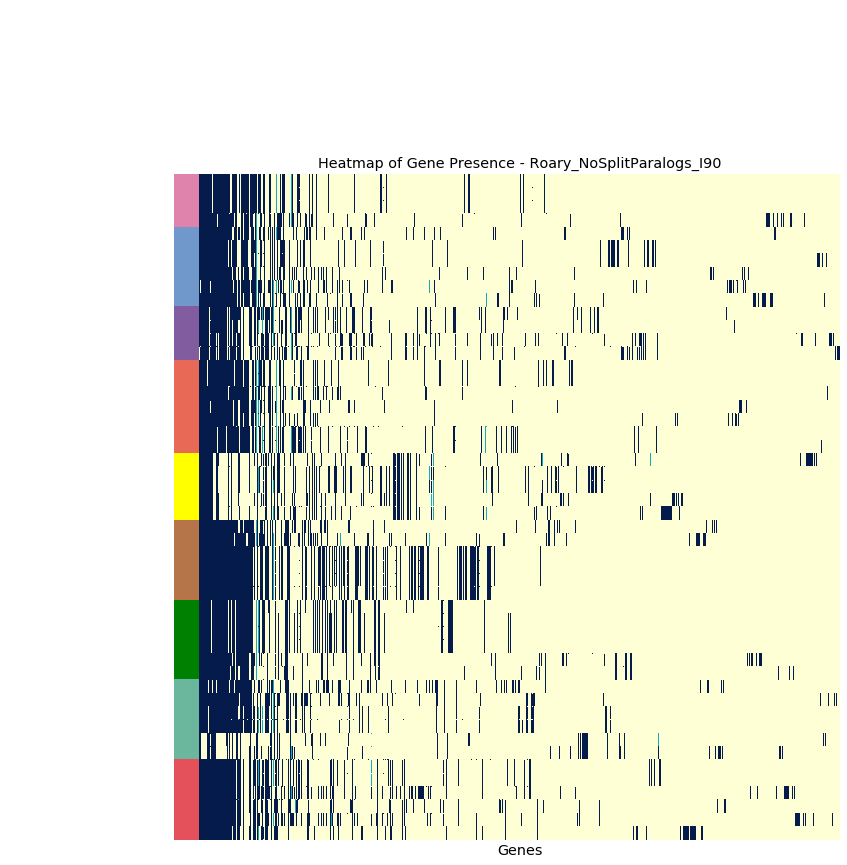

SR_Panaroo_Strict_MergeParalogs
(50, 10002)


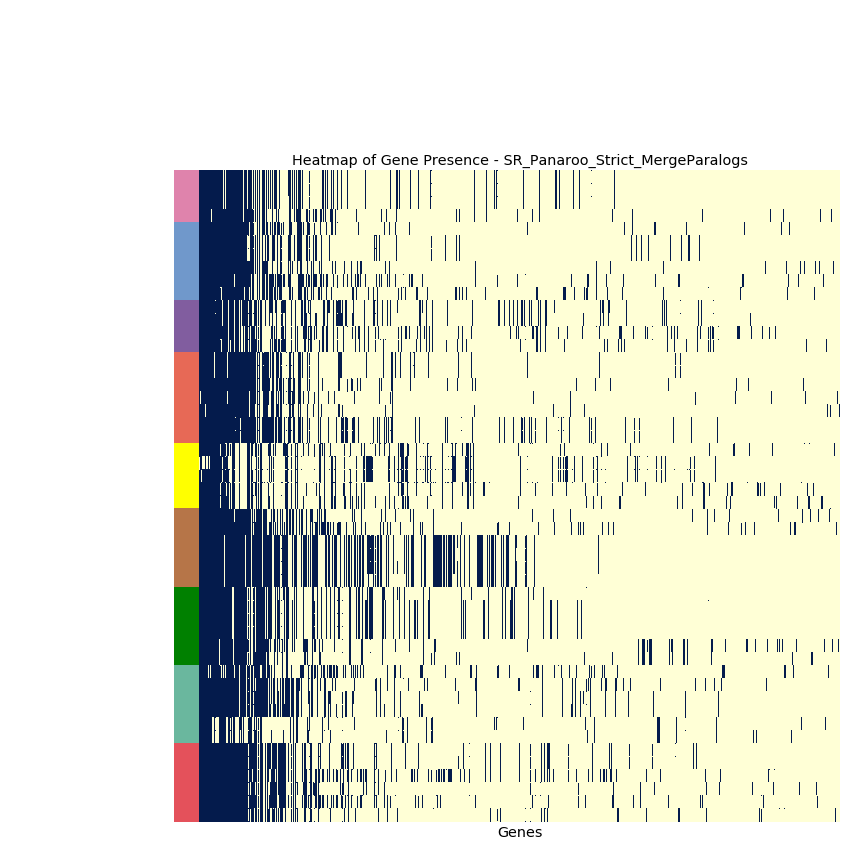

(50, 9951)


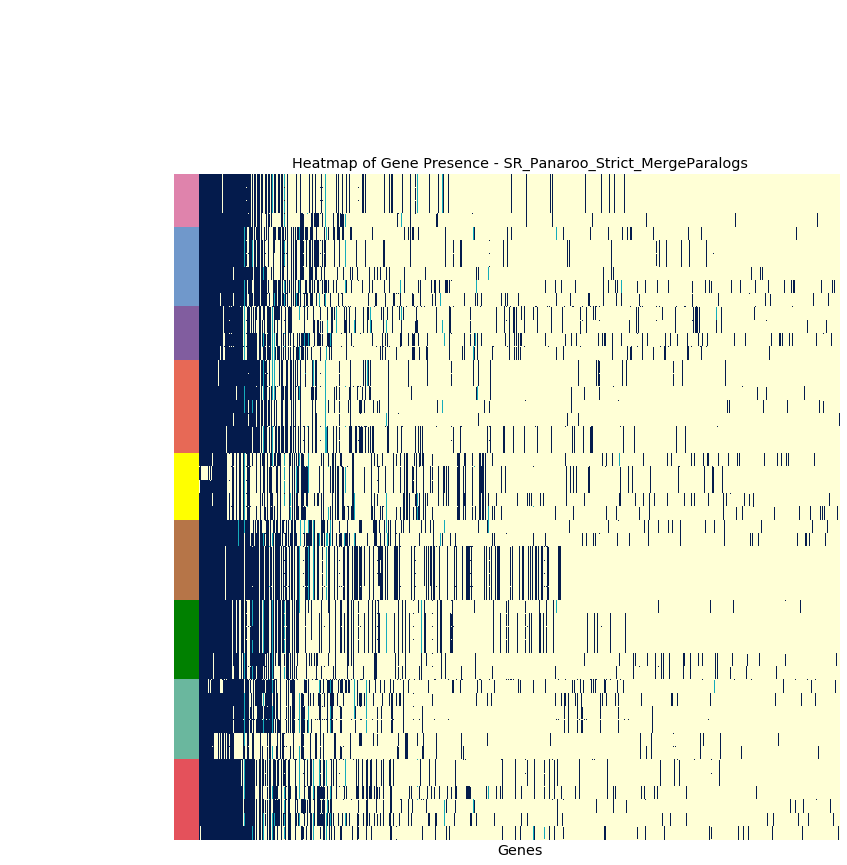

SR_Panaroo_Moderate_MergeParalogs
(50, 10628)


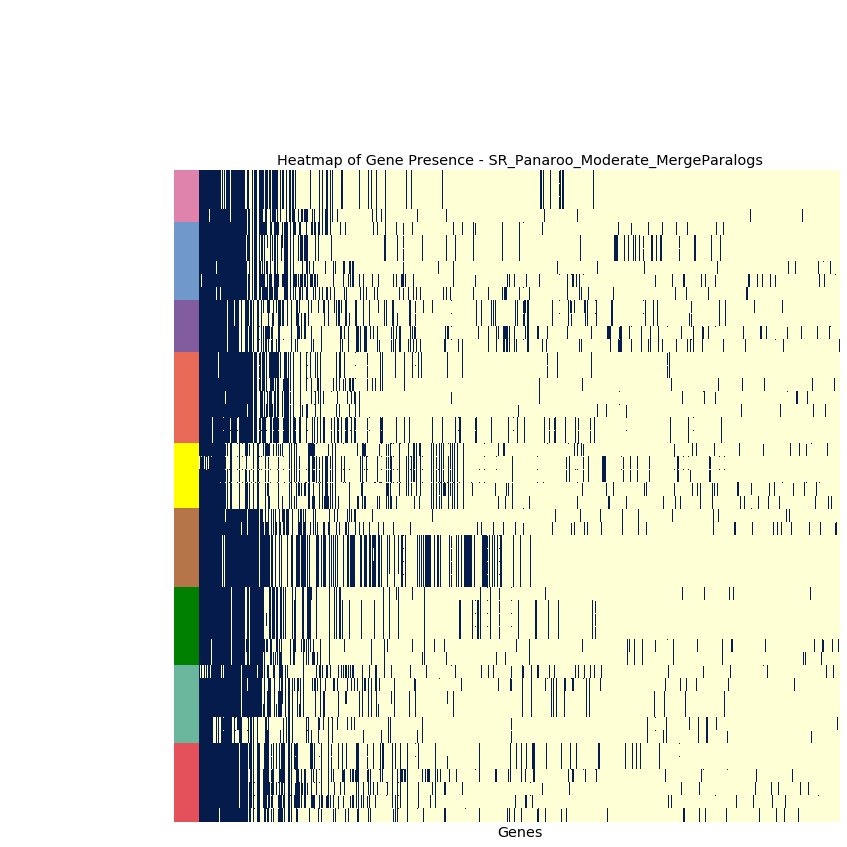

(50, 10549)


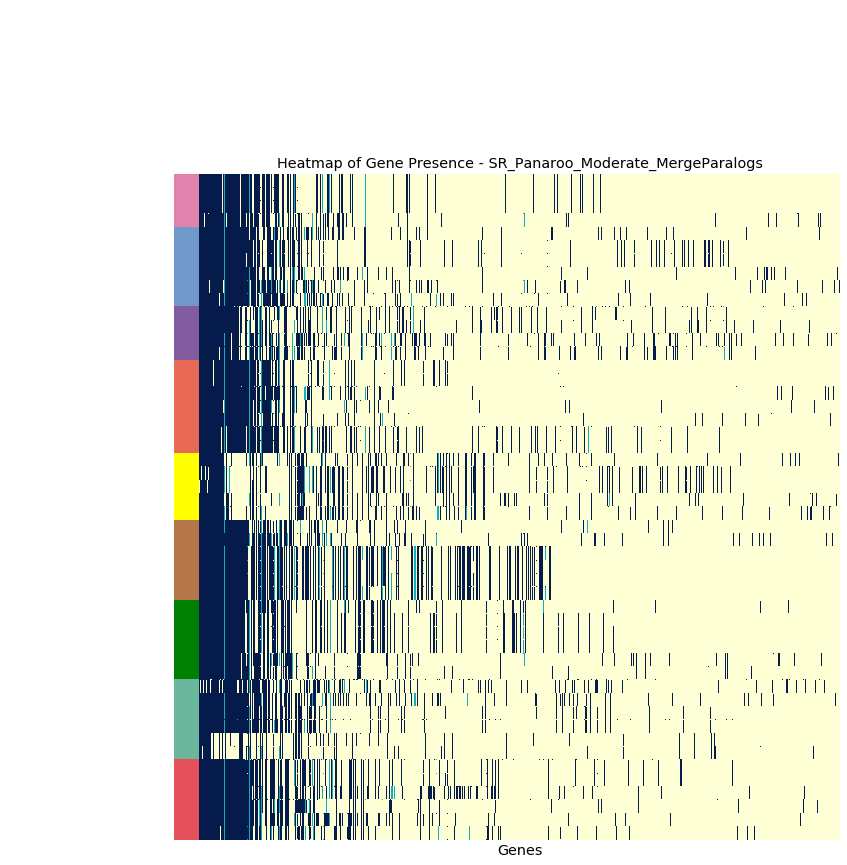

SR_Panaroo_Sens_MergeParalogs
(50, 12690)


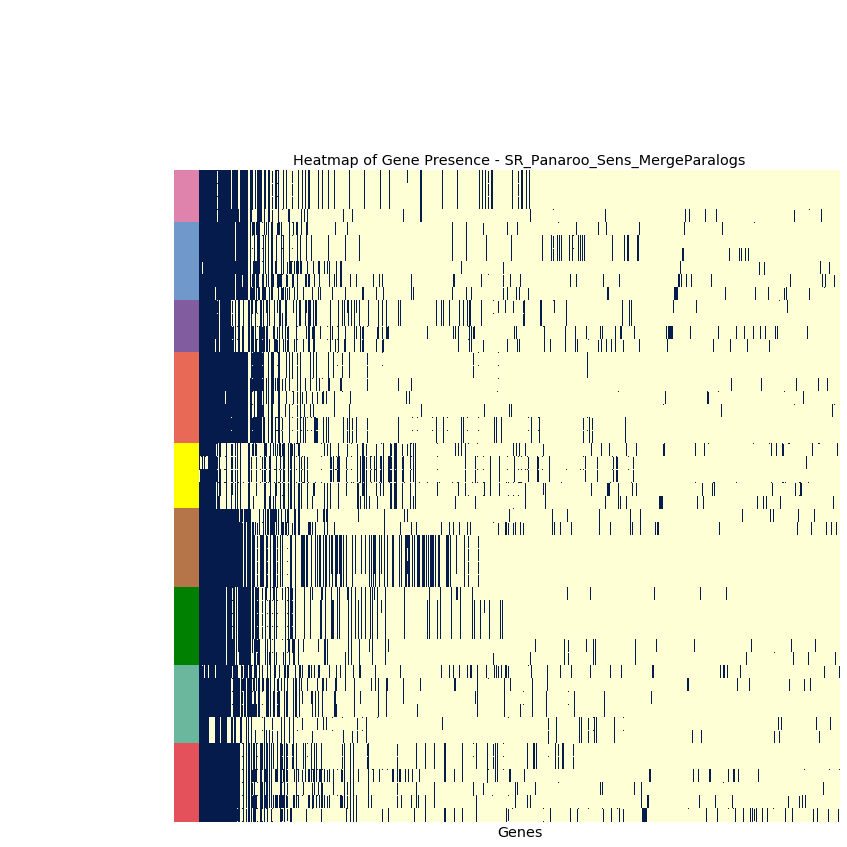

(50, 12480)


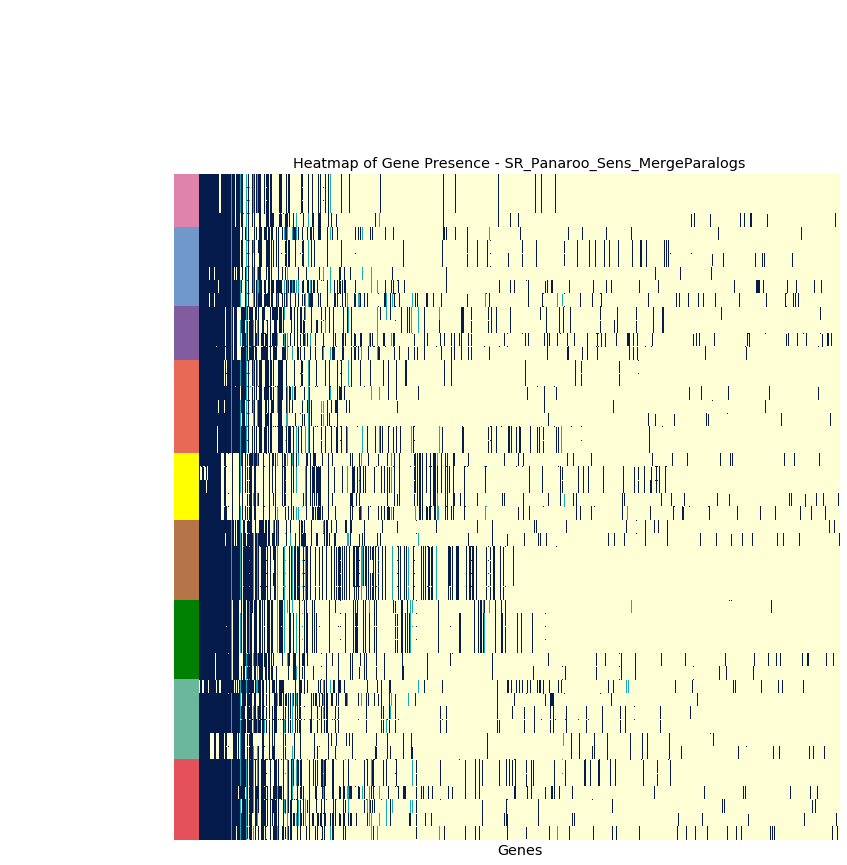

SR_Roary_Default
(50, 17487)


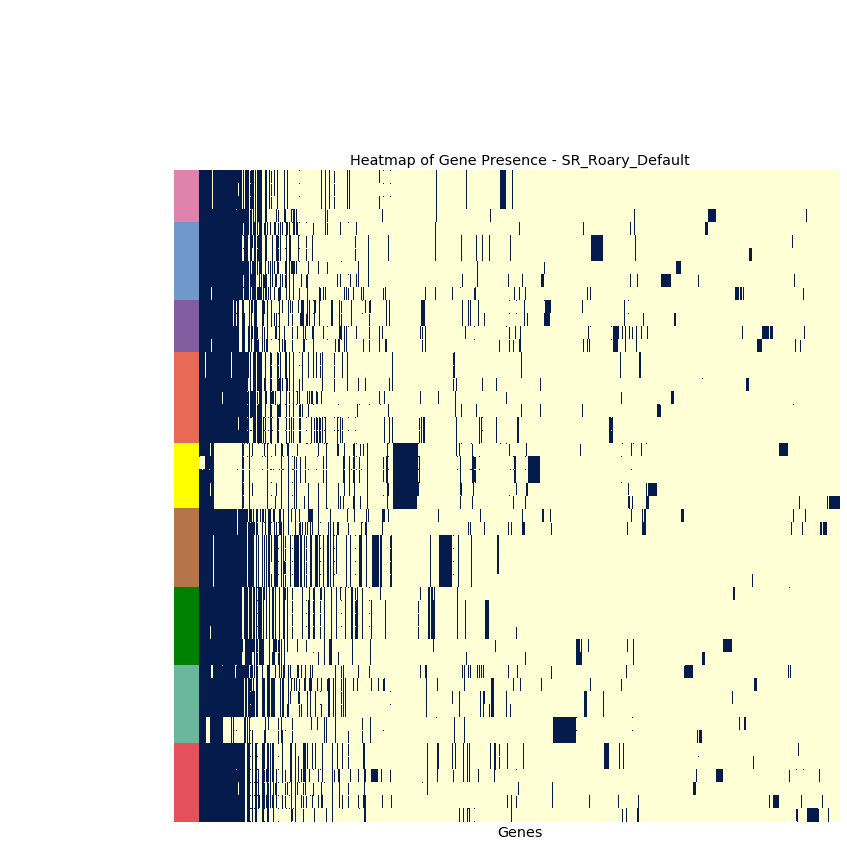

(50, 16934)


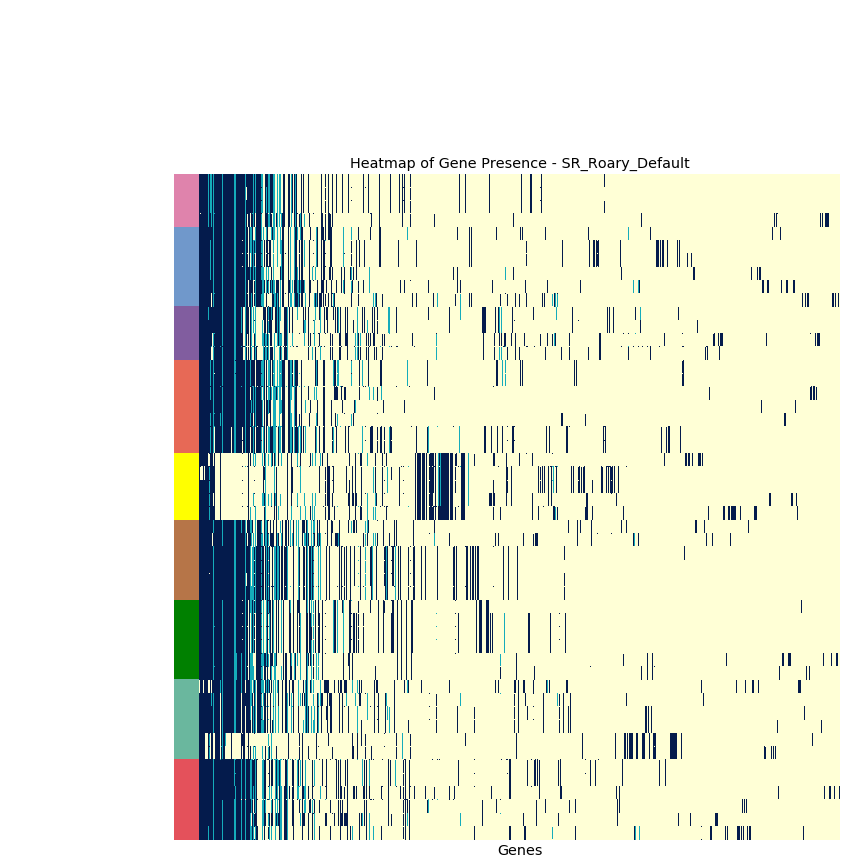

SR_Roary_NoSplitParalogs
(50, 15511)


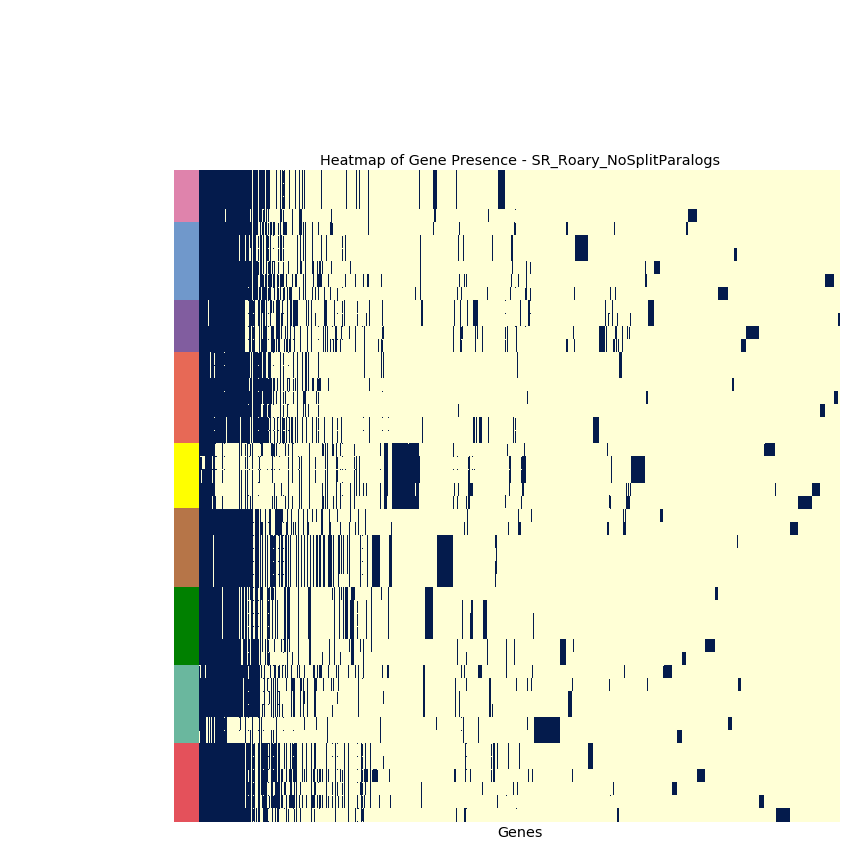

(50, 15420)


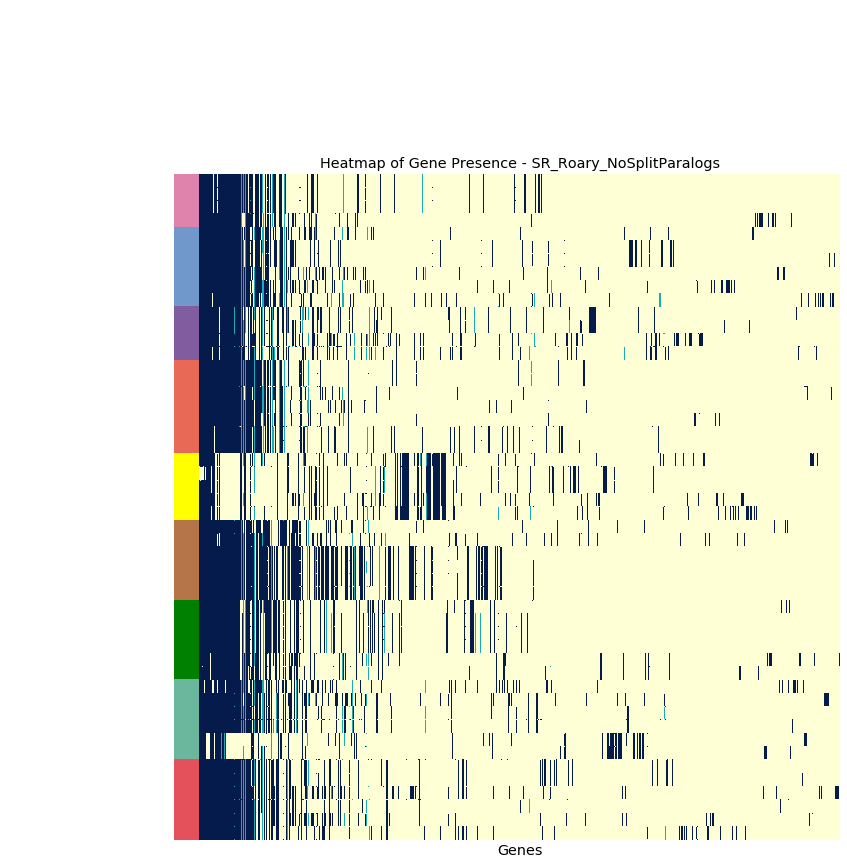

SR_Roary_NoSplitParalogs_I90
(50, 12222)


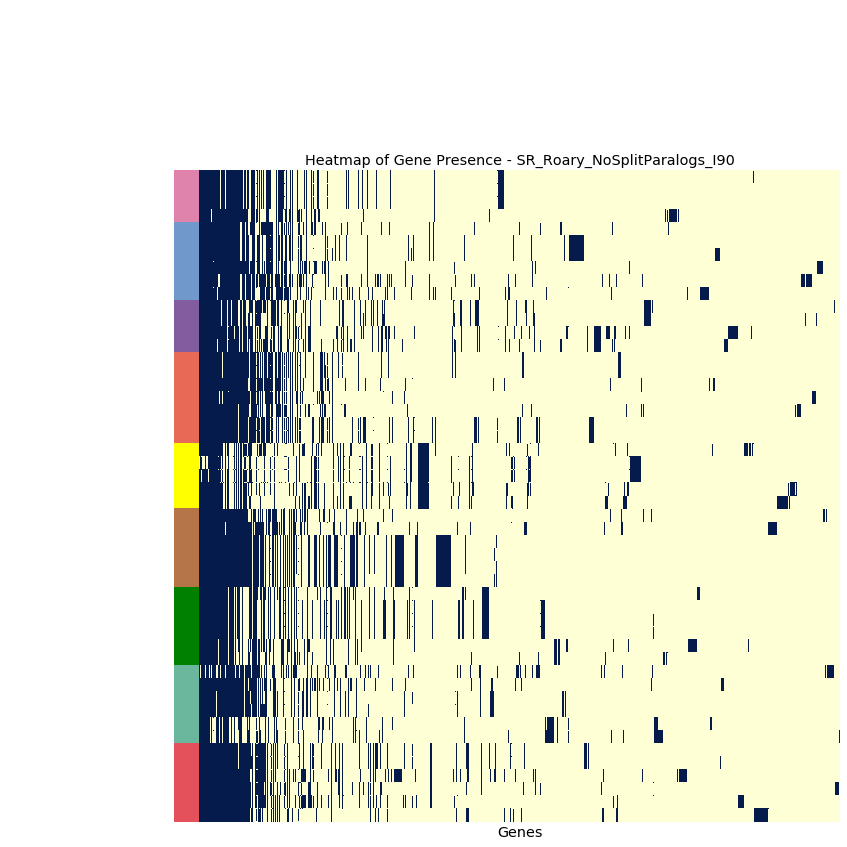

(50, 12165)


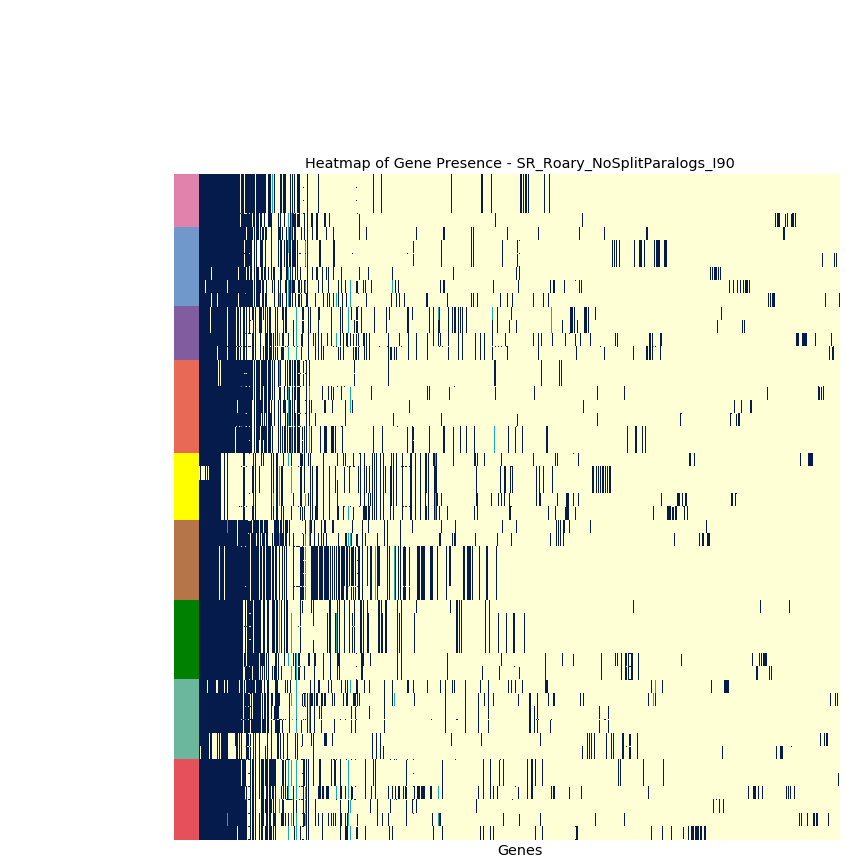

In [138]:
for i_Param in list(PresAbs_DF_AsmSeqChk_Dict.keys()): #['SR_Panaroo_Strict',  'SR_Roary_Default',]: 
                #'SR_Panaroo_Moderate', 'SR_Panaroo_Sens', 'SR_Roary_Default', 'SR_Roary_NoSplitParalogs', 'SR_Roary_NoSplitParalogs_I90']:

    print(i_Param)

    DF = PresAbs_DF_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)
    
    heatmap_data = DF.query("NumAsm_WiGene  < 50")[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_PGQC_3, vmax= 3,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    # Plotting the heatmap - AFTER SR AND LR Asm QC

    DF = PresAbs_AsmSeqCheck_And_NSC08_Dict[i_Param].sort_values("NumAsm_WiGene", ascending=False)
    
    heatmap_data = DF.query("NumAsm_WiGene  < 50")[OrderOfSampleIDs_Phylo].T
    print(heatmap_data.shape)
    
    row_colors = [sample_colors.get(sample, "black") for sample in heatmap_data.index]
    
    # Plotting the heatmap - BEFORE QC
    
    fig_dims = (12, 12)
    clustermap_plot = sns.clustermap(heatmap_data, 
                                     row_colors=row_colors,
                                     cmap = custom_cmap_PGQC_3, vmax= 3,
                                     figsize=fig_dims, 
                                     row_cluster=False, col_cluster=False,
                                     cbar_pos = None,
                                     linewidths=0,
                                     xticklabels=False,
                                     yticklabels=False)
    
    #sns.heatmap(heatmap_data, cmap = custom_cmap, cbar=False, xticklabels=False, yticklabels=False, vmax=5)
    plt.title(f'Heatmap of Gene Presence - {i_Param}')
    plt.ylabel('Assemblies')
    plt.ylabel('')
    
    plt.xlabel('Genes')
    plt.show() 

    #break 

